In [524]:
import sys
import numpy as np
import math

import pickle as pl

import flory

from tqdm import tqdm

sys.path.append('../..')
print(np.__version__)
import multicomp as mm

import importlib

from scipy import cluster, spatial

from scipy.optimize import minimize
from scipy.optimize import basinhopping
from scipy.optimize import differential_evolution
sys.path.append('/Users/calvinsmith/dufresne_lab/lab_work/modules')
import generate as gen
import plots 
importlib.reload(gen)
importlib.reload(plots)

2.0.0


<module 'flory_plots' from '/Users/calvinsmith/dufresne_lab/lab_work/llps_classification/flory_plots.py'>

# Set up Chemical interaction Matrix

First we set Chis for 5x5 chemical interaction matrix

In [525]:
num_comps = 5
chi_strength = 5

chi_matrix = gen.random_interaction_matrix(num_comps,chi_strength)
print(chi_matrix)

[[0.         4.47650559 5.68574957 6.5604925  7.36598012]
 [4.47650559 0.         5.92464476 4.87983622 3.78445752]
 [5.68574957 5.92464476 0.         4.40530107 5.92680907]
 [6.5604925  4.87983622 4.40530107 0.         6.1579554 ]
 [7.36598012 3.78445752 5.92680907 6.1579554  0.        ]]


#  Selecting Points & NOT function

 phi_1 + phi_2 = 0.3. Use for encoding [0,1]: f(phi_1,phi_2) = phi_1/(phi_1 + phi_2). If solution is just phi_1 then phi_1/(phi_1) = 1 and if solution is all phi_2 then 0/(phi_2) = 0. We also assert that if f is > 0.5 then we round to 1 and if f < 0.5 we round to 0. This gives us a continuous function mapping phi_1 and phi_2 to [0,1].
 
 Now if we hold our hidden concentration and outputs constant we only have to adjust phi_1 and phi_2 to define the viable space of selected input points.
 
 We define two functions map_to_zero_one which converts (phi_1,phi_2) to [0,1] and map_to_point which takes [0,1] and maps to (phi_1,phi_2)
 


In [526]:
phi_H = 0.2 
phi_out_1 = 0.15
phi_out_2 = 0.15
phi_const = [phi_H,phi_out_1,phi_out_2]
phi_in_range = 0.3
num_of_points = 15

# phi_H + ... = 1 - phi_sol. Needs to be less than 1

def map_to_zero_one(phi_1, phi_2):
    phi_final = phi_1/(phi_1+phi_2)
    return phi_final

def map_to_point(phi_in):
    phi_1 = phi_in_range*phi_in
    phi_2 = phi_in_range*(1-phi_in)
    point = [phi_1,phi_2]
    return point

points = []
cords = []
for i in range(0,num_of_points +1):
    point = [i, num_of_points -i]
    x = map_to_zero_one(point[0],point[1])
    cords.append(map_to_point(x))
    points.append(x)
    
    
print('0,1 points:' + str(points) + '\n')
print('coordinates: ' + str(cords) + '\n')

# phi_space represents the space of 5 components that fit our conditions for phi_in.
phi_space = []
for cord in cords:
    phi_in = cord + phi_const
    phi_space.append(phi_in)
    
    
print(phi_space)
    






0,1 points:[0.0, 0.06666666666666667, 0.13333333333333333, 0.2, 0.26666666666666666, 0.3333333333333333, 0.4, 0.4666666666666667, 0.5333333333333333, 0.6, 0.6666666666666666, 0.7333333333333333, 0.8, 0.8666666666666667, 0.9333333333333333, 1.0]

coordinates: [[0.0, 0.3], [0.02, 0.27999999999999997], [0.04, 0.26], [0.06, 0.24], [0.08, 0.22], [0.09999999999999999, 0.2], [0.12, 0.18], [0.13999999999999999, 0.16], [0.16, 0.13999999999999999], [0.18, 0.12], [0.19999999999999998, 0.1], [0.21999999999999997, 0.08000000000000002], [0.24, 0.059999999999999984], [0.26, 0.03999999999999999], [0.27999999999999997, 0.019999999999999993], [0.3, 0.0]]

[[0.0, 0.3, 0.2, 0.15, 0.15], [0.02, 0.27999999999999997, 0.2, 0.15, 0.15], [0.04, 0.26, 0.2, 0.15, 0.15], [0.06, 0.24, 0.2, 0.15, 0.15], [0.08, 0.22, 0.2, 0.15, 0.15], [0.09999999999999999, 0.2, 0.2, 0.15, 0.15], [0.12, 0.18, 0.2, 0.15, 0.15], [0.13999999999999999, 0.16, 0.2, 0.15, 0.15], [0.16, 0.13999999999999999, 0.2, 0.15, 0.15], [0.18, 0.12, 0.2,

In [527]:
dynamics_params = {
    "initialization_random_std": 5,  # how random the initial guess is
    "acceptance_Js": 0.0002, # how fast the relative volumes are evolved
    "acceptance_omega": 0.002, # how fast the compositions are evolved
}

evolve_params = {
    "t_range": 1000000,  # maximum iteration steps
    "dt": 1,  # always unity for FieldLikeRelaxationDynamics
    "interval": 10000,  # the frequency for checking convergence
    "tolerance": 1e-5,  # criteria for determining convergence
    "progress": True,
    "save_intermediate_data": False,
}

# Time Evolution Algorithm

Below is the TE algo. This will be compressed soon as I wrote a function generate.py that does this. For now we leave it to make sure we understand what is happening.

In [528]:
phase_results = []

for phi_vector in phi_space: 
    num_compartments = 64
    phis = [phi_vector] * num_compartments

    arr_phi = np.array(phis)
    arr_vol = np.ones(num_compartments) / num_compartments
    # number of phases that the system will generate
    num_compartments = 64 # a overkill but safe choice for 4+1 components
    # create the Flory-Huggins free energy
    fh_energy = mm.FloryHuggins(np.array(chi_matrix))
    # generate a collection of compartments
    # we generate compartments that all of them share the same composition, namely the average composition, here.
    # the FieldLikeRelaxationDynamics afterwards will add fluctuations to the compositions itself.
    phis = [phi_vector] * num_compartments


    mixture = mm.MultiphaseVolumeSystem(
        fh_energy, 
        np.array(phis), # compositions of each compartment
        np.ones(num_compartments) / num_compartments # relative volume of each compartment
    )
    dynamics = mm.FieldLikeRelaxationDynamics(mixture, parameters=dynamics_params)
    ts, result = dynamics.evolve(**evolve_params)
    unique_phases = result.get_clusters()
    print(len(unique_phases), "phases are found")
    print("Compositions are ")
    print(unique_phases)
    print("Convergence is (lower the better) ")
    print(result.entropy_production)
    
    array = [phi_vector,result]
    phase_results.append(array)








  0%|                                                   | 0/100 [00:00<?, ?it/s]




  1%|▍                                          | 1/100 [00:00<00:11,  8.32it/s]




  3%|█▎                                         | 3/100 [00:00<00:09, 10.49it/s]




  5%|██▏                                        | 5/100 [00:00<00:08, 11.04it/s]




  7%|███                                        | 7/100 [00:00<00:08, 11.37it/s]




  9%|███▊                                       | 9/100 [00:00<00:07, 11.51it/s]




 11%|████▌                                     | 11/100 [00:00<00:07, 11.58it/s]




 13%|█████▍                                    | 13/100 [00:01<00:08, 10.56it/s]
/Users/calvinsmith/dufresne_lab/multicomponent-mixtures-main/simulations/notebooks/../../multicomp/thermodynamics.py:387: RuntimeWarning: divide by zero encountered in log
  np.log(phis) - np.log(phi_sol) + np.einsum("...i,ij->...j", phis, self.chis)
/Users/calvinsmith/dufresne_lab/multicomponent-mixtures-main/simulat

4 phases are found
Compositions are 
[[0.         0.00815586 0.76900535 0.02941901 0.00798707]
 [0.         0.02030804 0.03177844 0.74669979 0.00759473]
 [0.         0.05715488 0.00950459 0.00838542 0.72696137]
 [0.         0.68799421 0.0114922  0.02428871 0.06411342]]
Convergence is (lower the better) 
nan







  0%|                                                   | 0/100 [00:00<?, ?it/s]




  2%|▊                                          | 2/100 [00:00<00:08, 11.40it/s]




  4%|█▋                                         | 4/100 [00:00<00:08, 11.32it/s]




  6%|██▌                                        | 6/100 [00:00<00:08, 11.30it/s]




  8%|███▍                                       | 8/100 [00:00<00:08, 11.38it/s]




 10%|████▏                                     | 10/100 [00:00<00:07, 11.38it/s]




 12%|█████                                     | 12/100 [00:01<00:07, 11.32it/s]




 14%|█████▉                                    | 14/100 [00:01<00:07, 11.32it/s]




 16%|██████▋                                   | 16/100 [00:01<00:07, 11.39it/s]




 19%|███████▉                                  | 19/100 [00:01<00:07, 10.79it/s]


5 phases are found
Compositions are 
[[0.00987052 0.00812361 0.76654184 0.02961804 0.00803746]
 [0.00535217 0.0190474  0.03061616 0.75683017 0.00722122]
 [0.0030624  0.05157502 0.00862965 0.00756655 0.74784231]
 [0.03652524 0.62021992 0.01537248 0.02966579 0.07130237]
 [0.79322737 0.0236225  0.00885973 0.00442434 0.00232007]]
Convergence is (lower the better) 
2.4584923149518206e-08







  0%|                                                   | 0/100 [00:00<?, ?it/s]




  2%|▊                                          | 2/100 [00:00<00:08, 11.27it/s]




  4%|█▋                                         | 4/100 [00:00<00:08, 11.40it/s]




  6%|██▌                                        | 6/100 [00:00<00:08, 11.43it/s]




  8%|███▍                                       | 8/100 [00:00<00:08, 11.46it/s]




 10%|████▏                                     | 10/100 [00:00<00:07, 11.41it/s]




 12%|█████                                     | 12/100 [00:01<00:07, 11.47it/s]




 14%|█████▉                                    | 14/100 [00:01<00:07, 11.49it/s]




 16%|██████▋                                   | 16/100 [00:01<00:07, 11.51it/s]




 18%|███████▌                                  | 18/100 [00:01<00:07, 10.87it/s]


5 phases are found
Compositions are 
[[0.79181147 0.02372502 0.00891667 0.00445821 0.00234044]
 [0.00994875 0.00818895 0.76477984 0.02980349 0.00810388]
 [0.00540547 0.01917183 0.03081709 0.75497938 0.0072878 ]
 [0.00309632 0.0518259  0.00870152 0.00763421 0.74604577]
 [0.03694907 0.61586899 0.01566888 0.03010167 0.07212115]]
Convergence is (lower the better) 
1.384512847376582e-07







  0%|                                                   | 0/100 [00:00<?, ?it/s]




  2%|▊                                          | 2/100 [00:00<00:08, 11.60it/s]




  4%|█▋                                         | 4/100 [00:00<00:08, 11.61it/s]




  6%|██▌                                        | 6/100 [00:00<00:08, 11.70it/s]




  8%|███▍                                       | 8/100 [00:00<00:07, 11.68it/s]




 10%|████▏                                     | 10/100 [00:00<00:07, 11.62it/s]




 12%|█████                                     | 12/100 [00:01<00:07, 11.59it/s]




 14%|█████▉                                    | 14/100 [00:01<00:07, 11.57it/s]




 16%|██████▋                                   | 16/100 [00:01<00:07, 10.90it/s]


5 phases are found
Compositions are 
[[0.7903291  0.02383325 0.00897684 0.004494   0.00236197]
 [0.01003101 0.00825783 0.76293684 0.02999851 0.00817384]
 [0.00546182 0.01930321 0.03102936 0.7530392  0.0073582 ]
 [0.00313223 0.05209075 0.00877755 0.0077058  0.74416268]
 [0.03740114 0.6112428  0.01598962 0.03057058 0.07299746]]
Convergence is (lower the better) 
2.2263270266010719e-07







  0%|                                                   | 0/100 [00:00<?, ?it/s]




  2%|▊                                          | 2/100 [00:00<00:08, 11.48it/s]




  4%|█▋                                         | 4/100 [00:00<00:08, 11.50it/s]




  6%|██▌                                        | 6/100 [00:00<00:08, 11.51it/s]




  8%|███▍                                       | 8/100 [00:00<00:07, 11.53it/s]




 10%|████▏                                     | 10/100 [00:00<00:07, 11.56it/s]




 12%|█████                                     | 12/100 [00:01<00:07, 11.55it/s]




 14%|█████▉                                    | 14/100 [00:01<00:07, 11.59it/s]




 16%|██████▋                                   | 16/100 [00:01<00:07, 10.87it/s]


5 phases are found
Compositions are 
[[0.7887808  0.02394634 0.0090401  0.0045317  0.00238467]
 [0.01011795 0.00833054 0.7610046  0.03020451 0.00824781]
 [0.00552142 0.01944135 0.03125308 0.75100677 0.00743261]
 [0.00317027 0.05236856 0.00885782 0.00778148 0.74219128]
 [0.03788779 0.60628899 0.01633963 0.03107951 0.07394388]]
Convergence is (lower the better) 
3.2743149561964175e-07







  0%|                                                   | 0/100 [00:00<?, ?it/s]




  2%|▊                                          | 2/100 [00:00<00:08, 11.81it/s]




  4%|█▋                                         | 4/100 [00:00<00:08, 11.81it/s]




  6%|██▌                                        | 6/100 [00:00<00:08, 11.69it/s]




  8%|███▍                                       | 8/100 [00:00<00:07, 11.72it/s]




 10%|████▏                                     | 10/100 [00:00<00:07, 11.71it/s]




 12%|█████                                     | 12/100 [00:01<00:07, 11.70it/s]




 15%|██████▎                                   | 15/100 [00:01<00:07, 10.97it/s]


KeyboardInterrupt: 

In [ ]:
phase_points = []
phase_points_2 = []
for phase in phase_results:
    a = map_to_zero_one(phase[0][0],phase[0][1])
    unique_phases = phase[1].get_clusters()
    b = map_to_zero_one(float(unique_phases[0][3]),float(unique_phases[0][4]))
    point = [a,b]
    phase_points.append([a,b])


print(phase_points)

import matplotlib.pyplot as plt

def plot_points(data):
   
    
    x_coords = [point[0] for point in data]
    y_coords = [point[1] for point in data]

    # Create the plot
    plt.figure(figsize=(6, 6))
    plt.scatter(x_coords, y_coords, color='blue', marker='o')
    plt.ylim(0, 1)
    # Add labels and title
    plt.xlabel("Phi_In")
    plt.ylabel("Phi_Out")
    plt.title("Phi_In vs Phi_Out Normalized to [0,1]")

    # Show grid
    plt.grid(True)

    # Display the plot
    plt.show()


plot_points(phase_points)
plot_points


In [ ]:
test_phase = phase_results[3][1]
print(test_phase.amounts[:3])




# Finding the Phase with most Volume

We pick the phase with the most volume since not sure about how to calculate the most dilute phase. Either way still useful. 

Essentially we select all the indexes of the unique phases in the 64*6 compartments. then we sum the volumes for each of these index in the compartment volumes using the .amounts() function in mixtures.py for the respective phases. Then we compare the net phase volumes to find the phase with most volume. 


In [ ]:
def find_max_vol_phase(test_phase,num_comps):
    #print(test_phase.phi_all)
    unique_phases = test_phase.get_clusters()

    total_list = []
    for phase in unique_phases:
        phase_list = [phase]
        for i in range(len(test_phase.phi_all)):
            index_list = []
            if tuple(test_phase.phi_all[i]) == tuple(phase):
                index_list.append(i)

        phase_list.append(index_list)
        total_list.append(phase_list)
    unique_phases = test_phase.get_clusters()
    
    total_list = []
    for phase in unique_phases:
        #print(phase)
        phase_list = []
        phase_list.append(phase)
        index_list = []
        for i in range(len(test_phase.phi_all)):
            #print(test_phase.phi_all[i][:5])
            matrix = []
            matrix.append(phase)
            matrix.append(test_phase.phi_all[i][:num_comps])
            if spatial.distance.pdist(matrix) < 10e-2:
                index_list.append(i)

        phase_list.append(index_list)
        #print(phase_list)
        #print('\n')
        total_list.append(phase_list)

    #print(total_list)
    volumes = []
    for list in total_list:
        phase_vol_list = [list[0]]

        total = 0
        #print(total_list[0])
        for i in list[1]:
            total += sum(test_phase.amounts[i])
        phase_vol_list.append(total)
        volumes.append(phase_vol_list)
    #print(volumes)

    
    vol_list = []
    for x in volumes:
        vol_list.append(x[1])
    max_vol = max(vol_list)

    for x in volumes:
        if x[1] == max_vol:
            max_vol_phase = x[0]
            #print('the phase with the most volume is ' + str(max_vol_phase) + 'with the volume of ' + str(max_vol))
    return max_vol_phase 


In [ ]:
find_max_vol_phase(test_phase)

# Plotting Points

We can now plot the phi_in vs phi_out. Phi_out in this case is the same as the phi_in mapping: g(phi_out_1, phi_out_2) = phi_out_1'/(phi_out_1' + phi_out_2'). So if g < 0.5 then 0 and if g>0.5 then 1. 

Thus selecting from out phase_space we can map all the points using the functions we've developed. 

In [ ]:
phase_points = []
phase_points_2 = []
for phase in phase_results:
    a = map_to_zero_one(phase[0][0],phase[0][1])
    unique_phases = find_max_vol_phase(phase[1])
    print(unique_phases)
    b = map_to_zero_one(float(unique_phases[3]),float(unique_phases[4]))
    point = [a,b]
    phase_points.append([a,b])

print(plot_points)

import matplotlib.pyplot as plt

def plot_points(data):
    """
    Plots 2D points from a dataset.

    Args:
        data: A list of lists, where each inner list contains two values [x, y].
    """
    # Separate the x and y coordinates
    x_coords = [point[0] for point in data]
    y_coords = [point[1] for point in data]

    # Create the plot
    plt.figure(figsize=(6, 6))
    plt.scatter(x_coords, y_coords, color='blue', marker='o')
    plt.ylim(0, 1)
    # Add labels and title
    plt.xlabel("Phi_In")
    plt.ylabel("Phi_Out")
    plt.title("Phi_In vs Phi_Out Normalized to [0,1]")


    # Show grid
    plt.grid(True)

    # Display the plot
    plt.show()


plot_points(phase_points)
plot_points


# 3 Component 
Attempt with 3 components + solvent [phi_in,phi_H, phi_out]. We define our input as [o,phi_thresh] -> [0,1] and our output readout function as f(phi_in, phi_out) = e^-(phi_in/phi_out) -> [0,1] , this function is defined such that when phi_out >> phi_in -> 1 and when phi_in >> phi_out -> 0. 

Note: We write our code such that we can use different readout functions later.

In [130]:
def output_readout_func(phi_in, phi_out):
    x = math.exp(-(phi_in/phi_out))
    return x

output_readout_func(,)

0.36787944117144233

In [391]:
#generate interaction matrix
num_comps = 3
chi_strength = 5

chi_matrix = gen.random_interaction_matrix(num_comps,chi_strength)
print(chi_matrix)

[[0.         4.56300948 5.93621831]
 [4.56300948 0.         5.43896315]
 [5.93621831 5.43896315 0.        ]]


In [191]:
num_of_points = 20
phi_in_thresh = 0.2
phi_H = 0.05
phi_out = 0.2

comp_points = np.linspace(0,phi_in_thresh, num_of_points)
comp_points = comp_points.reshape(num_of_points,1)
#comp_points = comp_points.T

h_array = phi_H*np.ones((num_of_points,1))
out_array = phi_out*np.ones((num_of_points,1))
comp_points = np.concatenate((comp_points, h_array, out_array), axis = 1)
print(comp_points)
norm_points = np.linspace(0,1, num_of_points)





[[0.         0.05       0.2       ]
 [0.01052632 0.05       0.2       ]
 [0.02105263 0.05       0.2       ]
 [0.03157895 0.05       0.2       ]
 [0.04210526 0.05       0.2       ]
 [0.05263158 0.05       0.2       ]
 [0.06315789 0.05       0.2       ]
 [0.07368421 0.05       0.2       ]
 [0.08421053 0.05       0.2       ]
 [0.09473684 0.05       0.2       ]
 [0.10526316 0.05       0.2       ]
 [0.11578947 0.05       0.2       ]
 [0.12631579 0.05       0.2       ]
 [0.13684211 0.05       0.2       ]
 [0.14736842 0.05       0.2       ]
 [0.15789474 0.05       0.2       ]
 [0.16842105 0.05       0.2       ]
 [0.17894737 0.05       0.2       ]
 [0.18947368 0.05       0.2       ]
 [0.2        0.05       0.2       ]]


In [192]:
# number of phases that the system will generate
num_compartments = 16 # a overkill but safe choice for 4+1 components
# create the Flory-Huggins free energy
fh_energy = mm.FloryHuggins(np.array(chi_matrix))

evolve_comp_points = []
for point in comp_points:
    x = gen.evolve_phases_result(point,fh_energy,num_compartments)
    print(x)
    evolve_comp_points.append(x)



In [193]:
dilute_comp_points = []
for result in evolve_comp_points:
    x = find_max_vol_phase(result,num_comps)
    dilute_comp_points.append(x)
output_comp_points = []

dilute_out_comp_arr = np.array(dilute_comp_points)
dilute_out_comp_points = dilute_out_comp_arr[:,[2]]
dilute_in_comp_points = dilute_out_comp_arr[:,[0]]



print(dilute_comp_points)
print(dilute_out_comp_points)

for point in dilute_comp_points:
    x = output_readout_func(point[0],point[1])
    output_comp_points.append(x)

#print(output_comp_points)




[array([0.        , 0.04999999, 0.20000001]), array([0.01052631, 0.04999999, 0.20000002]), array([0.02105262, 0.04999999, 0.20000003]), array([0.03157895, 0.05      , 0.2       ]), array([0.04210526, 0.05      , 0.2       ]), array([0.05263158, 0.05      , 0.2       ]), array([0.06315789, 0.05      , 0.2       ]), array([0.07368421, 0.05      , 0.2       ]), array([0.08421053, 0.05      , 0.2       ]), array([0.09473685, 0.05      , 0.2       ]), array([0.10526318, 0.05      , 0.19999998]), array([0.11578947, 0.05      , 0.2       ]), array([0.12631579, 0.05      , 0.2       ]), array([0.13684212, 0.05      , 0.19999998]), array([0.14736856, 0.04999999, 0.19999985]), array([0.15789477, 0.05      , 0.19999996]), array([0.16842145, 0.04999996, 0.19999961]), array([0.17894787, 0.04999995, 0.19999952]), array([0.1894741 , 0.04999996, 0.19999962]), array([0.20000013, 0.04999999, 0.19999988])]
[[0.20000001]
 [0.20000002]
 [0.20000003]
 [0.2       ]
 [0.2       ]
 [0.2       ]
 [0.2       ]
 

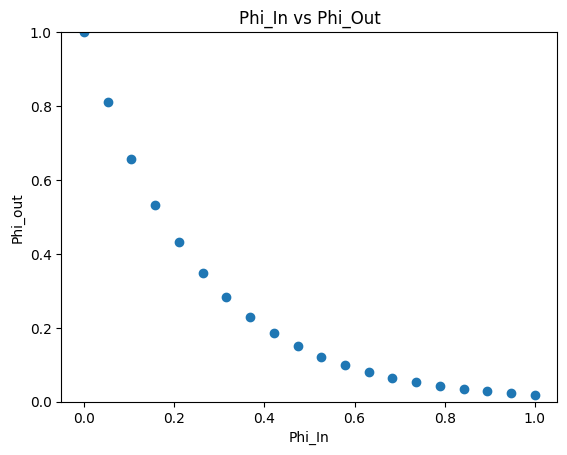

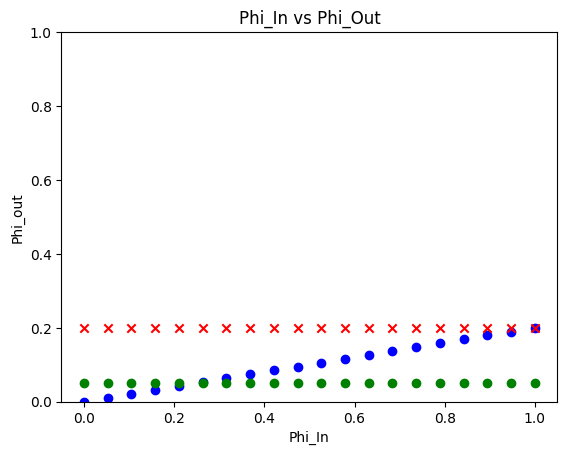

In [194]:
plt.scatter(norm_points, output_comp_points)

# Customize the plot
plt.title('Phi_In vs Phi_Out')
plt.xlabel('Phi_In')
plt.ylabel('Phi_out')
plt.ylim(0, 1)

# Show plot
plt.show()
# Create scatter plot for the first set of y-values
plt.scatter(norm_points,dilute_in_comp_points, label='Set 1', color='blue', marker='o')

# Create scatter plot for the second set of y-values
plt.scatter(norm_points, dilute_out_comp_points, label='Set 2', color='red', marker='x')
plt.scatter(norm_points, dilute_out_comp_arr[:,1], label='Set 3', color='green', marker='o')


# Customize the plot
plt.title('Phi_In vs Phi_Out')
plt.xlabel('Phi_In')
plt.ylabel('Phi_out')
plt.ylim(0, 1)

# Show plot
plt.show()

# Full Run Function: Plots for #N Hidden Components

Parameters: 
phi_in_thresh - phi_in threshold value 
phi_out - phi_out value
phi_H - array of Phi_H values
chi_strength - average strength of interactoin

num_of_points 

Returns plots of phi_in, phi_out, phi_H_1, phi_H_2 in the most dilute phase over the phase space 

In [423]:
def plot_and_evolve_components(phi_in_thresh, phi_out, phi_H, num_of_points,chi_strength):
    num_comps = len(phi_H) + 2
    #generate chi_matrix
    chi_matrix = gen.random_interaction_matrix(num_comps,chi_strength)
    #generate comp_points
    
    # picks all the phi_in points given the threshold
    phi_in_points = np.linspace(0,phi_in_thresh, num_of_points)
    phi_in_points = phi_in_points.reshape(num_of_points,1)
    # 
    phi_H_points = np.tile(phi_H, [num_of_points,1])
    out_array = phi_out*np.ones((num_of_points,1))
    # comp_points is all the points in the phase space that we are going to evolve
    comp_points = np.concatenate((phi_in_points, phi_H_points, out_array), axis = 1)
    print(comp_points)
    norm_points = np.linspace(0,1, num_of_points)

    #Time-Evolution Algorithm 
    #returns evolve_comp_points which has mixtures for each of the original points
    num_compartments = 16 
    # create the Flory-Huggins free energy
    fh_energy = mm.FloryHuggins(np.array(chi_matrix))
    
    evolve_comp_points = []
    for point in tqdm(comp_points):
        x = gen.evolve_phases_result(point,fh_energy,num_compartments)
        #print(x)
        evolve_comp_points.append(x)

    
    dilute_comp_points = []
    for result in evolve_comp_points:
        x = find_max_vol_phase(result,num_comps)
        dilute_comp_points.append(x)
    
    dilute_out_comp_arr = np.array(dilute_comp_points)

    test_plot = plots.plot_comp_volume_fraction_v2(dilute_out_comp_arr,output_readout_func)
    
   
    
    return dilute_out_comp_arr
    

    
            

[[0.         0.15       0.2        0.1       ]
 [0.01052632 0.15       0.2        0.1       ]
 [0.02105263 0.15       0.2        0.1       ]
 [0.03157895 0.15       0.2        0.1       ]
 [0.04210526 0.15       0.2        0.1       ]
 [0.05263158 0.15       0.2        0.1       ]
 [0.06315789 0.15       0.2        0.1       ]
 [0.07368421 0.15       0.2        0.1       ]
 [0.08421053 0.15       0.2        0.1       ]
 [0.09473684 0.15       0.2        0.1       ]
 [0.10526316 0.15       0.2        0.1       ]
 [0.11578947 0.15       0.2        0.1       ]
 [0.12631579 0.15       0.2        0.1       ]
 [0.13684211 0.15       0.2        0.1       ]
 [0.14736842 0.15       0.2        0.1       ]
 [0.15789474 0.15       0.2        0.1       ]
 [0.16842105 0.15       0.2        0.1       ]
 [0.17894737 0.15       0.2        0.1       ]
 [0.18947368 0.15       0.2        0.1       ]
 [0.2        0.15       0.2        0.1       ]]


100%|███████████████████████████████████████████| 20/20 [00:52<00:00,  2.61s/it]


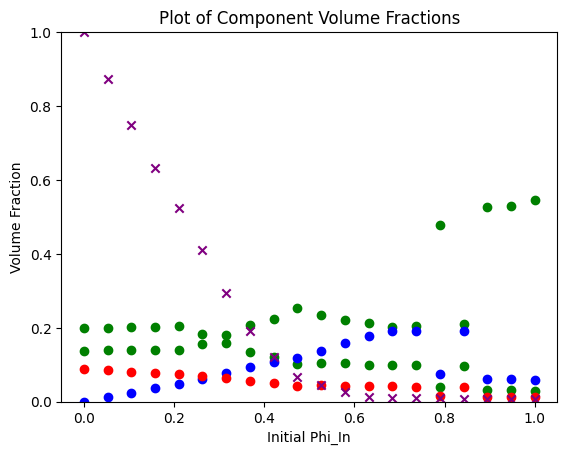

In [424]:
num_of_points = 10
phi_in_thresh = 0.2
phi_H = [0.15,0.2]
phi_out = 0.1
num_of_points = 20
chi_strength = 6
test_comp_arr = plot_and_evolve_components(phi_in_thresh, phi_out, phi_H, num_of_points,chi_strength)


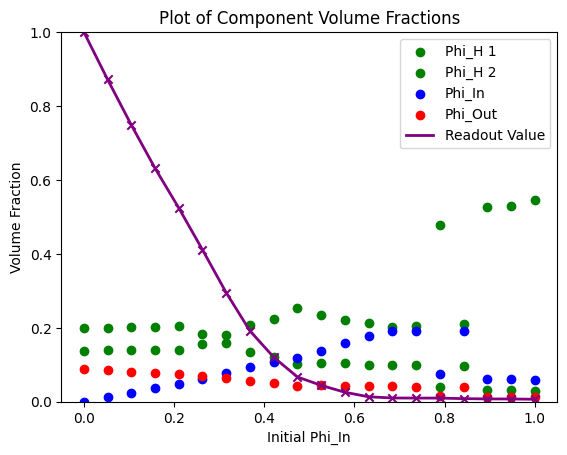

In [425]:
#plots.plot_comp_volume_fraction(test_comp_arr,output_readout_func)
plots.plot_comp_volume_fraction_v2(test_comp_arr,output_readout_func)

In [433]:
with open('/Users/calvinsmith/dufresne_lab/data/plot_data_TEST', 'rb') as f:
    fig = pl.load(f)


# Show the loaded figure
plt.show()

None


# Global Optimization of Hidden Components

Our goal is on how to optimize our phi_H vector such that it fits our function, in this case a step function. 

We rewrite our functions such that the only paramter it take is phi_H and we are testing what the best optimization method is using scipy.optimize: basinhopping, differential evolution or other?

In [434]:
'''Goal Function '''
def step_func(x):
    if x >= 0.5:
        return 0
    elif 0 <= x < 0.5:
        return 1
    else: 
        raise Exception("Sorry, no numbers below zero")
'''Calculate the Loss'''
def calc_loss(points):
    loss = 0
    for point in points:
        loss += (step_func(point[0]) - point[1])**2
    return loss







In [385]:
#Test to see if it works 
test = np.array([[0.0  ,       1.0        ],
 [0.2 ,       0.03552497],
 [0.4  ,      0.02405202],
 [0.6   ,     0.01836205],
 [0.8    ,    0.01383909],
 [1.      ,   0.01026018]])
print(test)
print(calc_loss(test))

[[0.         1.        ]
 [0.2        0.03552497]
 [0.4        0.02405202]
 [0.6        0.01836205]
 [0.8        0.01383909]
 [1.         0.01026018]]
4.017115670000001


In [327]:
# This function tells it whether it is in bounds so we don't always have to add constraints
#To the optimization function, makes it easier
def in_bounds(phi_H, phi_H_thresh):
    sum = 0
    for phi in phi_H:
        sum += phi
        if phi < 0:
            return False
    if sum > phi_H_thresh:
        return False
    else:
        return True

In [414]:

#Evolves Components, plots, and returns loss only takes on paramter to do optimization on it.
def evolve_components_loss(phi_H):
    phi_in_thresh = 0.2
    phi_H_thresh = 0.6
    phi_out = 0.1
    num_of_points = 6
    chi_strength = 6
    H_dim = 2
    readout_func = output_readout_func
    #generate comp_points
    num_comps = len(phi_H) + 2
    if in_bounds(phi_H,phi_H_thresh):
        # picks all the phi_in points given the threshold
        phi_in_points = np.linspace(0,phi_in_thresh, num_of_points)
        phi_in_points = phi_in_points.reshape(num_of_points,1)
        # 
        phi_H_points = np.tile(phi_H, [num_of_points,1])
        out_array = phi_out*np.ones((num_of_points,1))
        # comp_points is all the points in the phase space that we are going to evolve
        comp_points = np.concatenate((phi_in_points, phi_H_points, out_array), axis = 1)
        print("Points: ")
        print(comp_points)
        norm_points = np.linspace(0,1, num_of_points)
    
        #Time-Evolution Algorithm 
        #returns evolve_comp_points which has mixtures for each of the original points
        num_compartments = 16 
        # create the Flory-Huggins free energy
        fh_energy = mm.FloryHuggins(np.array(chi_matrix))
        
        evolve_comp_points = []
        for point in tqdm(comp_points):
            x = gen.evolve_phases_result(point,fh_energy,num_compartments)
            #print(x)
            evolve_comp_points.append(x)
    
        
        dilute_comp_points = []
        for result in evolve_comp_points:
            x = find_max_vol_phase(result,num_comps)
            dilute_comp_points.append(x)
        
        dilute_out_comp_arr = np.array(dilute_comp_points)
    
        plots.plot_comp_volume_fraction_v2(dilute_out_comp_arr, readout_func)
    
        output_comp_points = np.zeros((num_of_points,2))
        count = 0
        phi_init = np.linspace(0,1, num_of_points)
        for point in dilute_out_comp_arr:
            x = readout_func(point[0],point[-1])
            output_comp_points[count,:] = [phi_init[count],x]
            count+=1
        
        
        loss = calc_loss(output_comp_points)
        print(f"LOSS: {loss}")

        return loss
    else:
        #This is if it is out of bounds, supposed to disincentivize going out of bounds
        return 10000



[[0.         4.59582286 5.81859646 6.39822538 6.40251365]
 [4.59582286 0.         5.48601592 6.57303146 6.30083231]
 [5.81859646 5.48601592 0.         6.79663904 7.01012261]
 [6.39822538 6.57303146 6.79663904 0.         5.97333002]
 [6.40251365 6.30083231 7.01012261 5.97333002 0.        ]]
Points: 
[[0.   0.15 0.2  0.1  0.1 ]
 [0.04 0.15 0.2  0.1  0.1 ]
 [0.08 0.15 0.2  0.1  0.1 ]
 [0.12 0.15 0.2  0.1  0.1 ]
 [0.16 0.15 0.2  0.1  0.1 ]
 [0.2  0.15 0.2  0.1  0.1 ]]


100%|█████████████████████████████████████████████| 6/6 [00:18<00:00,  3.04s/it]


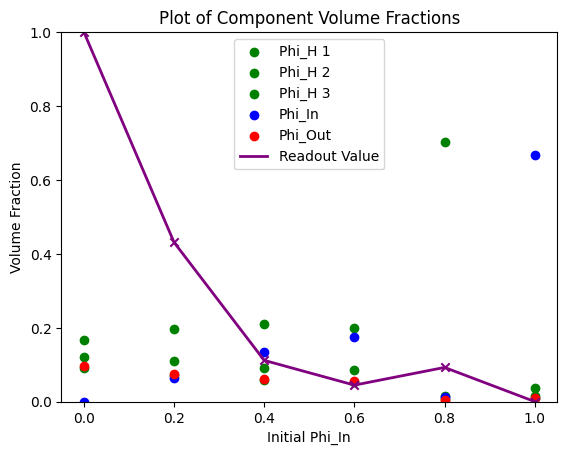

LOSS: 1.5942978737543738


In [415]:

phi_in_thresh = 0.2
phi_H = [0.15,0.2,0.1]
phi_out = 0.1
num_of_points = 6
chi_strength = 6
H_dim = len(phi_H)

num_comps = H_dim + 2
chi_matrix = gen.random_interaction_matrix(num_comps,chi_strength)
print(chi_matrix)
result = evolve_components_loss(phi_H)


Points: 
[[0.   0.2  0.1  0.1  0.1 ]
 [0.04 0.2  0.1  0.1  0.1 ]
 [0.08 0.2  0.1  0.1  0.1 ]
 [0.12 0.2  0.1  0.1  0.1 ]
 [0.16 0.2  0.1  0.1  0.1 ]
 [0.2  0.2  0.1  0.1  0.1 ]]


100%|█████████████████████████████████████████████| 6/6 [00:18<00:00,  3.06s/it]


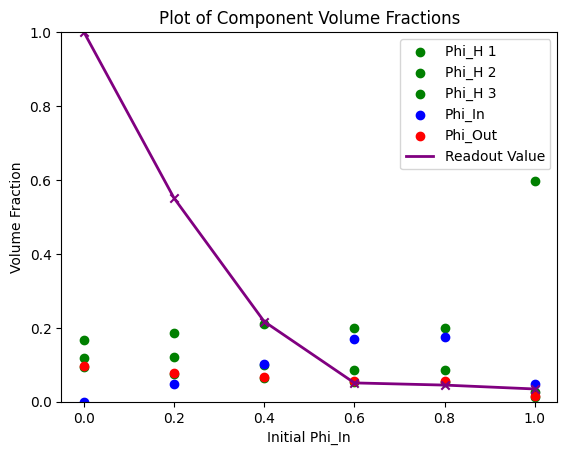

LOSS: 1.3619433449367098
Points: 
[[0.         0.20000001 0.1        0.1        0.1       ]
 [0.04       0.20000001 0.1        0.1        0.1       ]
 [0.08       0.20000001 0.1        0.1        0.1       ]
 [0.12       0.20000001 0.1        0.1        0.1       ]
 [0.16       0.20000001 0.1        0.1        0.1       ]
 [0.2        0.20000001 0.1        0.1        0.1       ]]


 50%|██████████████████████▌                      | 3/6 [00:12<00:12,  4.03s/it]


KeyboardInterrupt: 

In [416]:
init_H = [0.2,0.1,0.1]

result = basinhopping(evolve_components_loss,init_H,stepsize = 0.1)

Points: 
[[0.         0.3399887  0.01018156 0.04045744 0.1       ]
 [0.04       0.3399887  0.01018156 0.04045744 0.1       ]
 [0.08       0.3399887  0.01018156 0.04045744 0.1       ]
 [0.12       0.3399887  0.01018156 0.04045744 0.1       ]
 [0.16       0.3399887  0.01018156 0.04045744 0.1       ]
 [0.2        0.3399887  0.01018156 0.04045744 0.1       ]]


100%|█████████████████████████████████████████████| 6/6 [00:14<00:00,  2.45s/it]


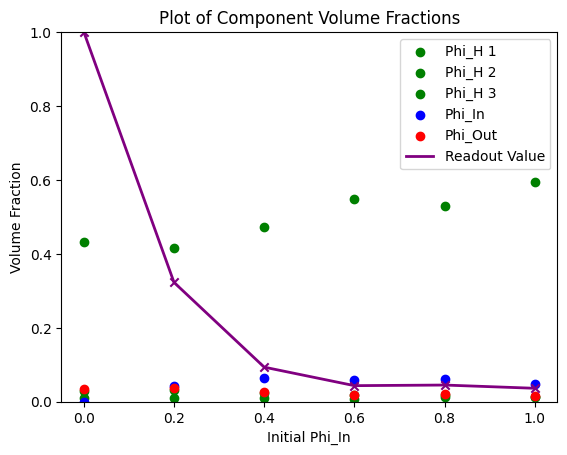

LOSS: 1.7081738036167464
Points: 
[[0.         0.07061388 0.0462726  0.16635173 0.1       ]
 [0.04       0.07061388 0.0462726  0.16635173 0.1       ]
 [0.08       0.07061388 0.0462726  0.16635173 0.1       ]
 [0.12       0.07061388 0.0462726  0.16635173 0.1       ]
 [0.16       0.07061388 0.0462726  0.16635173 0.1       ]
 [0.2        0.07061388 0.0462726  0.16635173 0.1       ]]


100%|█████████████████████████████████████████████| 6/6 [00:10<00:00,  1.72s/it]


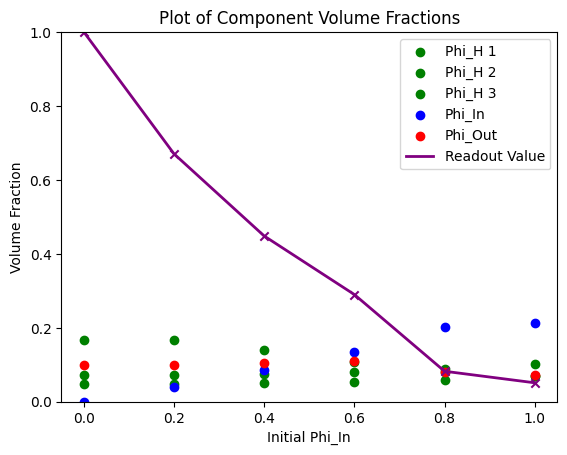

LOSS: 1.304119170119298
Points: 
[[0.         0.17349968 0.21931988 0.0820739  0.1       ]
 [0.04       0.17349968 0.21931988 0.0820739  0.1       ]
 [0.08       0.17349968 0.21931988 0.0820739  0.1       ]
 [0.12       0.17349968 0.21931988 0.0820739  0.1       ]
 [0.16       0.17349968 0.21931988 0.0820739  0.1       ]
 [0.2        0.17349968 0.21931988 0.0820739  0.1       ]]


100%|█████████████████████████████████████████████| 6/6 [00:15<00:00,  2.52s/it]


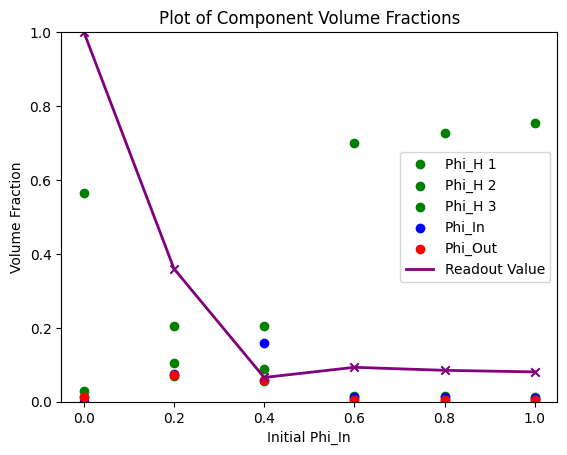

LOSS: 1.8329983551745463
Points: 
[[0.         0.00204197 0.37708171 0.11966129 0.1       ]
 [0.04       0.00204197 0.37708171 0.11966129 0.1       ]
 [0.08       0.00204197 0.37708171 0.11966129 0.1       ]
 [0.12       0.00204197 0.37708171 0.11966129 0.1       ]
 [0.16       0.00204197 0.37708171 0.11966129 0.1       ]
 [0.2        0.00204197 0.37708171 0.11966129 0.1       ]]


100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.13it/s]


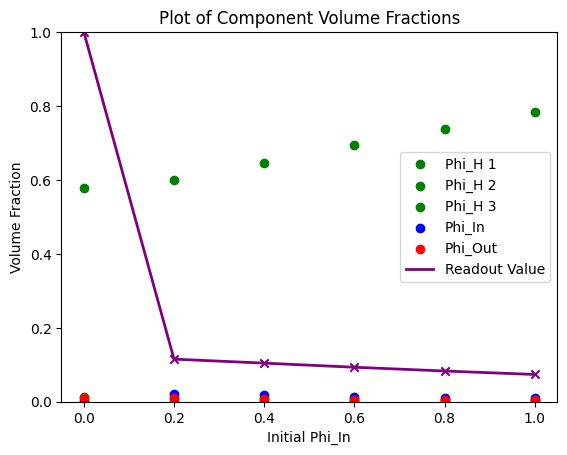

LOSS: 2.0300967028638235
Points: 
[[0.         0.10646468 0.16441528 0.1004525  0.1       ]
 [0.04       0.10646468 0.16441528 0.1004525  0.1       ]
 [0.08       0.10646468 0.16441528 0.1004525  0.1       ]
 [0.12       0.10646468 0.16441528 0.1004525  0.1       ]
 [0.16       0.10646468 0.16441528 0.1004525  0.1       ]
 [0.2        0.10646468 0.16441528 0.1004525  0.1       ]]


100%|█████████████████████████████████████████████| 6/6 [00:12<00:00,  2.14s/it]


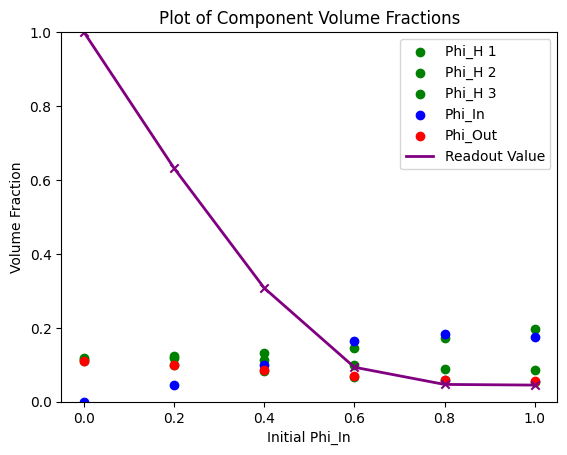

LOSS: 1.244871623897396
Points: 
[[0.         0.19513997 0.18423569 0.1207804  0.1       ]
 [0.04       0.19513997 0.18423569 0.1207804  0.1       ]
 [0.08       0.19513997 0.18423569 0.1207804  0.1       ]
 [0.12       0.19513997 0.18423569 0.1207804  0.1       ]
 [0.16       0.19513997 0.18423569 0.1207804  0.1       ]
 [0.2        0.19513997 0.18423569 0.1207804  0.1       ]]


100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.23s/it]


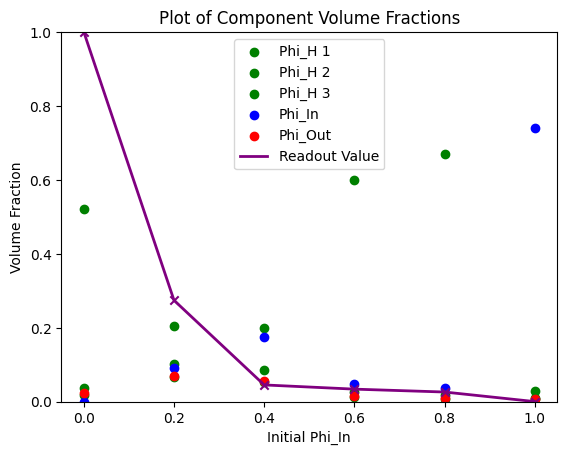

LOSS: 1.7404880021342592
Points: 
[[0.         0.06226277 0.37765703 0.15182075 0.1       ]
 [0.04       0.06226277 0.37765703 0.15182075 0.1       ]
 [0.08       0.06226277 0.37765703 0.15182075 0.1       ]
 [0.12       0.06226277 0.37765703 0.15182075 0.1       ]
 [0.16       0.06226277 0.37765703 0.15182075 0.1       ]
 [0.2        0.06226277 0.37765703 0.15182075 0.1       ]]


100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.29it/s]


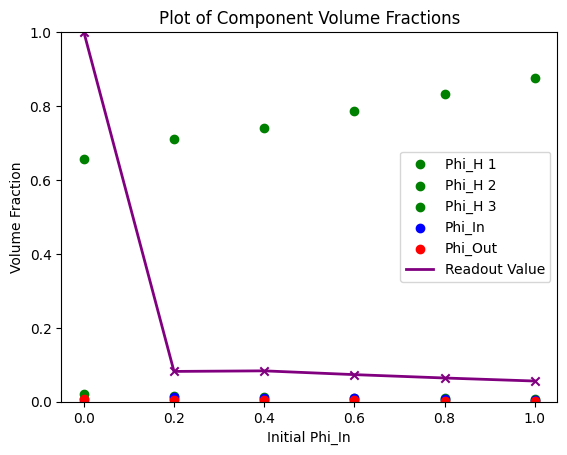

LOSS: 2.0276179900564384
Points: 
[[0.         0.17976447 0.16203128 0.20948747 0.1       ]
 [0.04       0.17976447 0.16203128 0.20948747 0.1       ]
 [0.08       0.17976447 0.16203128 0.20948747 0.1       ]
 [0.12       0.17976447 0.16203128 0.20948747 0.1       ]
 [0.16       0.17976447 0.16203128 0.20948747 0.1       ]
 [0.2        0.17976447 0.16203128 0.20948747 0.1       ]]


100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.21s/it]


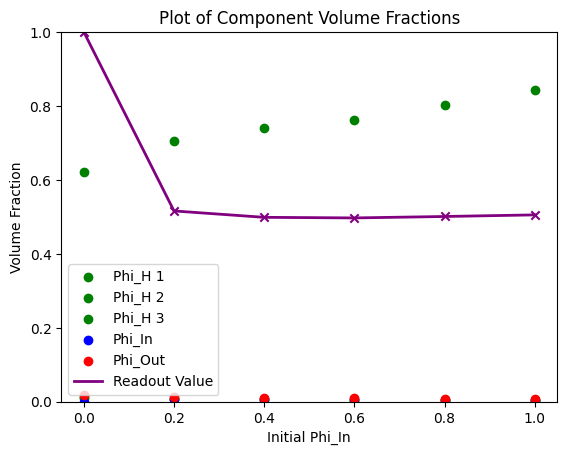

LOSS: 2.488521500120258
Points: 
[[0.         0.22856755 0.08903064 0.07283772 0.1       ]
 [0.04       0.22856755 0.08903064 0.07283772 0.1       ]
 [0.08       0.22856755 0.08903064 0.07283772 0.1       ]
 [0.12       0.22856755 0.08903064 0.07283772 0.1       ]
 [0.16       0.22856755 0.08903064 0.07283772 0.1       ]
 [0.2        0.22856755 0.08903064 0.07283772 0.1       ]]


100%|█████████████████████████████████████████████| 6/6 [00:18<00:00,  3.11s/it]


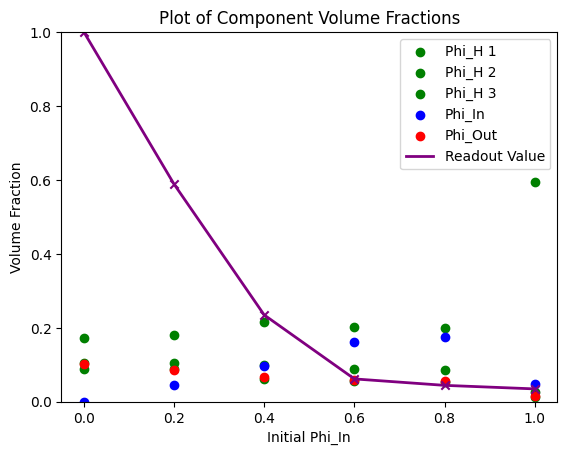

LOSS: 1.3166269062725307
Points: 
[[0.         0.23093693 0.04010546 0.10117388 0.1       ]
 [0.04       0.23093693 0.04010546 0.10117388 0.1       ]
 [0.08       0.23093693 0.04010546 0.10117388 0.1       ]
 [0.12       0.23093693 0.04010546 0.10117388 0.1       ]
 [0.16       0.23093693 0.04010546 0.10117388 0.1       ]
 [0.2        0.23093693 0.04010546 0.10117388 0.1       ]]


100%|█████████████████████████████████████████████| 6/6 [00:18<00:00,  3.11s/it]


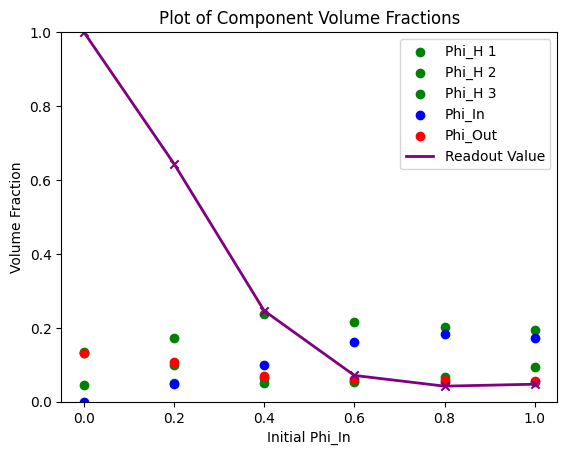

LOSS: 1.2703416965717487
Points: 
[[0.         0.07061388 0.19494257 0.16635173 0.1       ]
 [0.04       0.07061388 0.19494257 0.16635173 0.1       ]
 [0.08       0.07061388 0.19494257 0.16635173 0.1       ]
 [0.12       0.07061388 0.19494257 0.16635173 0.1       ]
 [0.16       0.07061388 0.19494257 0.16635173 0.1       ]
 [0.2        0.07061388 0.19494257 0.16635173 0.1       ]]


100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.30s/it]


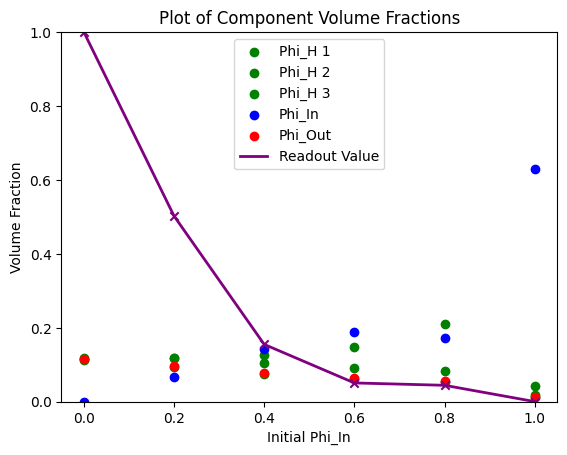

LOSS: 1.4374316118009043
Points: 
[[0.         0.26877148 0.05439334 0.13859018 0.1       ]
 [0.04       0.26877148 0.05439334 0.13859018 0.1       ]
 [0.08       0.26877148 0.05439334 0.13859018 0.1       ]
 [0.12       0.26877148 0.05439334 0.13859018 0.1       ]
 [0.16       0.26877148 0.05439334 0.13859018 0.1       ]
 [0.2        0.26877148 0.05439334 0.13859018 0.1       ]]


100%|█████████████████████████████████████████████| 6/6 [00:15<00:00,  2.65s/it]


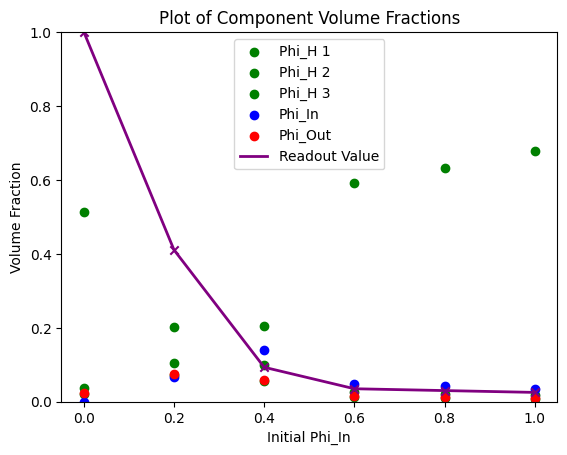

LOSS: 1.586059017504672
Points: 
[[0.         0.26045526 0.01062565 0.10134495 0.1       ]
 [0.04       0.26045526 0.01062565 0.10134495 0.1       ]
 [0.08       0.26045526 0.01062565 0.10134495 0.1       ]
 [0.12       0.26045526 0.01062565 0.10134495 0.1       ]
 [0.16       0.26045526 0.01062565 0.10134495 0.1       ]
 [0.2        0.26045526 0.01062565 0.10134495 0.1       ]]


 17%|███████▌                                     | 1/6 [00:05<00:26,  5.34s/it]


KeyboardInterrupt: 

In [417]:
bounds = [[0,1], [0,1], [0,1]]
result_DE = differential_evolution(evolve_components_loss,bounds = bounds, maxiter = 5, popsize = 6)

# Adding New Flory Code

In [489]:

chis = [[0, 4.0], [4.0, 0]]
phi_means = [0.9, 0.1]

phases = flory.find_coexisting_phases(2, chis, phi_means)

print("Volumes:", phases.volumes)
print("Compositions:", phases.fractions)

Incompressibility   :   0%|                             | 0/5.0 [00:00<?, ?it/s]
Field Error         :   0%|                             | 0/5.0 [00:00<?, ?it/s]

Volume Error        :   0%|                             | 0/5.0 [00:00<?, ?it/s]


Constraint Residue  :   0%|                             | 0/5.0 [00:00<?, ?it/s]



Incompressibility   :  84%|███████████████▉   | 4.2/5.0 [00:00<00:00, 91.32it/s]
Field Error         :  68%|████████████▉      | 3.4/5.0 [00:00<00:00, 77.79it/s]

Volume Error        :  64%|████████████▏      | 3.2/5.0 [00:00<00:00, 74.85it/s]


Constraint Residue  : 100%|██████████████████| 5.0/5.0 [00:00<00:00, 119.84it/s]



Revive Count Left   : 256



Incompressibility   : 100%|███████████████████| 5.0/5.0 [00:00<00:00, 69.58it/s]
Field Error         : 100%|███████████████████| 5.0/5.0 [00:00<00:00, 72.00it/s]

Volume Error        : 100%|███████████████████| 5.0/5.0 [00:00<00:00, 73.16it/s]


Constraint Residue  : 100%|███████████████████| 5.0/5.0 [00:00<00

Volumes: [0.91775276 0.08224724]
Compositions: [[0.97875207 0.02124792]
 [0.02124804 0.97875209]]


In [512]:
def evolve_components_flory(phi_in_thresh, phi_out, phi_H, num_of_points,chi_strength):
    num_comps = len(phi_H) + 2
    #generate chi_matrix
    chi_matrix = gen.chi_matrix_w_sol(num_comps,chi_strength)
    #generate comp_points
    print(chi_matrix)
    # picks all the phi_in points given the threshold
    phi_in_points = np.linspace(0,phi_in_thresh, num_of_points)
    phi_in_points = phi_in_points.reshape(num_of_points,1)
    # 
    phi_H_points = np.tile(phi_H, [num_of_points,1])
    out_array = phi_out*np.ones((num_of_points,1))
    # comp_points is all the points in the phase space that we are going to evolve
    comp_points = np.concatenate((phi_in_points, phi_H_points, out_array), axis = 1)
    #add solvent component
    phi_sol_points = []
    for phi_in in phi_in_points:
        phi_sol= 1 - (phi_in + phi_out + sum(phi_H)) 
        phi_sol_points.append(phi_sol)

    phi_sol_points = np.array(phi_sol_points)

    comp_points = np.concatenate((comp_points,phi_sol_points), axis = 1)
    print(comp_points)
    norm_points = np.linspace(0,1, num_of_points)
    
    
    
    evolved_comp_points = []
    for point in (comp_points):
        phase = flory.find_coexisting_phases(num_comps+1,chi_matrix,point, progress = False)
        evolved_comp_points.append(phase)

    
    dilute_comp_points = []
    for phase in evolved_comp_points:
        x = gen.most_dilute_flory(phase)
        dilute_comp_points.append(x)
    
    dilute_out_comp_arr = np.array(dilute_comp_points)

    test_plot = plots.plot_comp_volume_fraction_v2(dilute_out_comp_arr,output_readout_func)

    
    return dilute_out_comp_arr
    

    
            

In [518]:
def evolve_components_flory_loss(phi_H):
    phi_in_thresh = 0.2
    phi_H_thresh = 0.6
    phi_out = 0.1
    num_of_points = 6
    chi_strength = 6
    H_dim = 2
    readout_func = output_readout_func
    

    if in_bounds(phi_H,phi_H_thresh):
        print("IN BOUNDS")
        results = evolve_components_flory(phi_in_thresh, phi_out, phi_H, num_of_points,chi_strength)
        output_comp_points = np.zeros((num_of_points,2))
        count = 0
        phi_init = np.linspace(0,1, num_of_points)
        for point in results:
            x = readout_func(point[0],point[-2])
            output_comp_points[count,:] = [phi_init[count],x]
            count+=1
        
        
        loss = calc_loss(output_comp_points)
        print(f"LOSS: {loss}")

        return loss
    else:
        #This is if it is out of bounds, supposed to disincentivize going out of bounds
        print("OUT OF BOUNDS")
        return 10000


[[0.         3.81879947 5.41067787 4.26549782 0.        ]
 [3.81879947 0.         6.5672016  3.50714383 0.        ]
 [5.41067787 6.5672016  0.         6.98967428 0.        ]
 [4.26549782 3.50714383 6.98967428 0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
[[0.         0.3        0.4        0.1        0.2       ]
 [0.02222222 0.3        0.4        0.1        0.17777778]
 [0.04444444 0.3        0.4        0.1        0.15555556]
 [0.06666667 0.3        0.4        0.1        0.13333333]
 [0.08888889 0.3        0.4        0.1        0.11111111]
 [0.11111111 0.3        0.4        0.1        0.08888889]
 [0.13333333 0.3        0.4        0.1        0.06666667]
 [0.15555556 0.3        0.4        0.1        0.04444444]
 [0.17777778 0.3        0.4        0.1        0.02222222]
 [0.2        0.3        0.4        0.1        0.        ]]


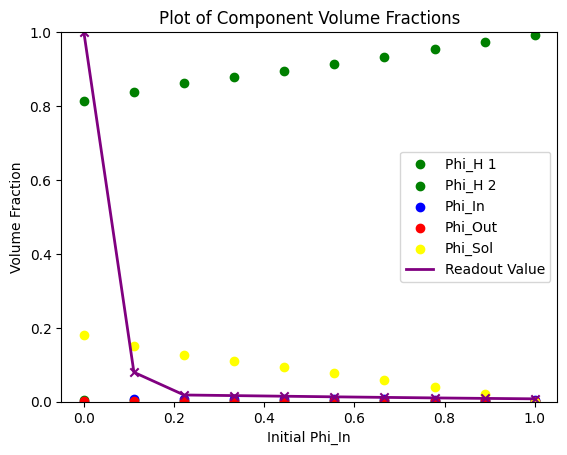

In [519]:
test = evolve_components_flory(0.2,0.1,[0.3,0.4],10,5)

OUT OF BOUNDS
OUT OF BOUNDS
OUT OF BOUNDS
OUT OF BOUNDS
OUT OF BOUNDS
OUT OF BOUNDS
OUT OF BOUNDS
OUT OF BOUNDS
IN BOUNDS
[[0.         7.42547493 6.26351852 6.21188254 4.41401496 0.        ]
 [7.42547493 0.         6.49260636 7.57317787 6.02895182 0.        ]
 [6.26351852 6.49260636 0.         6.05493145 6.58011754 0.        ]
 [6.21188254 7.57317787 6.05493145 0.         4.84203557 0.        ]
 [4.41401496 6.02895182 6.58011754 4.84203557 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.10946182 0.12064787 0.04727661 0.1        0.6226137 ]
 [0.04       0.10946182 0.12064787 0.04727661 0.1        0.5826137 ]
 [0.08       0.10946182 0.12064787 0.04727661 0.1        0.5426137 ]
 [0.12       0.10946182 0.12064787 0.04727661 0.1        0.5026137 ]
 [0.16       0.10946182 0.12064787 0.04727661 0.1        0.4626137 ]
 [0.2        0.10946182 0.12064787 0.04727661 0.1        0.4226137 ]]


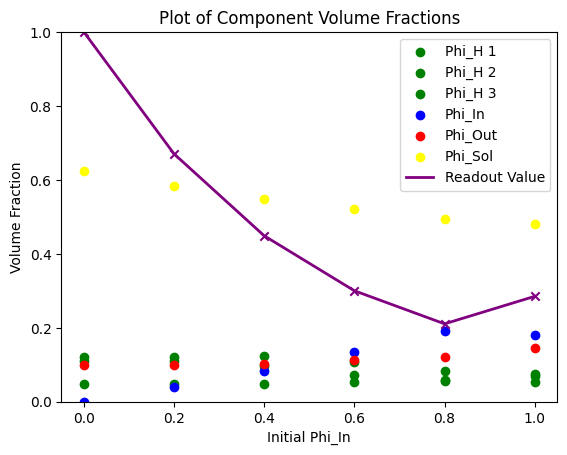

LOSS: 0.6279719559239598
IN BOUNDS
[[0.         6.03515828 5.26998411 3.59640506 5.03145316 0.        ]
 [6.03515828 0.         5.62739356 3.97133949 7.34645101 0.        ]
 [5.26998411 5.62739356 0.         6.69500402 6.29879923 0.        ]
 [3.59640506 3.97133949 6.69500402 0.         5.49431914 0.        ]
 [5.03145316 7.34645101 6.29879923 5.49431914 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.20178302 0.03850863 0.17368274 0.1        0.48602561]
 [0.04       0.20178302 0.03850863 0.17368274 0.1        0.44602561]
 [0.08       0.20178302 0.03850863 0.17368274 0.1        0.40602561]
 [0.12       0.20178302 0.03850863 0.17368274 0.1        0.36602561]
 [0.16       0.20178302 0.03850863 0.17368274 0.1        0.32602561]
 [0.2        0.20178302 0.03850863 0.17368274 0.1        0.28602561]]


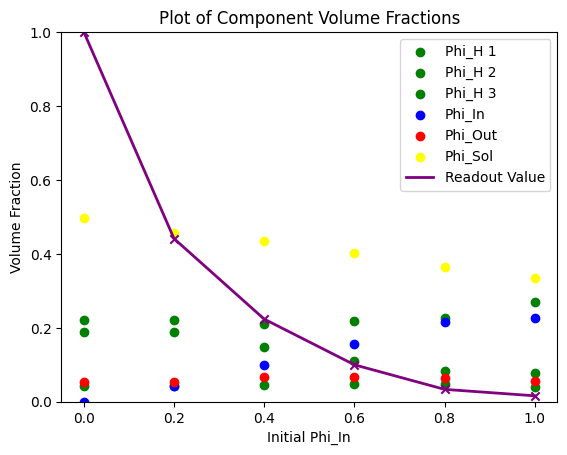

LOSS: 0.9271497051635617
OUT OF BOUNDS
IN BOUNDS
[[0.         6.86165413 6.40133975 4.97681821 6.00578054 0.        ]
 [6.86165413 0.         5.77736385 5.60574871 5.51796536 0.        ]
 [6.40133975 5.77736385 0.         7.78506295 5.71219629 0.        ]
 [4.97681821 5.60574871 7.78506295 0.         6.99843426 0.        ]
 [6.00578054 5.51796536 5.71219629 6.99843426 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.03581753 0.08498709 0.40917646 0.1        0.37001892]
 [0.04       0.03581753 0.08498709 0.40917646 0.1        0.33001892]
 [0.08       0.03581753 0.08498709 0.40917646 0.1        0.29001892]
 [0.12       0.03581753 0.08498709 0.40917646 0.1        0.25001892]
 [0.16       0.03581753 0.08498709 0.40917646 0.1        0.21001892]
 [0.2        0.03581753 0.08498709 0.40917646 0.1        0.17001892]]


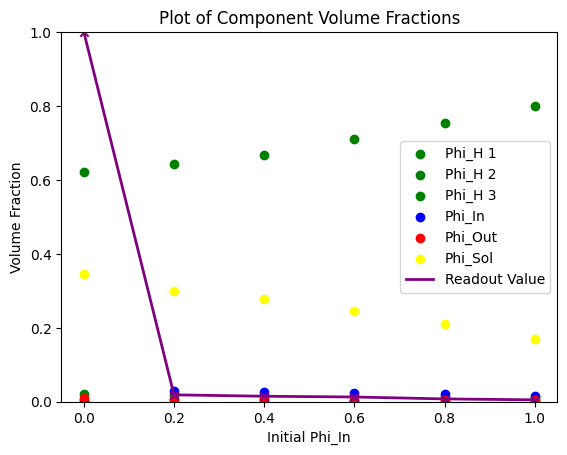

LOSS: 1.935349383776433
IN BOUNDS
[[0.         6.30372367 5.77731862 5.73414833 4.8547693  0.        ]
 [6.30372367 0.         5.24561052 6.5211791  5.73019932 0.        ]
 [5.77731862 5.24561052 0.         4.83834404 5.45627794 0.        ]
 [5.73414833 6.5211791  4.83834404 0.         5.81535222 0.        ]
 [4.8547693  5.73019932 5.45627794 5.81535222 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.10838469 0.07201314 0.04727661 0.1        0.67232556]
 [0.04       0.10838469 0.07201314 0.04727661 0.1        0.63232556]
 [0.08       0.10838469 0.07201314 0.04727661 0.1        0.59232556]
 [0.12       0.10838469 0.07201314 0.04727661 0.1        0.55232556]
 [0.16       0.10838469 0.07201314 0.04727661 0.1        0.51232556]
 [0.2        0.10838469 0.07201314 0.04727661 0.1        0.47232556]]


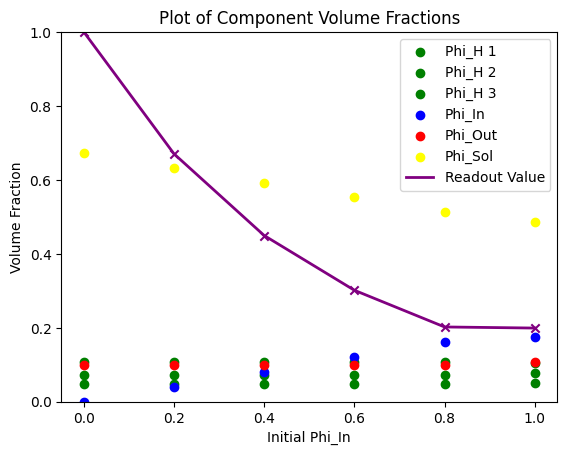

LOSS: 0.5829784934357016
OUT OF BOUNDS
OUT OF BOUNDS
IN BOUNDS
[[0.         4.83973415 5.63509075 6.04678379 6.11948319 0.        ]
 [4.83973415 0.         6.84778777 5.16997325 4.95591783 0.        ]
 [5.63509075 6.84778777 0.         7.0693583  6.09471767 0.        ]
 [6.04678379 5.16997325 7.0693583  0.         5.887977   0.        ]
 [6.11948319 4.95591783 6.09471767 5.887977   0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.20178302 0.00721099 0.06221209 0.1        0.6287939 ]
 [0.04       0.20178302 0.00721099 0.06221209 0.1        0.5887939 ]
 [0.08       0.20178302 0.00721099 0.06221209 0.1        0.5487939 ]
 [0.12       0.20178302 0.00721099 0.06221209 0.1        0.5087939 ]
 [0.16       0.20178302 0.00721099 0.06221209 0.1        0.4687939 ]
 [0.2        0.20178302 0.00721099 0.06221209 0.1        0.4287939 ]]


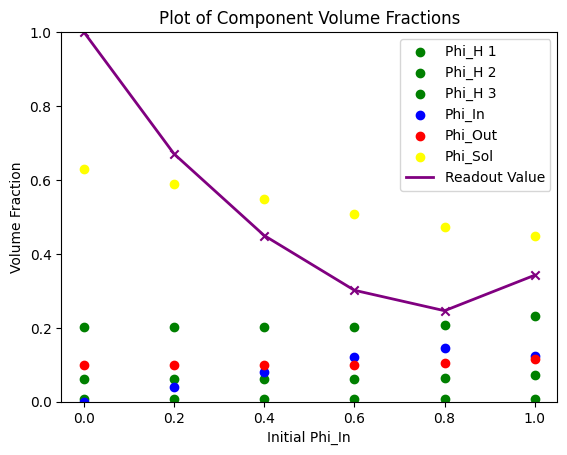

LOSS: 0.6800004923017606
IN BOUNDS
[[0.         6.55519234 6.01514408 6.4875232  7.15776859 0.        ]
 [6.55519234 0.         6.49371863 3.80794348 7.09600703 0.        ]
 [6.01514408 6.49371863 0.         5.43616535 6.95482128 0.        ]
 [6.4875232  3.80794348 5.43616535 0.         6.79563349 0.        ]
 [7.15776859 7.09600703 6.95482128 6.79563349 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.16498721 0.06189343 0.07107683 0.1        0.60204253]
 [0.04       0.16498721 0.06189343 0.07107683 0.1        0.56204253]
 [0.08       0.16498721 0.06189343 0.07107683 0.1        0.52204253]
 [0.12       0.16498721 0.06189343 0.07107683 0.1        0.48204253]
 [0.16       0.16498721 0.06189343 0.07107683 0.1        0.44204253]
 [0.2        0.16498721 0.06189343 0.07107683 0.1        0.40204253]]


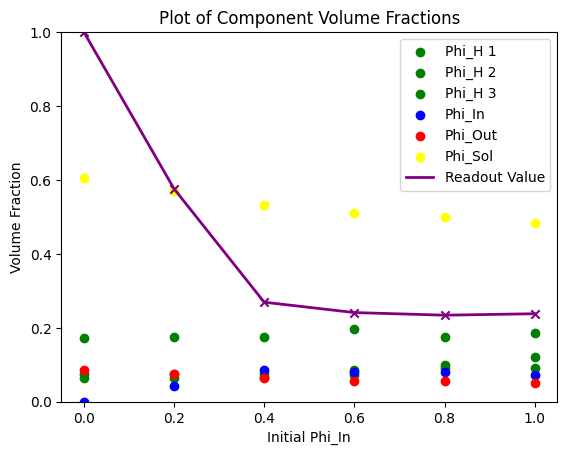

LOSS: 0.8834504754236957
OUT OF BOUNDS
IN BOUNDS
[[0.         6.33301659 6.80857732 6.61388199 6.1681349  0.        ]
 [6.33301659 0.         7.34699649 6.68033504 5.74127617 0.        ]
 [6.80857732 7.34699649 0.         4.52807971 5.98076942 0.        ]
 [6.61388199 6.68033504 4.52807971 0.         6.3708079  0.        ]
 [6.1681349  5.74127617 5.98076942 6.3708079  0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.20723184 0.0543407  0.04727661 0.1        0.59115084]
 [0.04       0.20723184 0.0543407  0.04727661 0.1        0.55115084]
 [0.08       0.20723184 0.0543407  0.04727661 0.1        0.51115084]
 [0.12       0.20723184 0.0543407  0.04727661 0.1        0.47115084]
 [0.16       0.20723184 0.0543407  0.04727661 0.1        0.43115084]
 [0.2        0.20723184 0.0543407  0.04727661 0.1        0.39115084]]


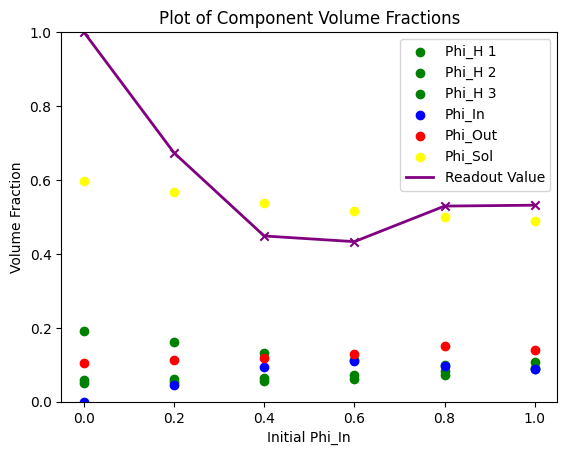

LOSS: 1.160862244137215
OUT OF BOUNDS
IN BOUNDS
[[0.         7.27295341 5.05674951 7.44094542 6.87901888 0.        ]
 [7.27295341 0.         5.79950999 5.21407773 5.7593577  0.        ]
 [5.05674951 5.79950999 0.         5.32807354 7.66325602 0.        ]
 [7.44094542 5.21407773 5.32807354 0.         5.23670769 0.        ]
 [6.87901888 5.7593577  7.66325602 5.23670769 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.16854174 0.25120037 0.17885237 0.1        0.30140552]
 [0.04       0.16854174 0.25120037 0.17885237 0.1        0.26140552]
 [0.08       0.16854174 0.25120037 0.17885237 0.1        0.22140552]
 [0.12       0.16854174 0.25120037 0.17885237 0.1        0.18140552]
 [0.16       0.16854174 0.25120037 0.17885237 0.1        0.14140552]
 [0.2        0.16854174 0.25120037 0.17885237 0.1        0.10140552]]


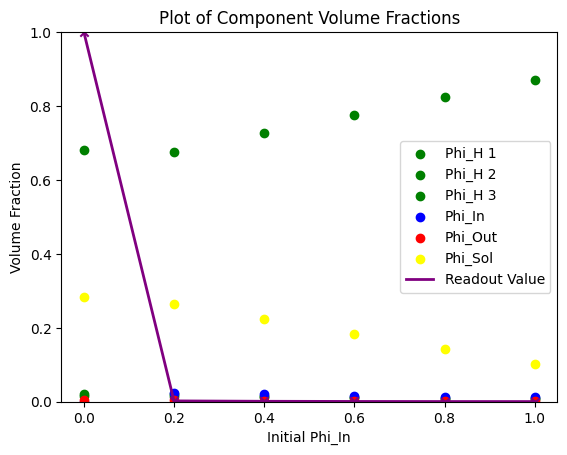

LOSS: 1.9947221734264382
IN BOUNDS
[[0.         6.3378166  4.71940044 6.30125425 4.90021769 0.        ]
 [6.3378166  0.         6.05703865 4.32754809 6.77365493 0.        ]
 [4.71940044 6.05703865 0.         3.76119079 5.72282333 0.        ]
 [6.30125425 4.32754809 3.76119079 0.         5.03590576 0.        ]
 [4.90021769 6.77365493 5.72282333 5.03590576 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.20995195 0.19920791 0.06221209 0.1        0.42862805]
 [0.04       0.20995195 0.19920791 0.06221209 0.1        0.38862805]
 [0.08       0.20995195 0.19920791 0.06221209 0.1        0.34862805]
 [0.12       0.20995195 0.19920791 0.06221209 0.1        0.30862805]
 [0.16       0.20995195 0.19920791 0.06221209 0.1        0.26862805]
 [0.2        0.20995195 0.19920791 0.06221209 0.1        0.22862805]]


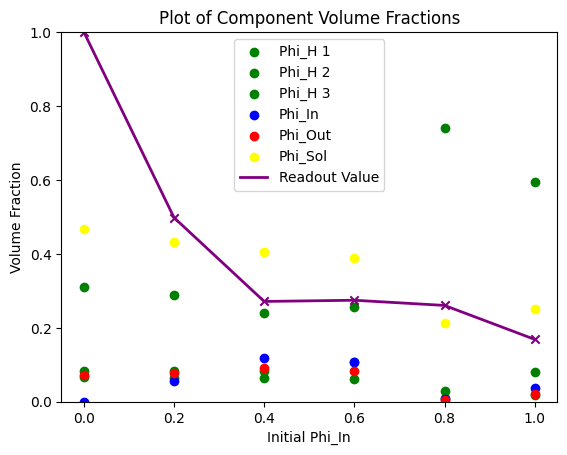

LOSS: 0.9548833740049371
IN BOUNDS
[[0.         5.9582849  6.01521839 6.40672988 4.97281008 0.        ]
 [5.9582849  0.         5.66848179 5.9830871  6.6285422  0.        ]
 [6.01521839 5.66848179 0.         6.65732733 5.80538994 0.        ]
 [6.40672988 5.9830871  6.65732733 0.         6.10471743 0.        ]
 [4.97281008 6.6285422  5.80538994 6.10471743 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.1544199  0.20913624 0.14796502 0.1        0.38847885]
 [0.04       0.1544199  0.20913624 0.14796502 0.1        0.34847885]
 [0.08       0.1544199  0.20913624 0.14796502 0.1        0.30847885]
 [0.12       0.1544199  0.20913624 0.14796502 0.1        0.26847885]
 [0.16       0.1544199  0.20913624 0.14796502 0.1        0.22847885]
 [0.2        0.1544199  0.20913624 0.14796502 0.1        0.18847885]]


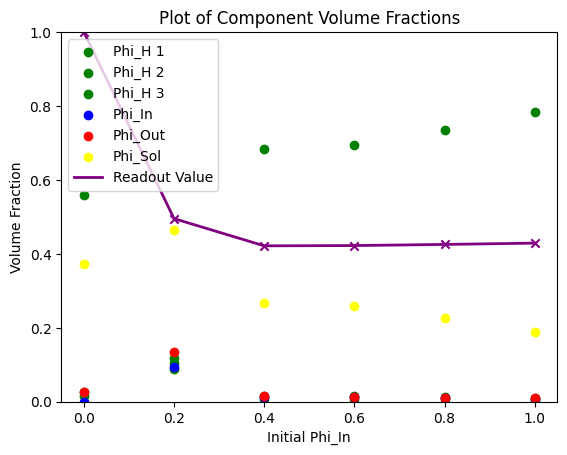

LOSS: 1.1325017885802862
IN BOUNDS
[[0.         6.96745235 6.26392281 3.78543895 6.6487047  0.        ]
 [6.96745235 0.         7.11560962 4.77960725 6.28681818 0.        ]
 [6.26392281 7.11560962 0.         6.21089003 6.2400264  0.        ]
 [3.78543895 4.77960725 6.21089003 0.         6.47189676 0.        ]
 [6.6487047  6.28681818 6.2400264  6.47189676 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.18402752 0.0584893  0.32984446 0.1        0.32763873]
 [0.04       0.18402752 0.0584893  0.32984446 0.1        0.28763873]
 [0.08       0.18402752 0.0584893  0.32984446 0.1        0.24763873]
 [0.12       0.18402752 0.0584893  0.32984446 0.1        0.20763873]
 [0.16       0.18402752 0.0584893  0.32984446 0.1        0.16763873]
 [0.2        0.18402752 0.0584893  0.32984446 0.1        0.12763873]]


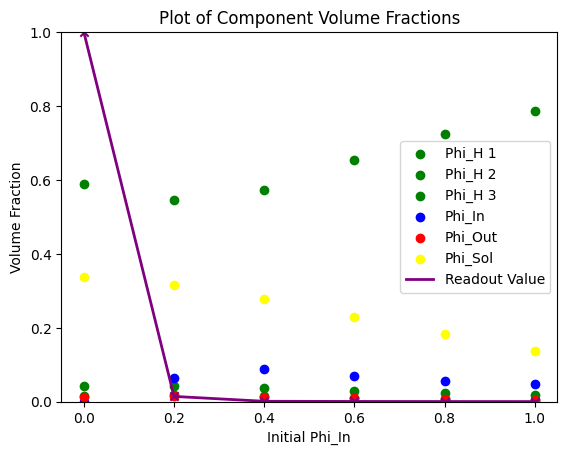

LOSS: 1.9705958713995984
IN BOUNDS
[[0.         5.21299569 6.69825203 3.2271633  7.35397472 0.        ]
 [5.21299569 0.         7.80591741 5.29560661 6.22644565 0.        ]
 [6.69825203 7.80591741 0.         5.4138172  7.1536215  0.        ]
 [3.2271633  5.29560661 5.4138172  0.         6.68953487 0.        ]
 [7.35397472 6.22644565 7.1536215  6.68953487 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.10838469 0.07201314 0.35865991 0.1        0.36094227]
 [0.04       0.10838469 0.07201314 0.35865991 0.1        0.32094227]
 [0.08       0.10838469 0.07201314 0.35865991 0.1        0.28094227]
 [0.12       0.10838469 0.07201314 0.35865991 0.1        0.24094227]
 [0.16       0.10838469 0.07201314 0.35865991 0.1        0.20094227]
 [0.2        0.10838469 0.07201314 0.35865991 0.1        0.16094227]]


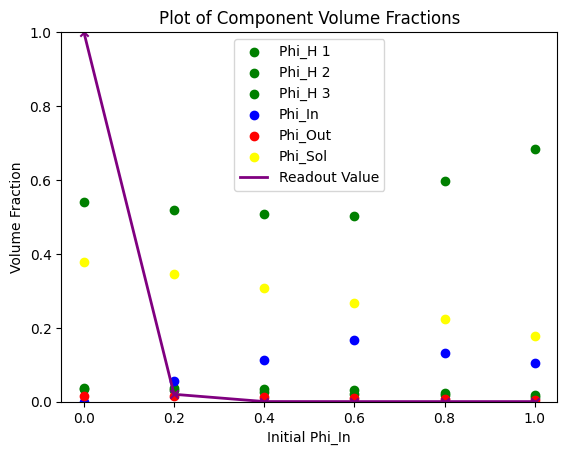

LOSS: 1.9606901277785265
IN BOUNDS
[[0.         6.83375463 5.18512712 7.95967605 5.61758943 0.        ]
 [6.83375463 0.         6.15090003 5.70246089 4.87770503 0.        ]
 [5.18512712 6.15090003 0.         5.37939558 5.13480335 0.        ]
 [7.95967605 5.70246089 5.37939558 0.         5.9358274  0.        ]
 [5.61758943 4.87770503 5.13480335 5.9358274  0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.08089243 0.27380497 0.14374416 0.1        0.40155843]
 [0.04       0.08089243 0.27380497 0.14374416 0.1        0.36155843]
 [0.08       0.08089243 0.27380497 0.14374416 0.1        0.32155843]
 [0.12       0.08089243 0.27380497 0.14374416 0.1        0.28155843]
 [0.16       0.08089243 0.27380497 0.14374416 0.1        0.24155843]
 [0.2        0.08089243 0.27380497 0.14374416 0.1        0.20155843]]


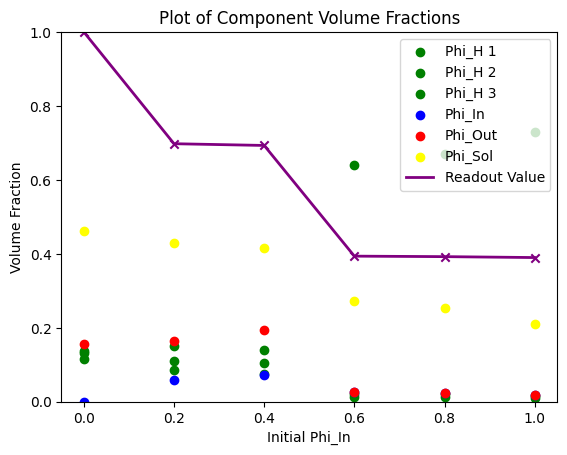

LOSS: 0.6461297893428037
IN BOUNDS
[[0.         6.00104061 6.38976854 5.55928886 8.02269642 0.        ]
 [6.00104061 0.         5.31027909 6.05384101 3.37759329 0.        ]
 [6.38976854 5.31027909 0.         7.1622888  4.45176925 0.        ]
 [5.55928886 6.05384101 7.1622888  0.         4.41514853 0.        ]
 [8.02269642 3.37759329 4.45176925 4.41514853 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.00840192 0.29250015 0.17885237 0.1        0.42024556]
 [0.04       0.00840192 0.29250015 0.17885237 0.1        0.38024556]
 [0.08       0.00840192 0.29250015 0.17885237 0.1        0.34024556]
 [0.12       0.00840192 0.29250015 0.17885237 0.1        0.30024556]
 [0.16       0.00840192 0.29250015 0.17885237 0.1        0.26024556]
 [0.2        0.00840192 0.29250015 0.17885237 0.1        0.22024556]]


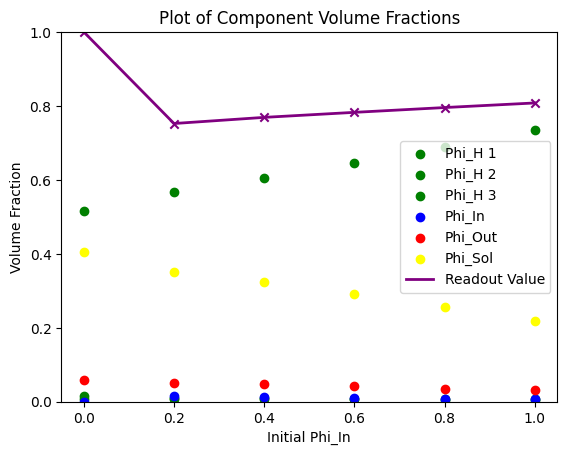

LOSS: 2.0127488560170192
IN BOUNDS
[[0.         6.76410491 7.34476183 6.51627371 5.84518494 0.        ]
 [6.76410491 0.         7.53433386 5.14283083 6.59813559 0.        ]
 [7.34476183 7.53433386 0.         5.39173728 5.40455409 0.        ]
 [6.51627371 5.14283083 5.39173728 0.         6.60705769 0.        ]
 [5.84518494 6.59813559 5.40455409 6.60705769 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.04836789 0.08274327 0.06221209 0.1        0.70667675]
 [0.04       0.04836789 0.08274327 0.06221209 0.1        0.66667675]
 [0.08       0.04836789 0.08274327 0.06221209 0.1        0.62667675]
 [0.12       0.04836789 0.08274327 0.06221209 0.1        0.58667675]
 [0.16       0.04836789 0.08274327 0.06221209 0.1        0.54667675]
 [0.2        0.04836789 0.08274327 0.06221209 0.1        0.50667675]]


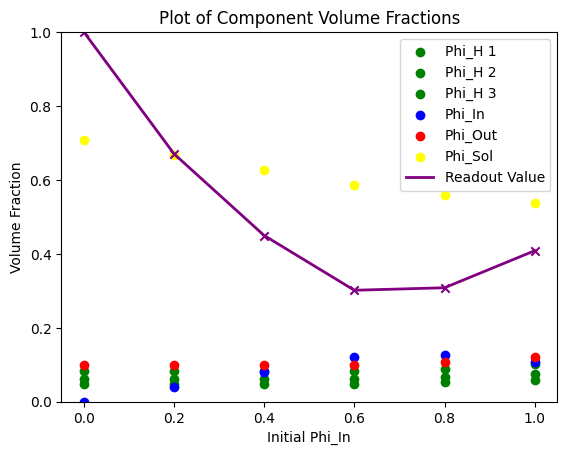

LOSS: 0.7641376417144586
IN BOUNDS
[[0.         4.75550618 5.7658742  7.16487719 4.12038789 0.        ]
 [4.75550618 0.         4.20196868 4.24044015 6.4640245  0.        ]
 [5.7658742  4.20196868 0.         4.55647346 2.44276798 0.        ]
 [7.16487719 4.24044015 4.55647346 0.         4.4175121  0.        ]
 [4.12038789 6.4640245  2.44276798 4.4175121  0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.16498721 0.22817529 0.03289884 0.1        0.47393866]
 [0.04       0.16498721 0.22817529 0.03289884 0.1        0.43393866]
 [0.08       0.16498721 0.22817529 0.03289884 0.1        0.39393866]
 [0.12       0.16498721 0.22817529 0.03289884 0.1        0.35393866]
 [0.16       0.16498721 0.22817529 0.03289884 0.1        0.31393866]
 [0.2        0.16498721 0.22817529 0.03289884 0.1        0.27393866]]


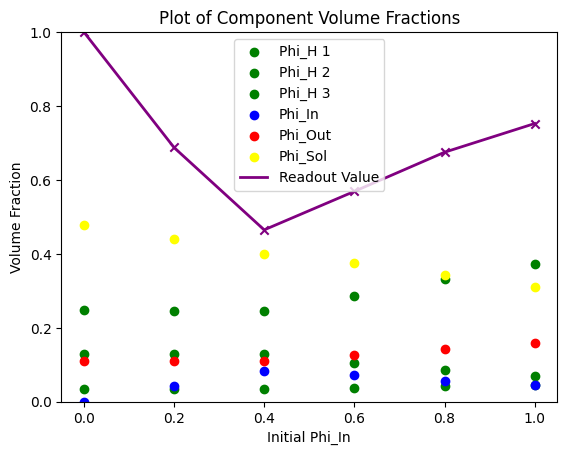

LOSS: 1.7290209699032335
IN BOUNDS
[[0.         7.45333734 6.76175288 4.58484603 6.99327482 0.        ]
 [7.45333734 0.         4.54822623 5.79748462 6.12827689 0.        ]
 [6.76175288 4.54822623 0.         5.28689234 7.17650637 0.        ]
 [4.58484603 5.79748462 5.28689234 0.         6.45804093 0.        ]
 [6.99327482 6.12827689 7.17650637 6.45804093 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.11132447 0.22857977 0.13641256 0.1        0.4236832 ]
 [0.04       0.11132447 0.22857977 0.13641256 0.1        0.3836832 ]
 [0.08       0.11132447 0.22857977 0.13641256 0.1        0.3436832 ]
 [0.12       0.11132447 0.22857977 0.13641256 0.1        0.3036832 ]
 [0.16       0.11132447 0.22857977 0.13641256 0.1        0.2636832 ]
 [0.2        0.11132447 0.22857977 0.13641256 0.1        0.2236832 ]]


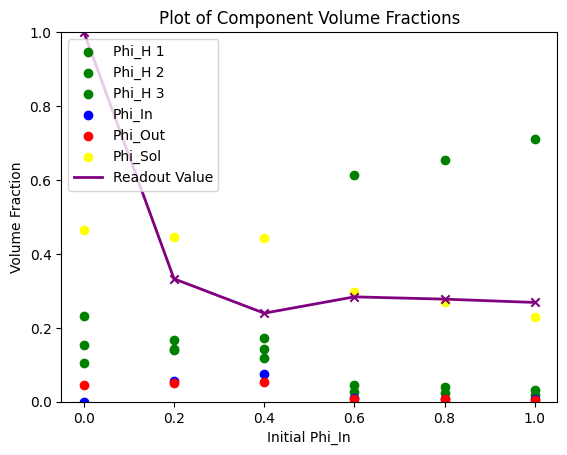

LOSS: 1.2538685660668156
IN BOUNDS
[[0.         6.8539264  8.31994216 4.67509608 7.77830571 0.        ]
 [6.8539264  0.         8.26474677 7.29724506 5.91373348 0.        ]
 [8.31994216 8.26474677 0.         8.89223821 6.79563408 0.        ]
 [4.67509608 7.29724506 8.89223821 0.         7.63127984 0.        ]
 [7.77830571 5.91373348 6.79563408 7.63127984 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.11061947 0.19103274 0.11503642 0.1        0.48331137]
 [0.04       0.11061947 0.19103274 0.11503642 0.1        0.44331137]
 [0.08       0.11061947 0.19103274 0.11503642 0.1        0.40331137]
 [0.12       0.11061947 0.19103274 0.11503642 0.1        0.36331137]
 [0.16       0.11061947 0.19103274 0.11503642 0.1        0.32331137]
 [0.2        0.11061947 0.19103274 0.11503642 0.1        0.28331137]]


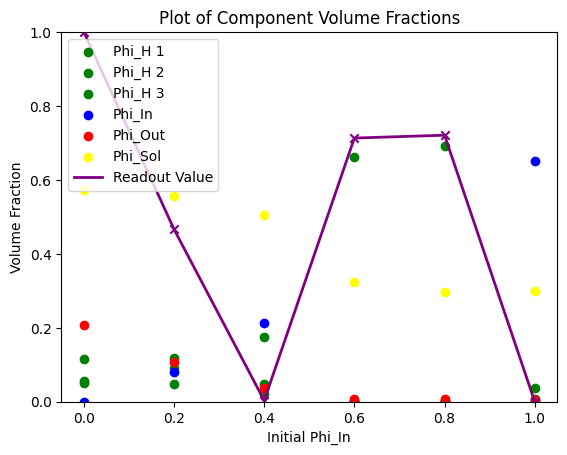

LOSS: 2.3069514191907317
IN BOUNDS
[[0.         5.48664405 7.5456471  6.2517814  6.35276835 0.        ]
 [5.48664405 0.         5.80764664 4.70273201 4.52761766 0.        ]
 [7.5456471  5.80764664 0.         4.83458687 5.82944502 0.        ]
 [6.2517814  4.70273201 4.83458687 0.         7.83333022 0.        ]
 [6.35276835 4.52761766 5.82944502 7.83333022 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.13151867 0.03763362 0.04170323 0.1        0.68914448]
 [0.04       0.13151867 0.03763362 0.04170323 0.1        0.64914448]
 [0.08       0.13151867 0.03763362 0.04170323 0.1        0.60914448]
 [0.12       0.13151867 0.03763362 0.04170323 0.1        0.56914448]
 [0.16       0.13151867 0.03763362 0.04170323 0.1        0.52914448]
 [0.2        0.13151867 0.03763362 0.04170323 0.1        0.48914448]]


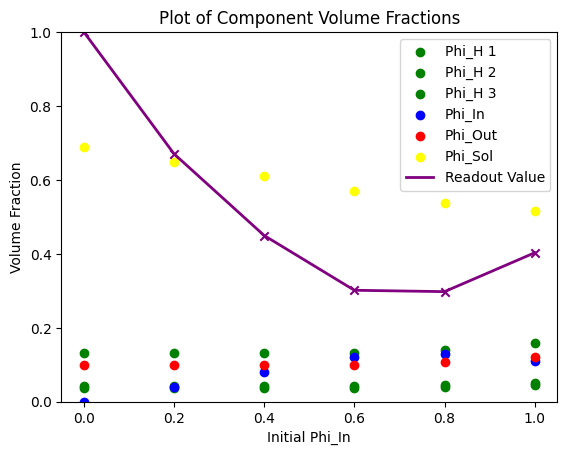

LOSS: 0.7533197673123928
IN BOUNDS
[[0.         5.11105193 5.72817633 5.6502785  5.62504997 0.        ]
 [5.11105193 0.         7.08800974 5.45075821 7.11425791 0.        ]
 [5.72817633 7.08800974 0.         7.44295334 6.10181265 0.        ]
 [5.6502785  5.45075821 7.44295334 0.         4.79525437 0.        ]
 [5.62504997 7.11425791 6.10181265 4.79525437 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.14397139 0.25120037 0.0622401  0.1        0.44258814]
 [0.04       0.14397139 0.25120037 0.0622401  0.1        0.40258814]
 [0.08       0.14397139 0.25120037 0.0622401  0.1        0.36258814]
 [0.12       0.14397139 0.25120037 0.0622401  0.1        0.32258814]
 [0.16       0.14397139 0.25120037 0.0622401  0.1        0.28258814]
 [0.2        0.14397139 0.25120037 0.0622401  0.1        0.24258814]]


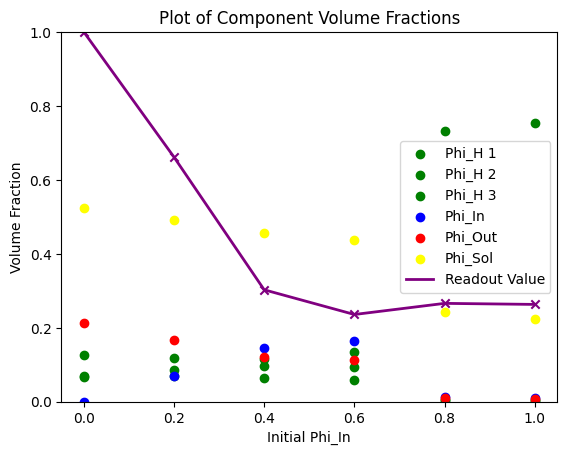

LOSS: 0.7964382126639954
IN BOUNDS
[[0.         5.31743955 5.2568896  6.16704884 7.2654138  0.        ]
 [5.31743955 0.         5.71032958 5.30495694 5.21093507 0.        ]
 [5.2568896  5.71032958 0.         6.67363882 7.47923245 0.        ]
 [6.16704884 5.30495694 6.67363882 0.         6.50888084 0.        ]
 [7.2654138  5.21093507 7.47923245 6.50888084 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.11023297 0.00721099 0.10331748 0.1        0.67923856]
 [0.04       0.11023297 0.00721099 0.10331748 0.1        0.63923856]
 [0.08       0.11023297 0.00721099 0.10331748 0.1        0.59923856]
 [0.12       0.11023297 0.00721099 0.10331748 0.1        0.55923856]
 [0.16       0.11023297 0.00721099 0.10331748 0.1        0.51923856]
 [0.2        0.11023297 0.00721099 0.10331748 0.1        0.47923856]]


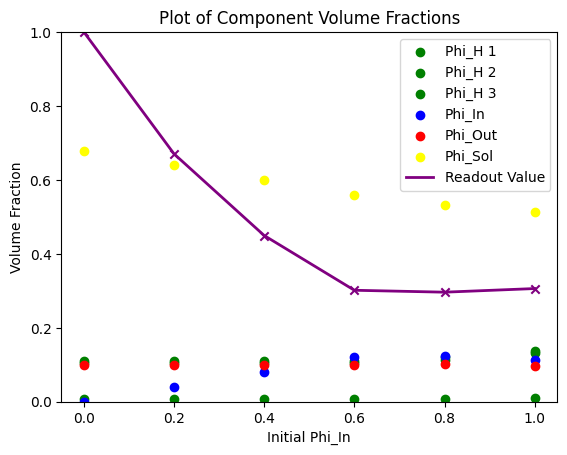

LOSS: 0.6837851286037385
IN BOUNDS
[[0.         7.65312335 6.71150327 7.21578341 5.04869988 0.        ]
 [7.65312335 0.         6.05194697 4.54651746 6.28117188 0.        ]
 [6.71150327 6.05194697 0.         6.20104001 6.15167498 0.        ]
 [7.21578341 4.54651746 6.20104001 0.         6.1654714  0.        ]
 [5.04869988 6.28117188 6.15167498 6.1654714  0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.14473158 0.27250517 0.04725899 0.1        0.43550426]
 [0.04       0.14473158 0.27250517 0.04725899 0.1        0.39550426]
 [0.08       0.14473158 0.27250517 0.04725899 0.1        0.35550426]
 [0.12       0.14473158 0.27250517 0.04725899 0.1        0.31550426]
 [0.16       0.14473158 0.27250517 0.04725899 0.1        0.27550426]
 [0.2        0.14473158 0.27250517 0.04725899 0.1        0.23550426]]


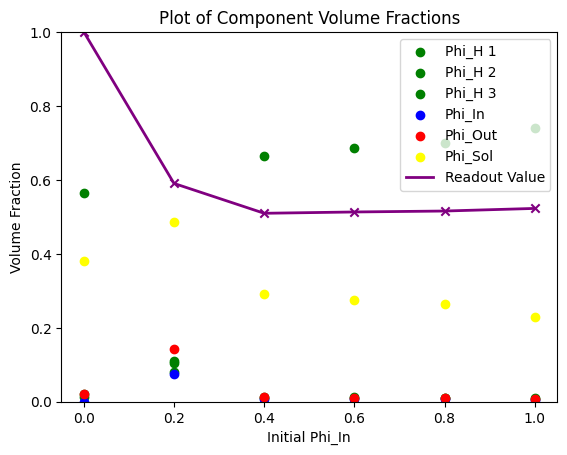

LOSS: 1.2106560374522473
IN BOUNDS
[[0.         6.82836719 5.40352957 5.09331208 8.10686422 0.        ]
 [6.82836719 0.         4.40119693 3.50401494 6.16447029 0.        ]
 [5.40352957 4.40119693 0.         6.69839536 6.14410238 0.        ]
 [5.09331208 3.50401494 6.69839536 0.         5.19226323 0.        ]
 [8.10686422 6.16447029 6.14410238 5.19226323 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.16125611 0.22857977 0.13641256 0.1        0.37375156]
 [0.04       0.16125611 0.22857977 0.13641256 0.1        0.33375156]
 [0.08       0.16125611 0.22857977 0.13641256 0.1        0.29375156]
 [0.12       0.16125611 0.22857977 0.13641256 0.1        0.25375156]
 [0.16       0.16125611 0.22857977 0.13641256 0.1        0.21375156]
 [0.2        0.16125611 0.22857977 0.13641256 0.1        0.17375156]]


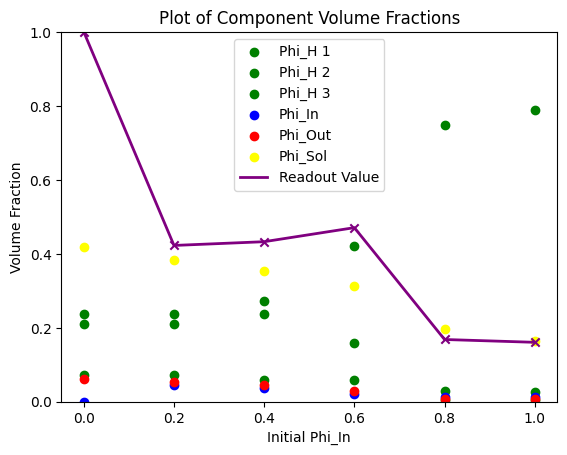

LOSS: 0.930897003059083
IN BOUNDS
[[0.         5.23230348 6.62838863 5.85194317 5.53842768 0.        ]
 [5.23230348 0.         7.07088068 4.63073734 5.60955621 0.        ]
 [6.62838863 7.07088068 0.         6.99518995 3.46129907 0.        ]
 [5.85194317 4.63073734 6.99518995 0.         7.60427367 0.        ]
 [5.53842768 5.60955621 3.46129907 7.60427367 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.10838469 0.07201314 0.04727661 0.1        0.67232556]
 [0.04       0.10838469 0.07201314 0.04727661 0.1        0.63232556]
 [0.08       0.10838469 0.07201314 0.04727661 0.1        0.59232556]
 [0.12       0.10838469 0.07201314 0.04727661 0.1        0.55232556]
 [0.16       0.10838469 0.07201314 0.04727661 0.1        0.51232556]
 [0.2        0.10838469 0.07201314 0.04727661 0.1        0.47232556]]


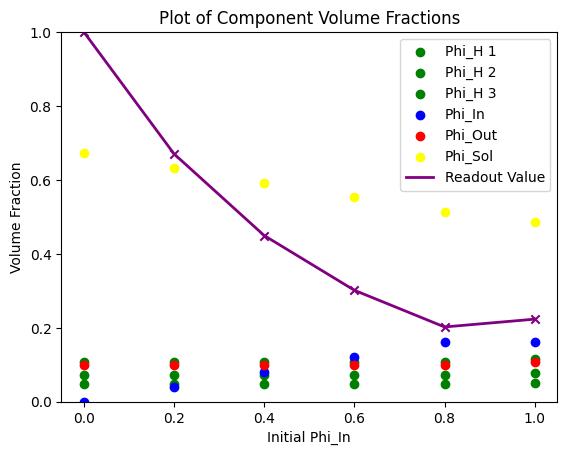

LOSS: 0.5931472135716143
IN BOUNDS
[[0.         6.46800879 6.30330216 5.74038179 6.12242401 0.        ]
 [6.46800879 0.         6.69139769 7.35731538 6.21979856 0.        ]
 [6.30330216 6.69139769 0.         6.31561177 5.50093569 0.        ]
 [5.74038179 7.35731538 6.31561177 0.         6.39537408 0.        ]
 [6.12242401 6.21979856 5.50093569 6.39537408 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.1083847  0.07201314 0.04727661 0.1        0.67232555]
 [0.04       0.1083847  0.07201314 0.04727661 0.1        0.63232555]
 [0.08       0.1083847  0.07201314 0.04727661 0.1        0.59232555]
 [0.12       0.1083847  0.07201314 0.04727661 0.1        0.55232555]
 [0.16       0.1083847  0.07201314 0.04727661 0.1        0.51232555]
 [0.2        0.1083847  0.07201314 0.04727661 0.1        0.47232555]]


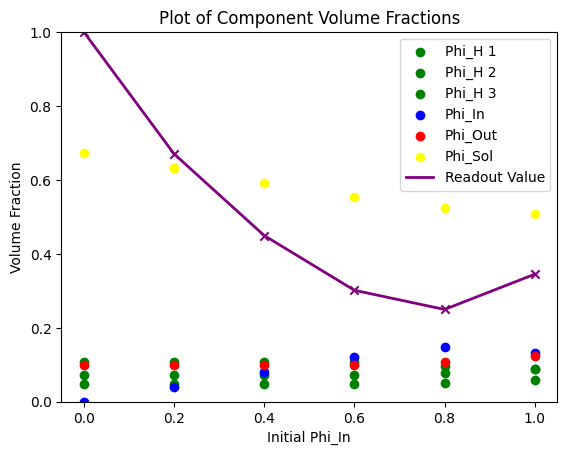

LOSS: 0.6835543779428037
IN BOUNDS
[[0.         7.14607181 4.6722311  5.93774361 5.24491673 0.        ]
 [7.14607181 0.         6.64295908 5.19283885 4.97867797 0.        ]
 [4.6722311  6.64295908 0.         7.01534355 7.79169525 0.        ]
 [5.93774361 5.19283885 7.01534355 0.         6.56965755 0.        ]
 [5.24491673 4.97867797 7.79169525 6.56965755 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.10838469 0.07201315 0.04727661 0.1        0.67232555]
 [0.04       0.10838469 0.07201315 0.04727661 0.1        0.63232555]
 [0.08       0.10838469 0.07201315 0.04727661 0.1        0.59232555]
 [0.12       0.10838469 0.07201315 0.04727661 0.1        0.55232555]
 [0.16       0.10838469 0.07201315 0.04727661 0.1        0.51232555]
 [0.2        0.10838469 0.07201315 0.04727661 0.1        0.47232555]]


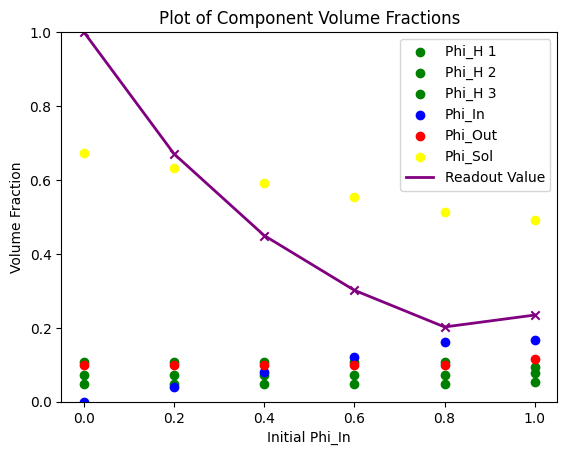

LOSS: 0.5982244083803374
IN BOUNDS
[[0.         7.15672851 7.81229036 6.32616237 5.92020486 0.        ]
 [7.15672851 0.         8.20911954 5.78456101 5.45580613 0.        ]
 [7.81229036 8.20911954 0.         6.3846418  3.54731227 0.        ]
 [6.32616237 5.78456101 6.3846418  0.         7.68468151 0.        ]
 [5.92020486 5.45580613 3.54731227 7.68468151 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.10838469 0.07201314 0.04727662 0.1        0.67232555]
 [0.04       0.10838469 0.07201314 0.04727662 0.1        0.63232555]
 [0.08       0.10838469 0.07201314 0.04727662 0.1        0.59232555]
 [0.12       0.10838469 0.07201314 0.04727662 0.1        0.55232555]
 [0.16       0.10838469 0.07201314 0.04727662 0.1        0.51232555]
 [0.2        0.10838469 0.07201314 0.04727662 0.1        0.47232555]]


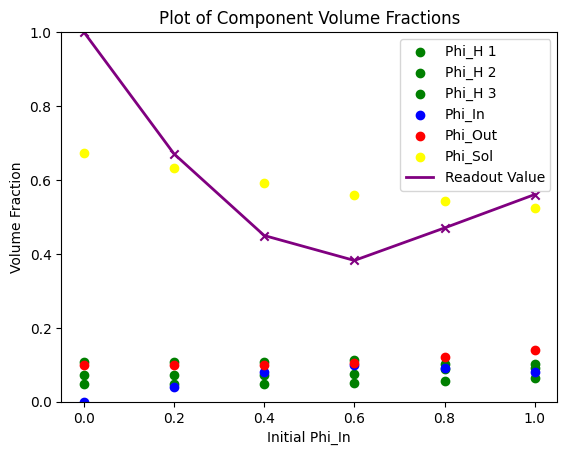

LOSS: 1.0923973064090369
IN BOUNDS
[[0.         5.83358867 6.96332828 5.61136147 6.59652021 0.        ]
 [5.83358867 0.         7.1494572  5.70431048 7.25510151 0.        ]
 [6.96332828 7.1494572  0.         5.65914367 5.41923041 0.        ]
 [5.61136147 5.70431048 5.65914367 0.         5.44247053 0.        ]
 [6.59652021 7.25510151 5.41923041 5.44247053 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.   0.   0.   0.   0.1  0.9 ]
 [0.04 0.   0.   0.   0.1  0.86]
 [0.08 0.   0.   0.   0.1  0.82]
 [0.12 0.   0.   0.   0.1  0.78]
 [0.16 0.   0.   0.   0.1  0.74]
 [0.2  0.   0.   0.   0.1  0.7 ]]


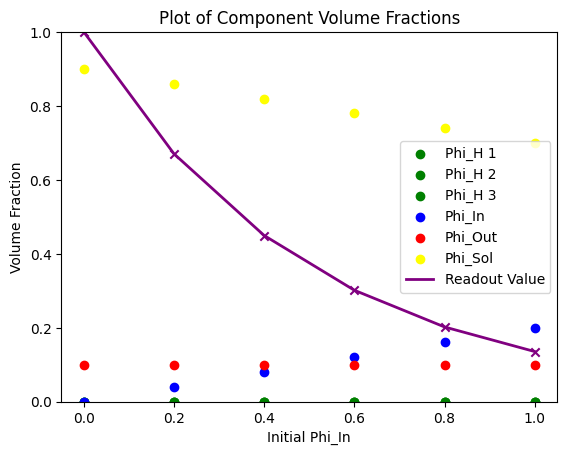

LOSS: 0.5617237480421102
IN BOUNDS
[[0.         6.42168431 6.86132695 5.93093627 5.28893271 0.        ]
 [6.42168431 0.         8.00613017 6.98007579 7.25716731 0.        ]
 [6.86132695 8.00613017 0.         7.30988059 4.76678924 0.        ]
 [5.93093627 6.98007579 7.30988059 0.         5.93643809 0.        ]
 [5.28893271 7.25716731 4.76678924 5.93643809 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.0000000e+00 1.0000000e-08 0.0000000e+00 0.0000000e+00 1.0000000e-01
  8.9999999e-01]
 [4.0000000e-02 1.0000000e-08 0.0000000e+00 0.0000000e+00 1.0000000e-01
  8.5999999e-01]
 [8.0000000e-02 1.0000000e-08 0.0000000e+00 0.0000000e+00 1.0000000e-01
  8.1999999e-01]
 [1.2000000e-01 1.0000000e-08 0.0000000e+00 0.0000000e+00 1.0000000e-01
  7.7999999e-01]
 [1.6000000e-01 1.0000000e-08 0.0000000e+00 0.0000000e+00 1.0000000e-01
  7.3999999e-01]
 [2.0000000e-01 1.0000000e-08 0.0000000e+00 0.0000000e+00 1.0000000e-01
  6.9999999e-01]]


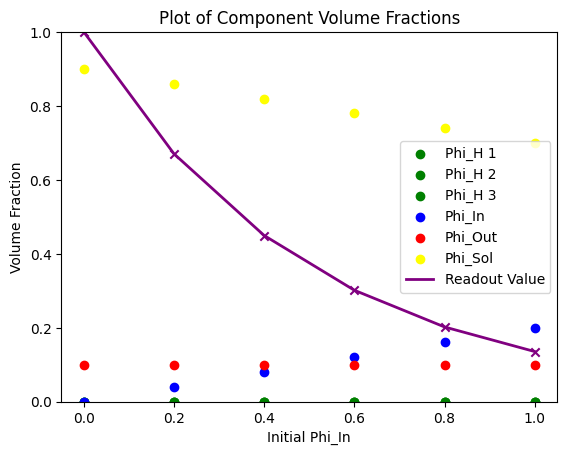

LOSS: 0.5617232678422397
IN BOUNDS
[[0.         4.51149912 5.76615655 6.62056188 5.04645082 0.        ]
 [4.51149912 0.         6.56423672 5.41250021 6.28765317 0.        ]
 [5.76615655 6.56423672 0.         6.51486477 5.09667467 0.        ]
 [6.62056188 5.41250021 6.51486477 0.         6.37579864 0.        ]
 [5.04645082 6.28765317 5.09667467 6.37579864 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.0000000e+00 0.0000000e+00 1.0000000e-08 0.0000000e+00 1.0000000e-01
  8.9999999e-01]
 [4.0000000e-02 0.0000000e+00 1.0000000e-08 0.0000000e+00 1.0000000e-01
  8.5999999e-01]
 [8.0000000e-02 0.0000000e+00 1.0000000e-08 0.0000000e+00 1.0000000e-01
  8.1999999e-01]
 [1.2000000e-01 0.0000000e+00 1.0000000e-08 0.0000000e+00 1.0000000e-01
  7.7999999e-01]
 [1.6000000e-01 0.0000000e+00 1.0000000e-08 0.0000000e+00 1.0000000e-01
  7.3999999e-01]
 [2.0000000e-01 0.0000000e+00 1.0000000e-08 0.0000000e+00 1.0000000e-01
  6.9999999e-01]]


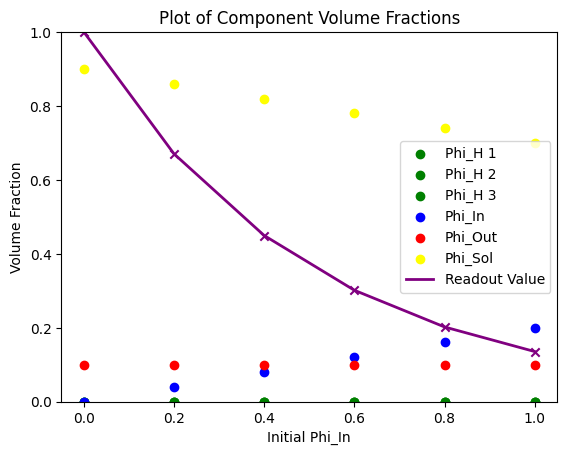

LOSS: 0.5617232613831504
IN BOUNDS
[[0.         7.69930025 8.12374244 6.05968111 5.71418065 0.        ]
 [7.69930025 0.         6.64560434 6.31951712 7.34968675 0.        ]
 [8.12374244 6.64560434 0.         6.44403337 6.72575585 0.        ]
 [6.05968111 6.31951712 6.44403337 0.         5.34081242 0.        ]
 [5.71418065 7.34968675 6.72575585 5.34081242 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e-08 1.0000000e-01
  8.9999999e-01]
 [4.0000000e-02 0.0000000e+00 0.0000000e+00 1.0000000e-08 1.0000000e-01
  8.5999999e-01]
 [8.0000000e-02 0.0000000e+00 0.0000000e+00 1.0000000e-08 1.0000000e-01
  8.1999999e-01]
 [1.2000000e-01 0.0000000e+00 0.0000000e+00 1.0000000e-08 1.0000000e-01
  7.7999999e-01]
 [1.6000000e-01 0.0000000e+00 0.0000000e+00 1.0000000e-08 1.0000000e-01
  7.3999999e-01]
 [2.0000000e-01 0.0000000e+00 0.0000000e+00 1.0000000e-08 1.0000000e-01
  6.9999999e-01]]


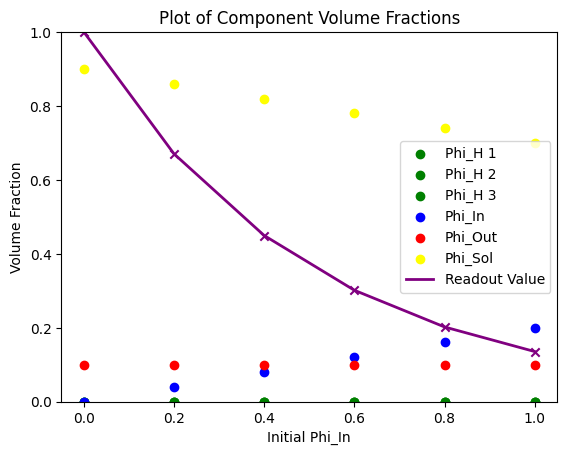

LOSS: 0.5617234363408337
IN BOUNDS
[[0.         3.53784074 4.92483162 3.77862966 4.31799954 0.        ]
 [3.53784074 0.         4.97621159 6.51309786 4.55568405 0.        ]
 [4.92483162 4.97621159 0.         5.3848392  6.83742084 0.        ]
 [3.77862966 6.51309786 5.3848392  0.         7.18165227 0.        ]
 [4.31799954 4.55568405 6.83742084 7.18165227 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.07231056 0.0480447  0.03154134 0.1        0.7481034 ]
 [0.04       0.07231056 0.0480447  0.03154134 0.1        0.7081034 ]
 [0.08       0.07231056 0.0480447  0.03154134 0.1        0.6681034 ]
 [0.12       0.07231056 0.0480447  0.03154134 0.1        0.6281034 ]
 [0.16       0.07231056 0.0480447  0.03154134 0.1        0.5881034 ]
 [0.2        0.07231056 0.0480447  0.03154134 0.1        0.5481034 ]]


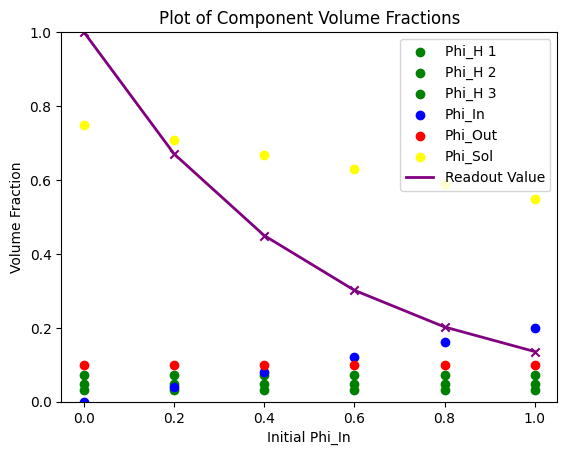

LOSS: 0.5617232651718769
IN BOUNDS
[[0.         5.39993802 7.03831286 6.90454953 6.84776475 0.        ]
 [5.39993802 0.         6.01786102 7.19167479 6.62655811 0.        ]
 [7.03831286 6.01786102 0.         7.52078167 4.87848986 0.        ]
 [6.90454953 7.19167479 7.52078167 0.         5.92504921 0.        ]
 [6.84776475 6.62655811 4.87848986 5.92504921 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.07231057 0.0480447  0.03154134 0.1        0.74810339]
 [0.04       0.07231057 0.0480447  0.03154134 0.1        0.70810339]
 [0.08       0.07231057 0.0480447  0.03154134 0.1        0.66810339]
 [0.12       0.07231057 0.0480447  0.03154134 0.1        0.62810339]
 [0.16       0.07231057 0.0480447  0.03154134 0.1        0.58810339]
 [0.2        0.07231057 0.0480447  0.03154134 0.1        0.54810339]]


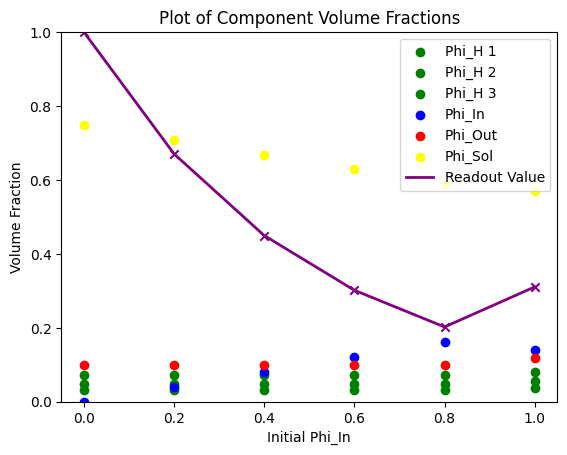

LOSS: 0.6397094036220847
IN BOUNDS
[[0.         5.54934189 6.04649307 6.74630898 6.93129981 0.        ]
 [5.54934189 0.         5.8998038  4.70339372 6.66243106 0.        ]
 [6.04649307 5.8998038  0.         5.2319834  4.75850176 0.        ]
 [6.74630898 4.70339372 5.2319834  0.         5.25134238 0.        ]
 [6.93129981 6.66243106 4.75850176 5.25134238 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.07231056 0.04804471 0.03154134 0.1        0.74810339]
 [0.04       0.07231056 0.04804471 0.03154134 0.1        0.70810339]
 [0.08       0.07231056 0.04804471 0.03154134 0.1        0.66810339]
 [0.12       0.07231056 0.04804471 0.03154134 0.1        0.62810339]
 [0.16       0.07231056 0.04804471 0.03154134 0.1        0.58810339]
 [0.2        0.07231056 0.04804471 0.03154134 0.1        0.54810339]]


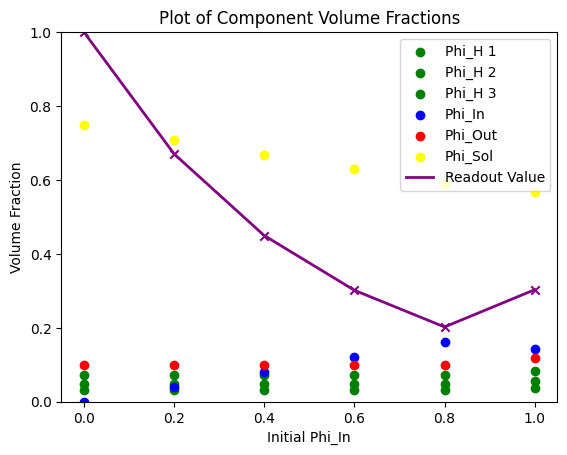

LOSS: 0.6350365184128106
IN BOUNDS
[[0.         7.06649117 3.28489987 6.21157312 5.91342059 0.        ]
 [7.06649117 0.         5.73214005 6.30882605 4.9771056  0.        ]
 [3.28489987 5.73214005 0.         5.87108764 8.18111907 0.        ]
 [6.21157312 6.30882605 5.87108764 0.         7.51505181 0.        ]
 [5.91342059 4.9771056  8.18111907 7.51505181 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.07231056 0.0480447  0.03154135 0.1        0.74810339]
 [0.04       0.07231056 0.0480447  0.03154135 0.1        0.70810339]
 [0.08       0.07231056 0.0480447  0.03154135 0.1        0.66810339]
 [0.12       0.07231056 0.0480447  0.03154135 0.1        0.62810339]
 [0.16       0.07231056 0.0480447  0.03154135 0.1        0.58810339]
 [0.2        0.07231056 0.0480447  0.03154135 0.1        0.54810339]]


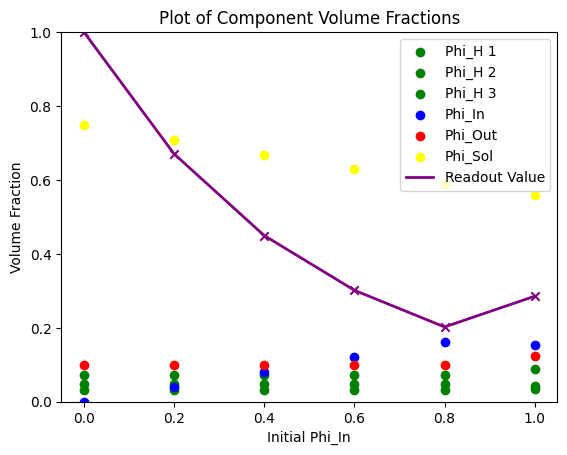

LOSS: 0.6246738214162567
IN BOUNDS
[[0.         6.59923329 6.5011739  5.50038088 7.01087734 0.        ]
 [6.59923329 0.         5.80048882 6.32198506 6.99279459 0.        ]
 [6.5011739  5.80048882 0.         5.50846366 4.46585954 0.        ]
 [5.50038088 6.32198506 5.50846366 0.         5.96206049 0.        ]
 [7.01087734 6.99279459 4.46585954 5.96206049 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.0989394  0.06573748 0.04315664 0.1        0.69216648]
 [0.04       0.0989394  0.06573748 0.04315664 0.1        0.65216648]
 [0.08       0.0989394  0.06573748 0.04315664 0.1        0.61216648]
 [0.12       0.0989394  0.06573748 0.04315664 0.1        0.57216648]
 [0.16       0.0989394  0.06573748 0.04315664 0.1        0.53216648]
 [0.2        0.0989394  0.06573748 0.04315664 0.1        0.49216648]]


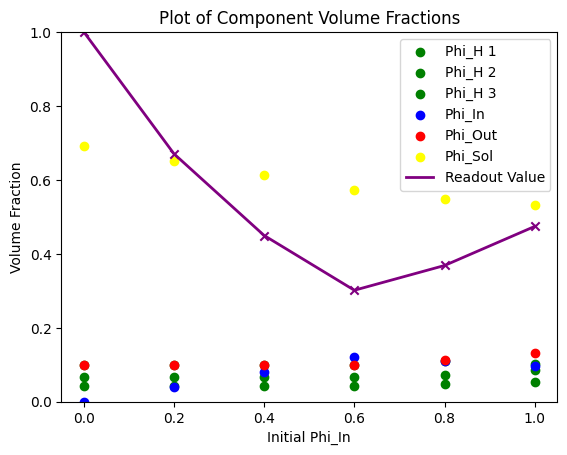

LOSS: 0.8628609677800498
IN BOUNDS
[[0.         5.58924888 5.80703165 7.47982143 8.2927868  0.        ]
 [5.58924888 0.         6.41444214 7.71371946 7.69576191 0.        ]
 [5.80703165 6.41444214 0.         5.97788426 6.26798591 0.        ]
 [7.47982143 7.71371946 5.97788426 0.         4.79461942 0.        ]
 [8.2927868  7.69576191 6.26798591 4.79461942 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.09893941 0.06573748 0.04315664 0.1        0.69216647]
 [0.04       0.09893941 0.06573748 0.04315664 0.1        0.65216647]
 [0.08       0.09893941 0.06573748 0.04315664 0.1        0.61216647]
 [0.12       0.09893941 0.06573748 0.04315664 0.1        0.57216647]
 [0.16       0.09893941 0.06573748 0.04315664 0.1        0.53216647]
 [0.2        0.09893941 0.06573748 0.04315664 0.1        0.49216647]]


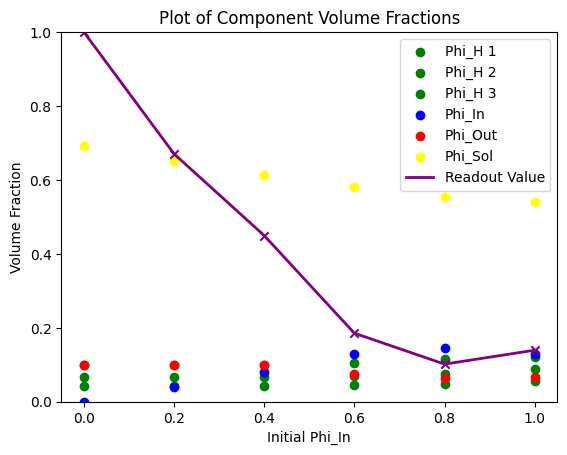

LOSS: 0.47574773301374246
IN BOUNDS
[[0.         6.29507989 6.08009478 6.00254803 7.43414144 0.        ]
 [6.29507989 0.         5.82749138 7.15847733 6.99389378 0.        ]
 [6.08009478 5.82749138 0.         5.32433369 7.12533449 0.        ]
 [6.00254803 7.15847733 5.32433369 0.         5.0662395  0.        ]
 [7.43414144 6.99389378 7.12533449 5.0662395  0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.0989394  0.06573749 0.04315664 0.1        0.69216647]
 [0.04       0.0989394  0.06573749 0.04315664 0.1        0.65216647]
 [0.08       0.0989394  0.06573749 0.04315664 0.1        0.61216647]
 [0.12       0.0989394  0.06573749 0.04315664 0.1        0.57216647]
 [0.16       0.0989394  0.06573749 0.04315664 0.1        0.53216647]
 [0.2        0.0989394  0.06573749 0.04315664 0.1        0.49216647]]


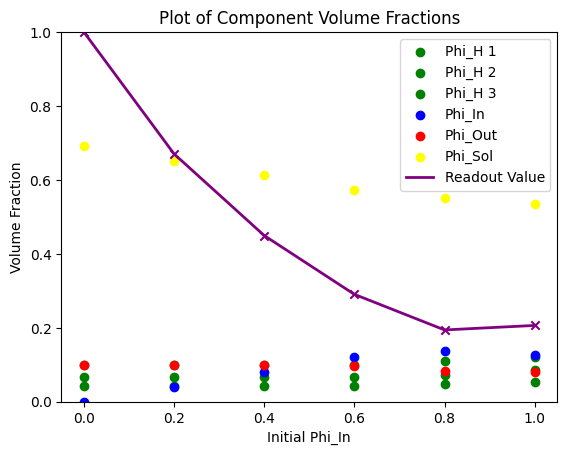

LOSS: 0.5761289719514364
IN BOUNDS
[[0.         6.66186295 6.53820151 5.01202697 5.01873755 0.        ]
 [6.66186295 0.         6.33047219 6.41192919 8.22144493 0.        ]
 [6.53820151 6.33047219 0.         5.52510261 6.11139244 0.        ]
 [5.01202697 6.41192919 5.52510261 0.         4.79358759 0.        ]
 [5.01873755 8.22144493 6.11139244 4.79358759 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.0989394  0.06573748 0.04315665 0.1        0.69216647]
 [0.04       0.0989394  0.06573748 0.04315665 0.1        0.65216647]
 [0.08       0.0989394  0.06573748 0.04315665 0.1        0.61216647]
 [0.12       0.0989394  0.06573748 0.04315665 0.1        0.57216647]
 [0.16       0.0989394  0.06573748 0.04315665 0.1        0.53216647]
 [0.2        0.0989394  0.06573748 0.04315665 0.1        0.49216647]]


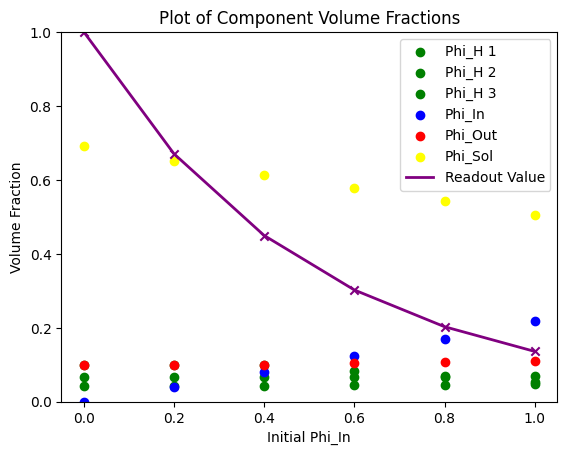

LOSS: 0.5625442717301673
IN BOUNDS
[[0.         9.04081401 4.66964198 5.29860948 4.50441206 0.        ]
 [9.04081401 0.         5.76682799 4.70920372 4.85533165 0.        ]
 [4.66964198 5.76682799 0.         7.94969116 6.39477443 0.        ]
 [5.29860948 4.70920372 7.94969116 0.         5.90481426 0.        ]
 [4.50441206 4.85533165 6.39477443 5.90481426 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.10324543 0.0685985  0.0450349  0.1        0.68312117]
 [0.04       0.10324543 0.0685985  0.0450349  0.1        0.64312117]
 [0.08       0.10324543 0.0685985  0.0450349  0.1        0.60312117]
 [0.12       0.10324543 0.0685985  0.0450349  0.1        0.56312117]
 [0.16       0.10324543 0.0685985  0.0450349  0.1        0.52312117]
 [0.2        0.10324543 0.0685985  0.0450349  0.1        0.48312117]]


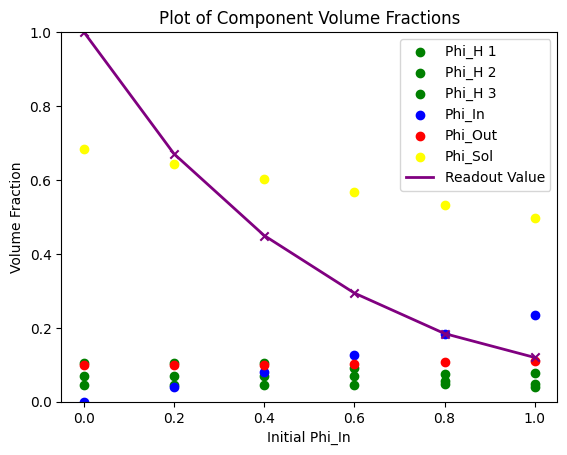

LOSS: 0.5462405457876116
IN BOUNDS
[[0.         6.1895826  6.29881223 6.48673386 6.41812902 0.        ]
 [6.1895826  0.         5.57543018 5.61181989 5.45013234 0.        ]
 [6.29881223 5.57543018 0.         7.69180459 7.80262748 0.        ]
 [6.48673386 5.61181989 7.69180459 0.         5.67360415 0.        ]
 [6.41812902 5.45013234 7.80262748 5.67360415 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.10324544 0.0685985  0.0450349  0.1        0.68312116]
 [0.04       0.10324544 0.0685985  0.0450349  0.1        0.64312116]
 [0.08       0.10324544 0.0685985  0.0450349  0.1        0.60312116]
 [0.12       0.10324544 0.0685985  0.0450349  0.1        0.56312116]
 [0.16       0.10324544 0.0685985  0.0450349  0.1        0.52312116]
 [0.2        0.10324544 0.0685985  0.0450349  0.1        0.48312116]]


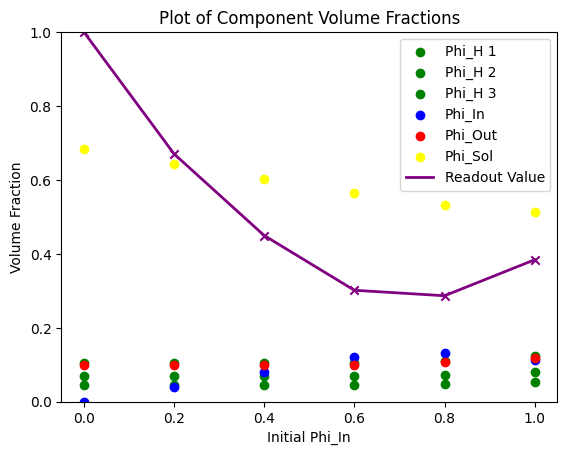

LOSS: 0.7319112526861189
IN BOUNDS
[[0.         4.37166627 5.51784597 5.80264544 5.66344208 0.        ]
 [4.37166627 0.         5.64180983 4.5199368  3.88384604 0.        ]
 [5.51784597 5.64180983 0.         6.28571547 6.57135667 0.        ]
 [5.80264544 4.5199368  6.28571547 0.         7.75111965 0.        ]
 [5.66344208 3.88384604 6.57135667 7.75111965 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.10324543 0.06859851 0.0450349  0.1        0.68312116]
 [0.04       0.10324543 0.06859851 0.0450349  0.1        0.64312116]
 [0.08       0.10324543 0.06859851 0.0450349  0.1        0.60312116]
 [0.12       0.10324543 0.06859851 0.0450349  0.1        0.56312116]
 [0.16       0.10324543 0.06859851 0.0450349  0.1        0.52312116]
 [0.2        0.10324543 0.06859851 0.0450349  0.1        0.48312116]]


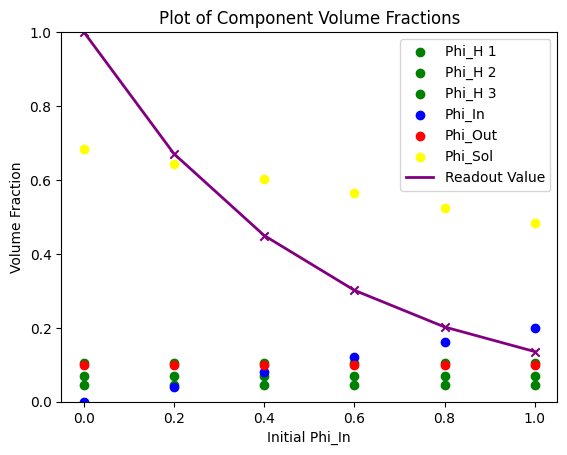

LOSS: 0.5617233078124424
IN BOUNDS
[[0.         6.16621015 5.38477671 4.68550704 6.67479281 0.        ]
 [6.16621015 0.         7.15123015 6.01194845 5.22994664 0.        ]
 [5.38477671 7.15123015 0.         5.54325113 7.99656758 0.        ]
 [4.68550704 6.01194845 5.54325113 0.         6.42518796 0.        ]
 [6.67479281 5.22994664 7.99656758 6.42518796 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.10324543 0.0685985  0.04503491 0.1        0.68312116]
 [0.04       0.10324543 0.0685985  0.04503491 0.1        0.64312116]
 [0.08       0.10324543 0.0685985  0.04503491 0.1        0.60312116]
 [0.12       0.10324543 0.0685985  0.04503491 0.1        0.56312116]
 [0.16       0.10324543 0.0685985  0.04503491 0.1        0.52312116]
 [0.2        0.10324543 0.0685985  0.04503491 0.1        0.48312116]]


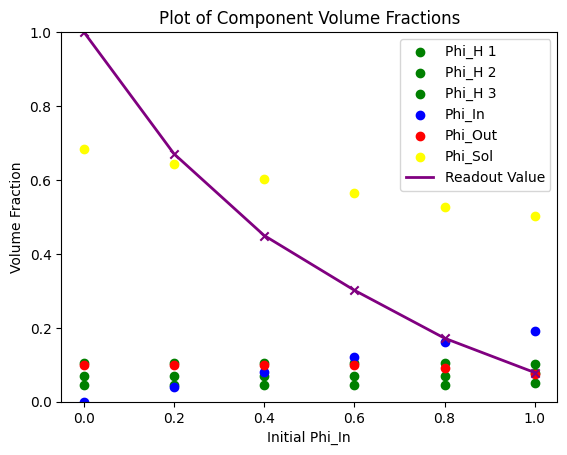

LOSS: 0.5382183686770918
IN BOUNDS
[[0.         5.24088286 5.43263881 7.38893956 5.13614978 0.        ]
 [5.24088286 0.         7.02747255 5.75996001 5.84193088 0.        ]
 [5.43263881 7.02747255 0.         6.83594746 6.99189531 0.        ]
 [7.38893956 5.75996001 6.83594746 0.         8.17464563 0.        ]
 [5.13614978 5.84193088 6.99189531 8.17464563 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.1071118  0.0711674  0.04672139 0.1        0.67499941]
 [0.04       0.1071118  0.0711674  0.04672139 0.1        0.63499941]
 [0.08       0.1071118  0.0711674  0.04672139 0.1        0.59499941]
 [0.12       0.1071118  0.0711674  0.04672139 0.1        0.55499941]
 [0.16       0.1071118  0.0711674  0.04672139 0.1        0.51499941]
 [0.2        0.1071118  0.0711674  0.04672139 0.1        0.47499941]]


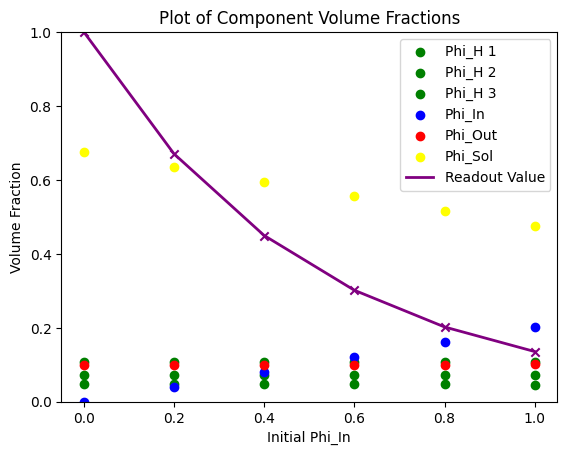

LOSS: 0.5617219933569978
IN BOUNDS
[[0.         5.17538287 5.80392056 6.67815822 5.3689628  0.        ]
 [5.17538287 0.         5.94472387 4.25450149 5.55568384 0.        ]
 [5.80392056 5.94472387 0.         7.14236632 4.41959656 0.        ]
 [6.67815822 4.25450149 7.14236632 0.         6.72713581 0.        ]
 [5.3689628  5.55568384 4.41959656 6.72713581 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.10711181 0.0711674  0.04672139 0.1        0.6749994 ]
 [0.04       0.10711181 0.0711674  0.04672139 0.1        0.6349994 ]
 [0.08       0.10711181 0.0711674  0.04672139 0.1        0.5949994 ]
 [0.12       0.10711181 0.0711674  0.04672139 0.1        0.5549994 ]
 [0.16       0.10711181 0.0711674  0.04672139 0.1        0.5149994 ]
 [0.2        0.10711181 0.0711674  0.04672139 0.1        0.4749994 ]]


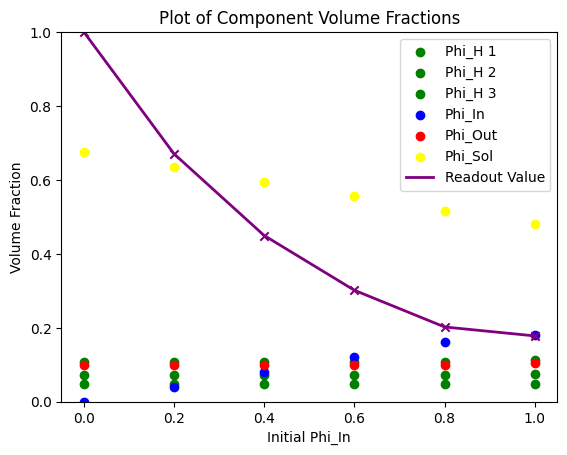

LOSS: 0.5749850962825306
IN BOUNDS
[[0.         6.86691085 6.49531442 5.62717531 8.13959247 0.        ]
 [6.86691085 0.         5.74377958 7.7095131  7.51044635 0.        ]
 [6.49531442 5.74377958 0.         6.44159152 4.81572568 0.        ]
 [5.62717531 7.7095131  6.44159152 0.         6.17127797 0.        ]
 [8.13959247 7.51044635 4.81572568 6.17127797 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.1071118  0.07116741 0.04672139 0.1        0.6749994 ]
 [0.04       0.1071118  0.07116741 0.04672139 0.1        0.6349994 ]
 [0.08       0.1071118  0.07116741 0.04672139 0.1        0.5949994 ]
 [0.12       0.1071118  0.07116741 0.04672139 0.1        0.5549994 ]
 [0.16       0.1071118  0.07116741 0.04672139 0.1        0.5149994 ]
 [0.2        0.1071118  0.07116741 0.04672139 0.1        0.4749994 ]]


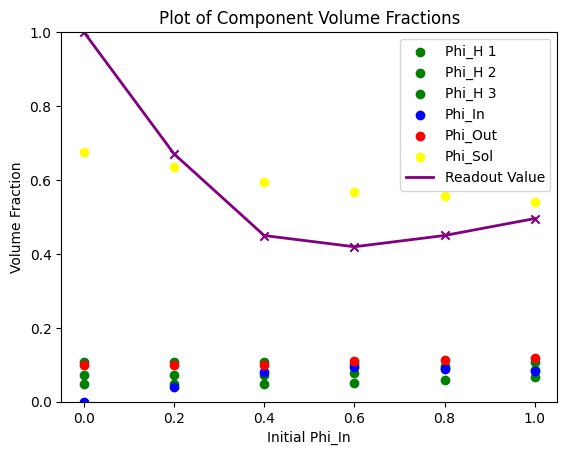

LOSS: 1.0345630664346468
IN BOUNDS
[[0.         5.43030877 6.86848632 5.82690429 6.22563822 0.        ]
 [5.43030877 0.         6.634185   5.31207541 6.2882287  0.        ]
 [6.86848632 6.634185   0.         5.02409783 7.43545445 0.        ]
 [5.82690429 5.31207541 5.02409783 0.         7.1703725  0.        ]
 [6.22563822 6.2882287  7.43545445 7.1703725  0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.        0.1071118 0.0711674 0.0467214 0.1       0.6749994]
 [0.04      0.1071118 0.0711674 0.0467214 0.1       0.6349994]
 [0.08      0.1071118 0.0711674 0.0467214 0.1       0.5949994]
 [0.12      0.1071118 0.0711674 0.0467214 0.1       0.5549994]
 [0.16      0.1071118 0.0711674 0.0467214 0.1       0.5149994]
 [0.2       0.1071118 0.0711674 0.0467214 0.1       0.4749994]]


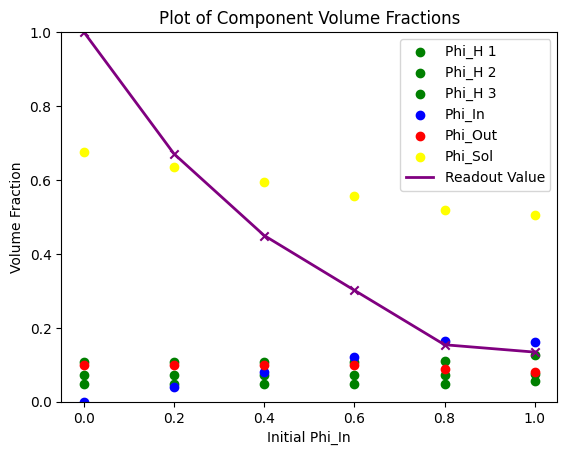

LOSS: 0.5442096188729529
IN BOUNDS
[[0.         6.75033406 6.41049735 6.97998142 5.79734212 0.        ]
 [6.75033406 0.         4.8326023  5.62578743 6.17313379 0.        ]
 [6.41049735 4.8326023  0.         6.08404717 3.21583142 0.        ]
 [6.97998142 5.62578743 6.08404717 0.         6.53487485 0.        ]
 [5.79734212 6.17313379 3.21583142 6.53487485 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.10811884 0.0718365  0.04716065 0.1        0.67288401]
 [0.04       0.10811884 0.0718365  0.04716065 0.1        0.63288401]
 [0.08       0.10811884 0.0718365  0.04716065 0.1        0.59288401]
 [0.12       0.10811884 0.0718365  0.04716065 0.1        0.55288401]
 [0.16       0.10811884 0.0718365  0.04716065 0.1        0.51288401]
 [0.2        0.10811884 0.0718365  0.04716065 0.1        0.47288401]]


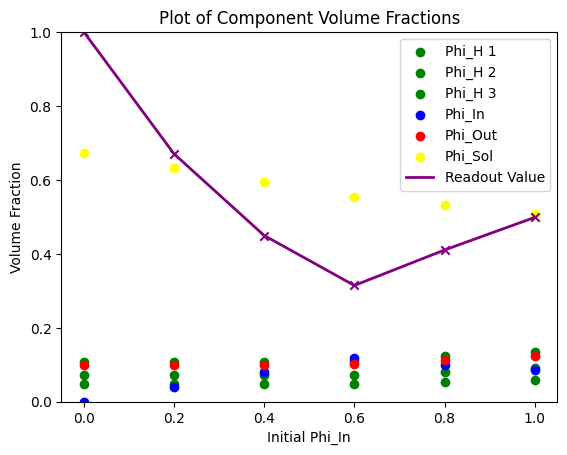

LOSS: 0.9272566478271828
IN BOUNDS
[[0.         8.56365708 5.631645   6.24957429 4.14103666 0.        ]
 [8.56365708 0.         3.36140127 5.47753504 5.99894853 0.        ]
 [5.631645   3.36140127 0.         5.86585842 7.07446026 0.        ]
 [6.24957429 5.47753504 5.86585842 0.         6.7031794  0.        ]
 [4.14103666 5.99894853 7.07446026 6.7031794  0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.10811885 0.0718365  0.04716065 0.1        0.672884  ]
 [0.04       0.10811885 0.0718365  0.04716065 0.1        0.632884  ]
 [0.08       0.10811885 0.0718365  0.04716065 0.1        0.592884  ]
 [0.12       0.10811885 0.0718365  0.04716065 0.1        0.552884  ]
 [0.16       0.10811885 0.0718365  0.04716065 0.1        0.512884  ]
 [0.2        0.10811885 0.0718365  0.04716065 0.1        0.472884  ]]


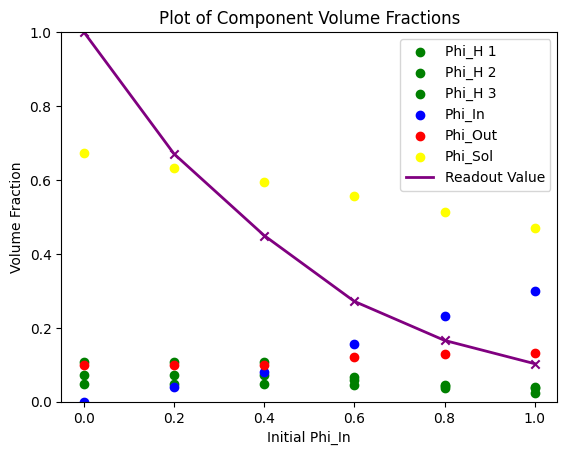

LOSS: 0.5233113269979596
IN BOUNDS
[[0.         5.94319163 6.7886152  5.13970706 4.84548573 0.        ]
 [5.94319163 0.         7.91774794 6.04620078 6.22238134 0.        ]
 [6.7886152  7.91774794 0.         6.75574327 6.3512394  0.        ]
 [5.13970706 6.04620078 6.75574327 0.         5.83557617 0.        ]
 [4.84548573 6.22238134 6.3512394  5.83557617 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.10811884 0.07183651 0.04716065 0.1        0.672884  ]
 [0.04       0.10811884 0.07183651 0.04716065 0.1        0.632884  ]
 [0.08       0.10811884 0.07183651 0.04716065 0.1        0.592884  ]
 [0.12       0.10811884 0.07183651 0.04716065 0.1        0.552884  ]
 [0.16       0.10811884 0.07183651 0.04716065 0.1        0.512884  ]
 [0.2        0.10811884 0.07183651 0.04716065 0.1        0.472884  ]]


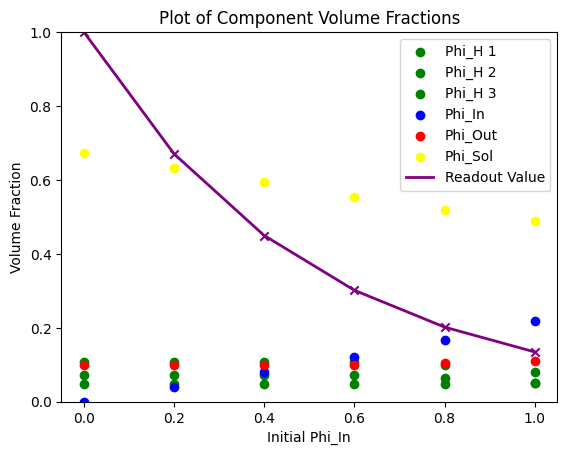

LOSS: 0.5612968812369283
IN BOUNDS
[[0.         4.00856341 5.46999481 5.63125962 5.93718622 0.        ]
 [4.00856341 0.         6.93546398 6.61639659 6.77484826 0.        ]
 [5.46999481 6.93546398 0.         5.41295141 7.2784857  0.        ]
 [5.63125962 6.61639659 5.41295141 0.         7.80679069 0.        ]
 [5.93718622 6.77484826 7.2784857  7.80679069 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.10811884 0.0718365  0.04716066 0.1        0.672884  ]
 [0.04       0.10811884 0.0718365  0.04716066 0.1        0.632884  ]
 [0.08       0.10811884 0.0718365  0.04716066 0.1        0.592884  ]
 [0.12       0.10811884 0.0718365  0.04716066 0.1        0.552884  ]
 [0.16       0.10811884 0.0718365  0.04716066 0.1        0.512884  ]
 [0.2        0.10811884 0.0718365  0.04716066 0.1        0.472884  ]]


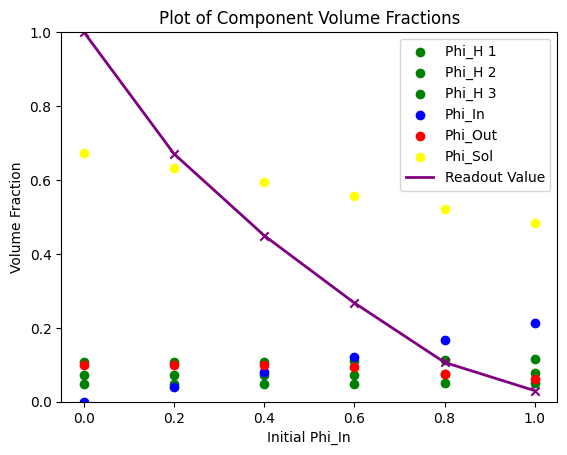

LOSS: 0.4953336100514869
IN BOUNDS
[[0.         6.71009917 5.63646637 6.18840276 8.07159187 0.        ]
 [6.71009917 0.         5.58375835 5.6460645  7.9272704  0.        ]
 [5.63646637 5.58375835 0.         6.83292363 5.94462104 0.        ]
 [6.18840276 5.6460645  6.83292363 0.         7.144847   0.        ]
 [8.07159187 7.9272704  5.94462104 7.144847   0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.10823843 0.07191596 0.04721281 0.1        0.67263281]
 [0.04       0.10823843 0.07191596 0.04721281 0.1        0.63263281]
 [0.08       0.10823843 0.07191596 0.04721281 0.1        0.59263281]
 [0.12       0.10823843 0.07191596 0.04721281 0.1        0.55263281]
 [0.16       0.10823843 0.07191596 0.04721281 0.1        0.51263281]
 [0.2        0.10823843 0.07191596 0.04721281 0.1        0.47263281]]


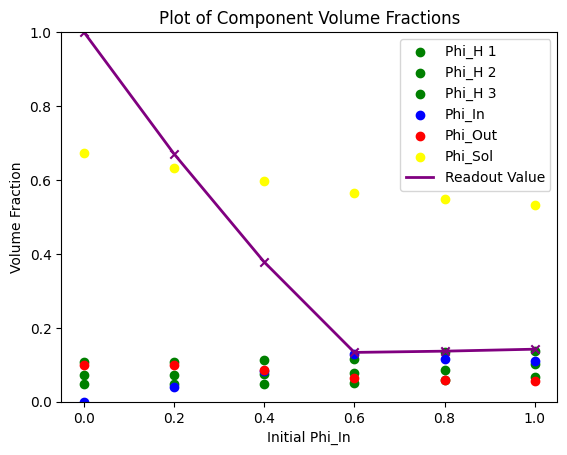

LOSS: 0.5523954658932616
IN BOUNDS
[[0.         5.73965705 6.06897473 5.07713974 5.83239418 0.        ]
 [5.73965705 0.         6.01058911 5.64274085 6.81715055 0.        ]
 [6.06897473 6.01058911 0.         2.73607581 5.61154383 0.        ]
 [5.07713974 5.64274085 2.73607581 0.         6.05995863 0.        ]
 [5.83239418 6.81715055 5.61154383 6.05995863 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.10823844 0.07191596 0.04721281 0.1        0.6726328 ]
 [0.04       0.10823844 0.07191596 0.04721281 0.1        0.6326328 ]
 [0.08       0.10823844 0.07191596 0.04721281 0.1        0.5926328 ]
 [0.12       0.10823844 0.07191596 0.04721281 0.1        0.5526328 ]
 [0.16       0.10823844 0.07191596 0.04721281 0.1        0.5126328 ]
 [0.2        0.10823844 0.07191596 0.04721281 0.1        0.4726328 ]]


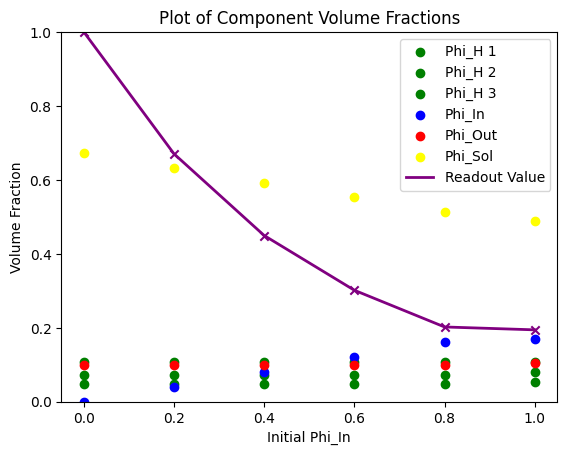

LOSS: 0.5810815573728727
IN BOUNDS
[[0.         6.39732879 6.97797176 5.93552069 5.69509491 0.        ]
 [6.39732879 0.         6.48090817 6.92191046 5.35151842 0.        ]
 [6.97797176 6.48090817 0.         5.33903154 5.67039344 0.        ]
 [5.93552069 6.92191046 5.33903154 0.         6.14210277 0.        ]
 [5.69509491 5.35151842 5.67039344 6.14210277 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.10823843 0.07191597 0.04721281 0.1        0.6726328 ]
 [0.04       0.10823843 0.07191597 0.04721281 0.1        0.6326328 ]
 [0.08       0.10823843 0.07191597 0.04721281 0.1        0.5926328 ]
 [0.12       0.10823843 0.07191597 0.04721281 0.1        0.5526328 ]
 [0.16       0.10823843 0.07191597 0.04721281 0.1        0.5126328 ]
 [0.2        0.10823843 0.07191597 0.04721281 0.1        0.4726328 ]]


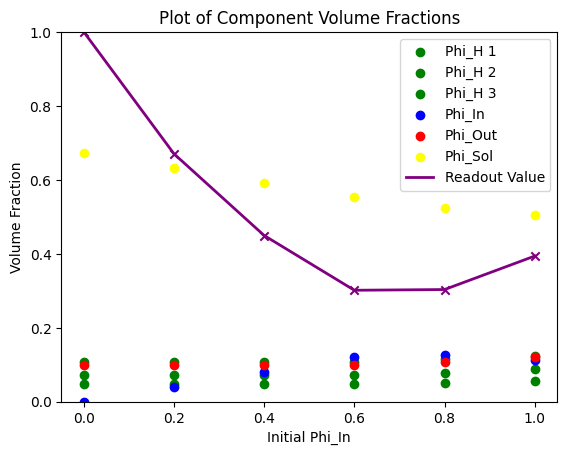

LOSS: 0.7496017529121526
IN BOUNDS
[[0.         6.70933067 6.63927861 5.4033009  6.45509378 0.        ]
 [6.70933067 0.         4.66509058 7.03271662 6.39083099 0.        ]
 [6.63927861 4.66509058 0.         6.08547518 5.99166863 0.        ]
 [5.4033009  7.03271662 6.08547518 0.         4.91796496 0.        ]
 [6.45509378 6.39083099 5.99166863 4.91796496 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.10823843 0.07191596 0.04721282 0.1        0.6726328 ]
 [0.04       0.10823843 0.07191596 0.04721282 0.1        0.6326328 ]
 [0.08       0.10823843 0.07191596 0.04721282 0.1        0.5926328 ]
 [0.12       0.10823843 0.07191596 0.04721282 0.1        0.5526328 ]
 [0.16       0.10823843 0.07191596 0.04721282 0.1        0.5126328 ]
 [0.2        0.10823843 0.07191596 0.04721282 0.1        0.4726328 ]]


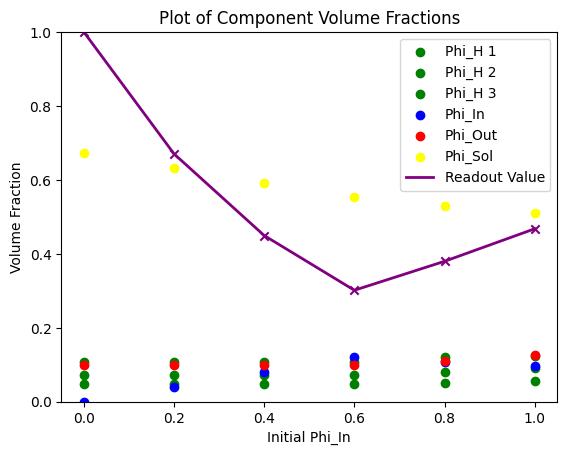

LOSS: 0.8653086307425423
IN BOUNDS
[[0.         8.28799329 7.27416243 7.5229237  5.45201137 0.        ]
 [8.28799329 0.         6.38555453 6.73879446 6.61155717 0.        ]
 [7.27416243 6.38555453 0.         7.05208737 6.53032353 0.        ]
 [7.5229237  6.73879446 7.05208737 0.         4.60237742 0.        ]
 [5.45201137 6.61155717 6.53032353 4.60237742 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.10835322 0.07199222 0.04726288 0.1        0.67239168]
 [0.04       0.10835322 0.07199222 0.04726288 0.1        0.63239168]
 [0.08       0.10835322 0.07199222 0.04726288 0.1        0.59239168]
 [0.12       0.10835322 0.07199222 0.04726288 0.1        0.55239168]
 [0.16       0.10835322 0.07199222 0.04726288 0.1        0.51239168]
 [0.2        0.10835322 0.07199222 0.04726288 0.1        0.47239168]]


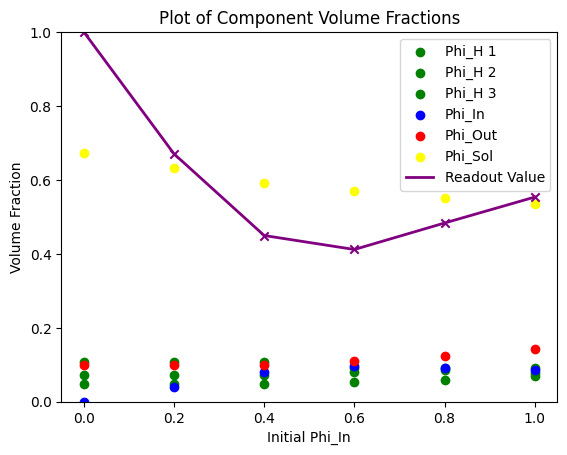

LOSS: 1.1208801332722003
IN BOUNDS
[[0.         6.47049093 6.24225794 5.06996499 5.91088873 0.        ]
 [6.47049093 0.         5.35348293 5.20629589 5.76788294 0.        ]
 [6.24225794 5.35348293 0.         6.39185051 6.5520167  0.        ]
 [5.06996499 5.20629589 6.39185051 0.         5.95810581 0.        ]
 [5.91088873 5.76788294 6.5520167  5.95810581 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.10835323 0.07199222 0.04726288 0.1        0.67239167]
 [0.04       0.10835323 0.07199222 0.04726288 0.1        0.63239167]
 [0.08       0.10835323 0.07199222 0.04726288 0.1        0.59239167]
 [0.12       0.10835323 0.07199222 0.04726288 0.1        0.55239167]
 [0.16       0.10835323 0.07199222 0.04726288 0.1        0.51239167]
 [0.2        0.10835323 0.07199222 0.04726288 0.1        0.47239167]]


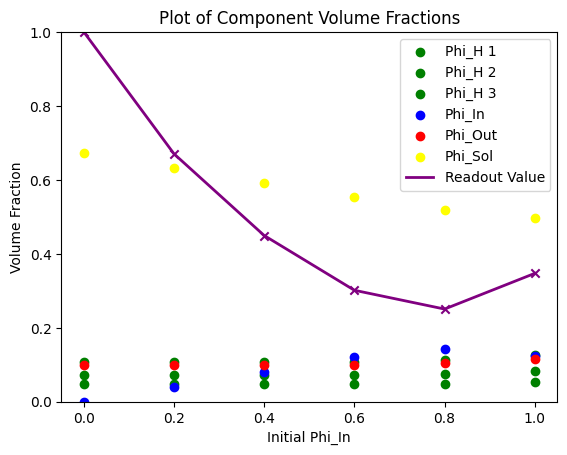

LOSS: 0.6856241806296143
IN BOUNDS
[[0.         7.26514407 8.19589136 5.2813603  6.18275137 0.        ]
 [7.26514407 0.         7.44198888 6.16341234 5.81580135 0.        ]
 [8.19589136 7.44198888 0.         7.50775459 7.0623428  0.        ]
 [5.2813603  6.16341234 7.50775459 0.         6.64685947 0.        ]
 [6.18275137 5.81580135 7.0623428  6.64685947 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.10835322 0.07199223 0.04726288 0.1        0.67239167]
 [0.04       0.10835322 0.07199223 0.04726288 0.1        0.63239167]
 [0.08       0.10835322 0.07199223 0.04726288 0.1        0.59239167]
 [0.12       0.10835322 0.07199223 0.04726288 0.1        0.55239167]
 [0.16       0.10835322 0.07199223 0.04726288 0.1        0.51239167]
 [0.2        0.10835322 0.07199223 0.04726288 0.1        0.47239167]]


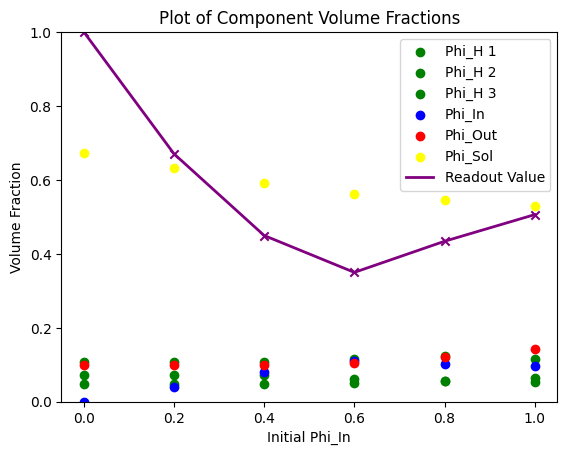

LOSS: 0.9782061449022523
IN BOUNDS
[[0.         6.06293449 4.43223695 4.65319773 6.52463925 0.        ]
 [6.06293449 0.         5.56416791 6.24661561 4.79195595 0.        ]
 [4.43223695 5.56416791 0.         6.305454   7.31417329 0.        ]
 [4.65319773 6.24661561 6.305454   0.         6.72145823 0.        ]
 [6.52463925 4.79195595 7.31417329 6.72145823 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.10835322 0.07199222 0.04726289 0.1        0.67239167]
 [0.04       0.10835322 0.07199222 0.04726289 0.1        0.63239167]
 [0.08       0.10835322 0.07199222 0.04726289 0.1        0.59239167]
 [0.12       0.10835322 0.07199222 0.04726289 0.1        0.55239167]
 [0.16       0.10835322 0.07199222 0.04726289 0.1        0.51239167]
 [0.2        0.10835322 0.07199222 0.04726289 0.1        0.47239167]]


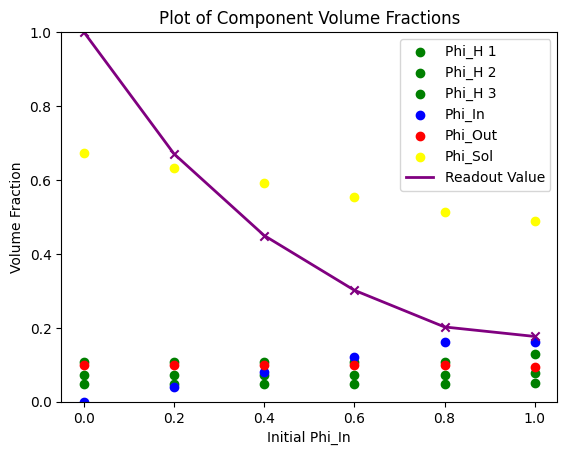

LOSS: 0.5744650219934458
IN BOUNDS
[[0.         3.87275586 4.93900596 4.15953883 5.19542906 0.        ]
 [3.87275586 0.         5.20226744 4.76044084 4.1859976  0.        ]
 [4.93900596 5.20226744 0.         4.72297386 5.52517008 0.        ]
 [4.15953883 4.76044084 4.72297386 0.         4.36665549 0.        ]
 [5.19542906 4.1859976  5.52517008 4.36665549 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.10836747 0.0720017  0.0472691  0.1        0.67236173]
 [0.04       0.10836747 0.0720017  0.0472691  0.1        0.63236173]
 [0.08       0.10836747 0.0720017  0.0472691  0.1        0.59236173]
 [0.12       0.10836747 0.0720017  0.0472691  0.1        0.55236173]
 [0.16       0.10836747 0.0720017  0.0472691  0.1        0.51236173]
 [0.2        0.10836747 0.0720017  0.0472691  0.1        0.47236173]]


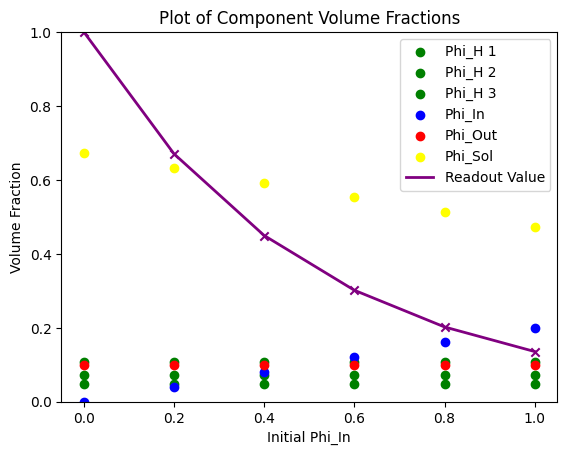

LOSS: 0.5617234519666876
IN BOUNDS
[[0.         4.95197654 4.94144992 5.57912789 4.97257421 0.        ]
 [4.95197654 0.         5.13907882 6.04243683 6.03585599 0.        ]
 [4.94144992 5.13907882 0.         6.48621872 6.59536857 0.        ]
 [5.57912789 6.04243683 6.48621872 0.         4.33055345 0.        ]
 [4.97257421 6.03585599 6.59536857 4.33055345 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.10836748 0.0720017  0.0472691  0.1        0.67236172]
 [0.04       0.10836748 0.0720017  0.0472691  0.1        0.63236172]
 [0.08       0.10836748 0.0720017  0.0472691  0.1        0.59236172]
 [0.12       0.10836748 0.0720017  0.0472691  0.1        0.55236172]
 [0.16       0.10836748 0.0720017  0.0472691  0.1        0.51236172]
 [0.2        0.10836748 0.0720017  0.0472691  0.1        0.47236172]]


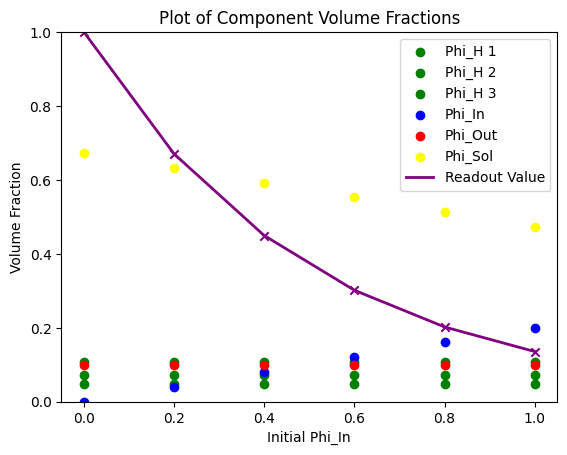

LOSS: 0.5617232755993521
IN BOUNDS
[[0.         5.99406416 5.76351062 4.15519745 4.36849611 0.        ]
 [5.99406416 0.         5.73736741 5.61273939 5.45396779 0.        ]
 [5.76351062 5.73736741 0.         6.79244647 5.30655137 0.        ]
 [4.15519745 5.61273939 6.79244647 0.         5.25177864 0.        ]
 [4.36849611 5.45396779 5.30655137 5.25177864 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.10836747 0.07200171 0.0472691  0.1        0.67236172]
 [0.04       0.10836747 0.07200171 0.0472691  0.1        0.63236172]
 [0.08       0.10836747 0.07200171 0.0472691  0.1        0.59236172]
 [0.12       0.10836747 0.07200171 0.0472691  0.1        0.55236172]
 [0.16       0.10836747 0.07200171 0.0472691  0.1        0.51236172]
 [0.2        0.10836747 0.07200171 0.0472691  0.1        0.47236172]]


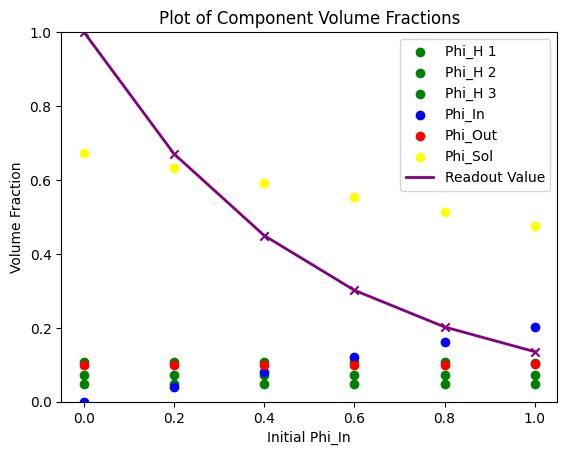

LOSS: 0.5616498525294809
IN BOUNDS
[[0.         6.27126065 5.77695178 6.08920077 4.73038568 0.        ]
 [6.27126065 0.         6.44134215 4.46530268 5.07756197 0.        ]
 [5.77695178 6.44134215 0.         5.1794893  4.49551156 0.        ]
 [6.08920077 4.46530268 5.1794893  0.         7.29939355 0.        ]
 [4.73038568 5.07756197 4.49551156 7.29939355 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.10836747 0.0720017  0.04726911 0.1        0.67236172]
 [0.04       0.10836747 0.0720017  0.04726911 0.1        0.63236172]
 [0.08       0.10836747 0.0720017  0.04726911 0.1        0.59236172]
 [0.12       0.10836747 0.0720017  0.04726911 0.1        0.55236172]
 [0.16       0.10836747 0.0720017  0.04726911 0.1        0.51236172]
 [0.2        0.10836747 0.0720017  0.04726911 0.1        0.47236172]]


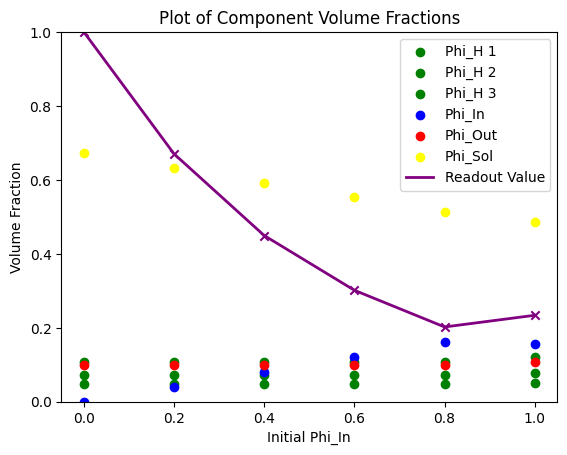

LOSS: 0.5979204635329315
IN BOUNDS
[[0.         5.7587042  5.96965139 5.21626996 3.7963173  0.        ]
 [5.7587042  0.         7.07197684 6.82564297 7.50617347 0.        ]
 [5.96965139 7.07197684 0.         7.49025598 5.87140421 0.        ]
 [5.21626996 6.82564297 7.49025598 0.         6.92437023 0.        ]
 [3.7963173  7.50617347 5.87140421 6.92437023 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.1083791  0.07200942 0.04727417 0.1        0.6723373 ]
 [0.04       0.1083791  0.07200942 0.04727417 0.1        0.6323373 ]
 [0.08       0.1083791  0.07200942 0.04727417 0.1        0.5923373 ]
 [0.12       0.1083791  0.07200942 0.04727417 0.1        0.5523373 ]
 [0.16       0.1083791  0.07200942 0.04727417 0.1        0.5123373 ]
 [0.2        0.1083791  0.07200942 0.04727417 0.1        0.4723373 ]]


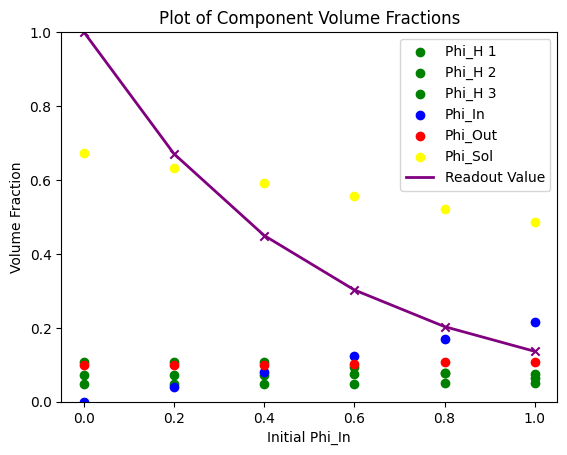

LOSS: 0.5627696016602709
IN BOUNDS
[[0.         4.74912446 6.26622972 6.88637222 4.96493811 0.        ]
 [4.74912446 0.         5.55340691 7.17160382 5.42838477 0.        ]
 [6.26622972 5.55340691 0.         5.65510273 6.23499594 0.        ]
 [6.88637222 7.17160382 5.65510273 0.         5.99243995 0.        ]
 [4.96493811 5.42838477 6.23499594 5.99243995 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.10837911 0.07200942 0.04727417 0.1        0.67233729]
 [0.04       0.10837911 0.07200942 0.04727417 0.1        0.63233729]
 [0.08       0.10837911 0.07200942 0.04727417 0.1        0.59233729]
 [0.12       0.10837911 0.07200942 0.04727417 0.1        0.55233729]
 [0.16       0.10837911 0.07200942 0.04727417 0.1        0.51233729]
 [0.2        0.10837911 0.07200942 0.04727417 0.1        0.47233729]]


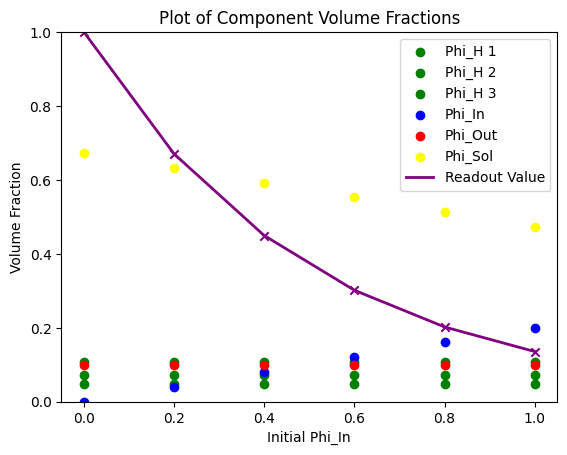

LOSS: 0.5617232697036387
IN BOUNDS
[[0.         6.36291623 5.50886749 4.67859259 5.5452321  0.        ]
 [6.36291623 0.         6.11976425 3.89212735 5.40541111 0.        ]
 [5.50886749 6.11976425 0.         6.968403   5.72103177 0.        ]
 [4.67859259 3.89212735 6.968403   0.         7.36434852 0.        ]
 [5.5452321  5.40541111 5.72103177 7.36434852 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.1083791  0.07200943 0.04727417 0.1        0.67233729]
 [0.04       0.1083791  0.07200943 0.04727417 0.1        0.63233729]
 [0.08       0.1083791  0.07200943 0.04727417 0.1        0.59233729]
 [0.12       0.1083791  0.07200943 0.04727417 0.1        0.55233729]
 [0.16       0.1083791  0.07200943 0.04727417 0.1        0.51233729]
 [0.2        0.1083791  0.07200943 0.04727417 0.1        0.47233729]]


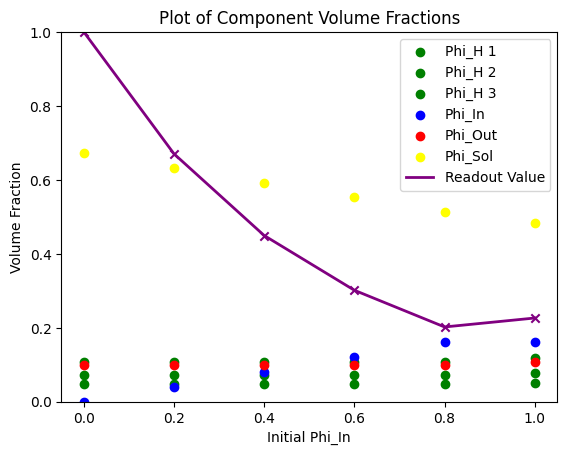

LOSS: 0.5945306746771699
IN BOUNDS
[[0.         6.46804801 7.79126094 5.02403251 5.95103019 0.        ]
 [6.46804801 0.         5.11551847 5.46697867 6.02163001 0.        ]
 [7.79126094 5.11551847 0.         6.29875565 7.10979672 0.        ]
 [5.02403251 5.46697867 6.29875565 0.         7.07049763 0.        ]
 [5.95103019 6.02163001 7.10979672 7.07049763 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.1083791  0.07200942 0.04727418 0.1        0.67233729]
 [0.04       0.1083791  0.07200942 0.04727418 0.1        0.63233729]
 [0.08       0.1083791  0.07200942 0.04727418 0.1        0.59233729]
 [0.12       0.1083791  0.07200942 0.04727418 0.1        0.55233729]
 [0.16       0.1083791  0.07200942 0.04727418 0.1        0.51233729]
 [0.2        0.1083791  0.07200942 0.04727418 0.1        0.47233729]]


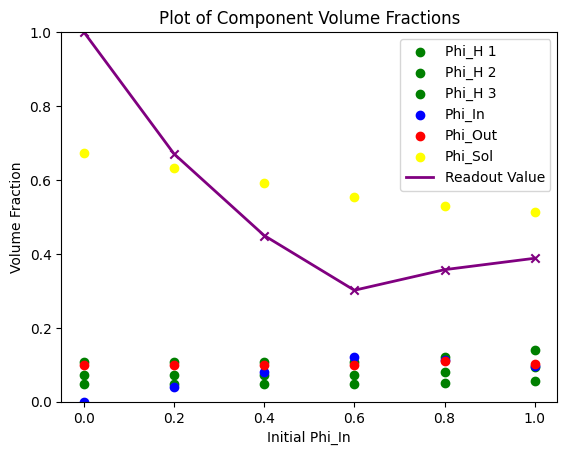

LOSS: 0.7803985128130821
IN BOUNDS
[[0.         5.31142301 6.68433175 4.21636625 6.18617965 0.        ]
 [5.31142301 0.         6.76730284 6.39649369 5.90587363 0.        ]
 [6.68433175 6.76730284 0.         5.59222412 6.84425195 0.        ]
 [4.21636625 6.39649369 5.59222412 0.         6.47554441 0.        ]
 [6.18617965 5.90587363 6.84425195 6.47554441 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.10838314 0.07201211 0.04727593 0.1        0.67232882]
 [0.04       0.10838314 0.07201211 0.04727593 0.1        0.63232882]
 [0.08       0.10838314 0.07201211 0.04727593 0.1        0.59232882]
 [0.12       0.10838314 0.07201211 0.04727593 0.1        0.55232882]
 [0.16       0.10838314 0.07201211 0.04727593 0.1        0.51232882]
 [0.2        0.10838314 0.07201211 0.04727593 0.1        0.47232882]]


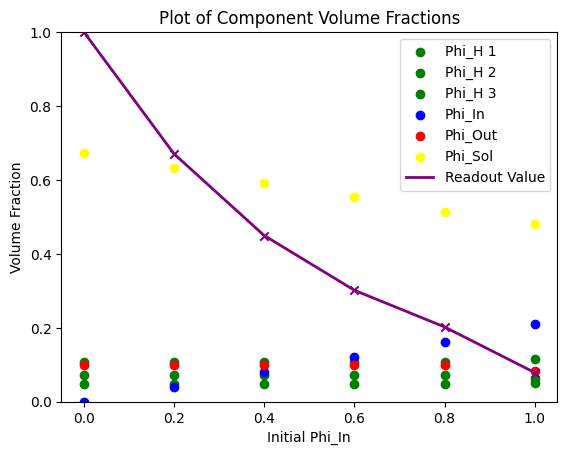

LOSS: 0.5495643861033364
IN BOUNDS
[[0.         5.86376472 6.41178428 6.0962158  7.56025166 0.        ]
 [5.86376472 0.         5.96261879 6.57835478 6.83024965 0.        ]
 [6.41178428 5.96261879 0.         4.37633996 6.62447347 0.        ]
 [6.0962158  6.57835478 4.37633996 0.         5.08192423 0.        ]
 [7.56025166 6.83024965 6.62447347 5.08192423 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.10838315 0.07201211 0.04727593 0.1        0.67232881]
 [0.04       0.10838315 0.07201211 0.04727593 0.1        0.63232881]
 [0.08       0.10838315 0.07201211 0.04727593 0.1        0.59232881]
 [0.12       0.10838315 0.07201211 0.04727593 0.1        0.55232881]
 [0.16       0.10838315 0.07201211 0.04727593 0.1        0.51232881]
 [0.2        0.10838315 0.07201211 0.04727593 0.1        0.47232881]]


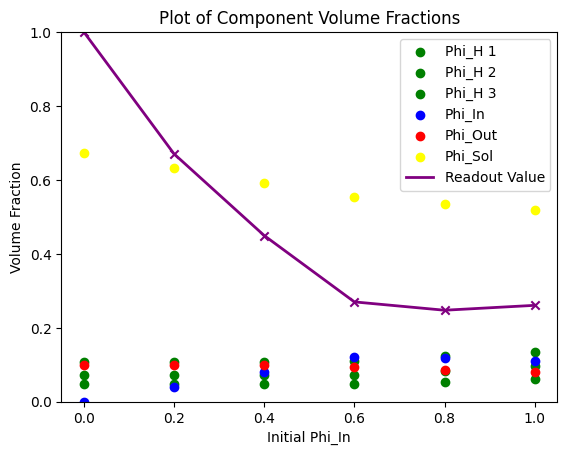

LOSS: 0.6135670824476092
IN BOUNDS
[[0.         5.3964607  7.29192691 6.07421031 4.50124049 0.        ]
 [5.3964607  0.         7.85288922 6.51990093 5.70225315 0.        ]
 [7.29192691 7.85288922 0.         7.38242593 6.42583193 0.        ]
 [6.07421031 6.51990093 7.38242593 0.         4.87548974 0.        ]
 [4.50124049 5.70225315 6.42583193 4.87548974 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.10838314 0.07201212 0.04727593 0.1        0.67232881]
 [0.04       0.10838314 0.07201212 0.04727593 0.1        0.63232881]
 [0.08       0.10838314 0.07201212 0.04727593 0.1        0.59232881]
 [0.12       0.10838314 0.07201212 0.04727593 0.1        0.55232881]
 [0.16       0.10838314 0.07201212 0.04727593 0.1        0.51232881]
 [0.2        0.10838314 0.07201212 0.04727593 0.1        0.47232881]]


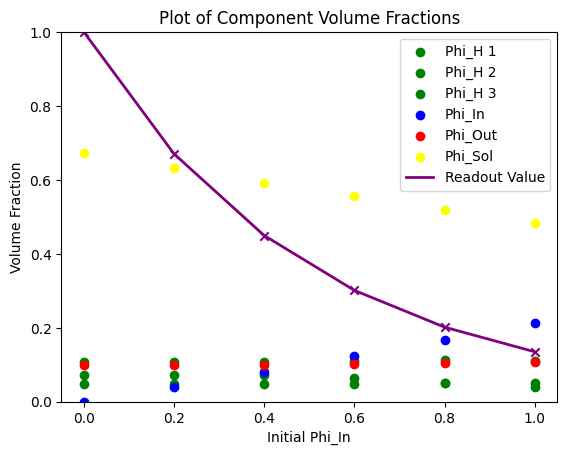

LOSS: 0.5611911404821135
IN BOUNDS
[[0.         7.31927173 6.93827073 5.97749946 6.63798133 0.        ]
 [7.31927173 0.         8.14838675 4.45278826 5.05596124 0.        ]
 [6.93827073 8.14838675 0.         3.80355036 6.21747732 0.        ]
 [5.97749946 4.45278826 3.80355036 0.         5.46020736 0.        ]
 [6.63798133 5.05596124 6.21747732 5.46020736 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.10838314 0.07201211 0.04727594 0.1        0.67232881]
 [0.04       0.10838314 0.07201211 0.04727594 0.1        0.63232881]
 [0.08       0.10838314 0.07201211 0.04727594 0.1        0.59232881]
 [0.12       0.10838314 0.07201211 0.04727594 0.1        0.55232881]
 [0.16       0.10838314 0.07201211 0.04727594 0.1        0.51232881]
 [0.2        0.10838314 0.07201211 0.04727594 0.1        0.47232881]]


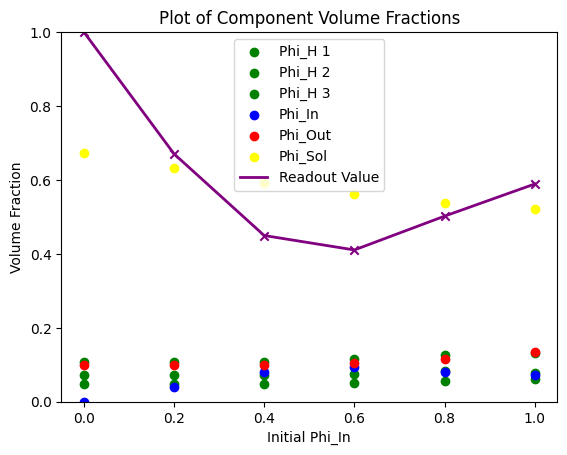

LOSS: 1.178566671202173
IN BOUNDS
[[0.         6.30491123 7.50829758 7.00182329 7.4105704  0.        ]
 [6.30491123 0.         5.10785188 5.93241594 4.70726011 0.        ]
 [7.50829758 5.10785188 0.         5.78870122 5.8345114  0.        ]
 [7.00182329 5.93241594 5.78870122 0.         5.49785107 0.        ]
 [7.4105704  4.70726011 5.8345114  5.49785107 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.10838438 0.07201293 0.04727647 0.1        0.67232622]
 [0.04       0.10838438 0.07201293 0.04727647 0.1        0.63232622]
 [0.08       0.10838438 0.07201293 0.04727647 0.1        0.59232622]
 [0.12       0.10838438 0.07201293 0.04727647 0.1        0.55232622]
 [0.16       0.10838438 0.07201293 0.04727647 0.1        0.51232622]
 [0.2        0.10838438 0.07201293 0.04727647 0.1        0.47232622]]


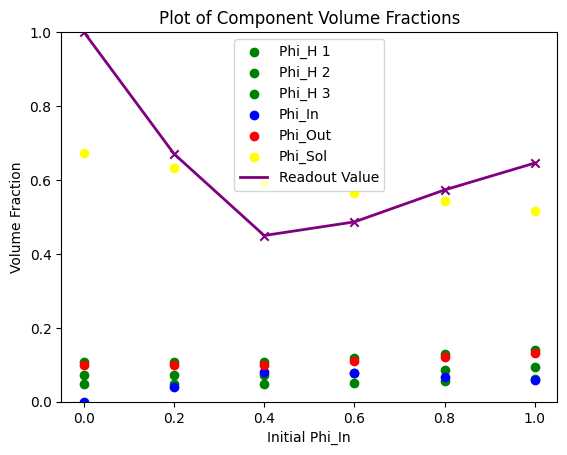

LOSS: 1.3926118360587678
IN BOUNDS
[[0.         5.77844728 4.73283502 5.84680772 6.15908372 0.        ]
 [5.77844728 0.         7.49866071 5.57425697 5.94223079 0.        ]
 [4.73283502 7.49866071 0.         4.92496149 5.55221444 0.        ]
 [5.84680772 5.57425697 4.92496149 0.         6.79730771 0.        ]
 [6.15908372 5.94223079 5.55221444 6.79730771 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.10838439 0.07201293 0.04727647 0.1        0.67232621]
 [0.04       0.10838439 0.07201293 0.04727647 0.1        0.63232621]
 [0.08       0.10838439 0.07201293 0.04727647 0.1        0.59232621]
 [0.12       0.10838439 0.07201293 0.04727647 0.1        0.55232621]
 [0.16       0.10838439 0.07201293 0.04727647 0.1        0.51232621]
 [0.2        0.10838439 0.07201293 0.04727647 0.1        0.47232621]]


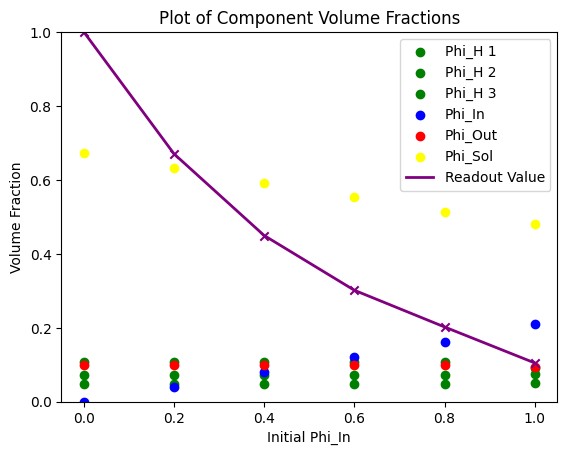

LOSS: 0.5543396231597579
IN BOUNDS
[[0.         5.84395504 6.68476042 5.2707964  7.2180998  0.        ]
 [5.84395504 0.         5.51108541 6.12594659 7.82542871 0.        ]
 [6.68476042 5.51108541 0.         6.8983265  7.45032521 0.        ]
 [5.2707964  6.12594659 6.8983265  0.         6.27872536 0.        ]
 [7.2180998  7.82542871 7.45032521 6.27872536 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.10838438 0.07201294 0.04727647 0.1        0.67232621]
 [0.04       0.10838438 0.07201294 0.04727647 0.1        0.63232621]
 [0.08       0.10838438 0.07201294 0.04727647 0.1        0.59232621]
 [0.12       0.10838438 0.07201294 0.04727647 0.1        0.55232621]
 [0.16       0.10838438 0.07201294 0.04727647 0.1        0.51232621]
 [0.2        0.10838438 0.07201294 0.04727647 0.1        0.47232621]]


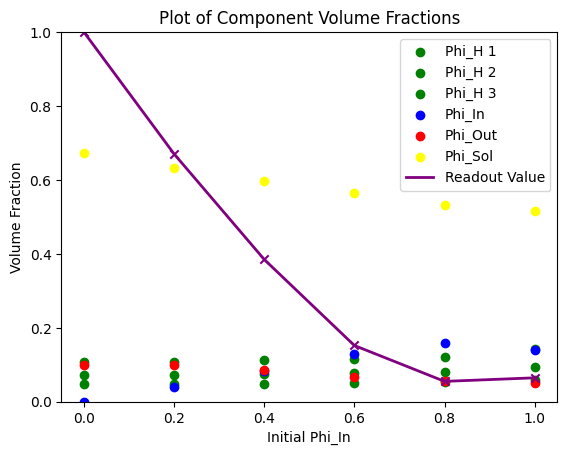

LOSS: 0.5175029426189645
IN BOUNDS
[[0.         5.23085978 4.21442665 6.7400616  4.88660035 0.        ]
 [5.23085978 0.         6.63497202 5.49155682 3.67547005 0.        ]
 [4.21442665 6.63497202 0.         5.54337384 5.80097562 0.        ]
 [6.7400616  5.49155682 5.54337384 0.         6.94820496 0.        ]
 [4.88660035 3.67547005 5.80097562 6.94820496 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.10838438 0.07201293 0.04727648 0.1        0.67232621]
 [0.04       0.10838438 0.07201293 0.04727648 0.1        0.63232621]
 [0.08       0.10838438 0.07201293 0.04727648 0.1        0.59232621]
 [0.12       0.10838438 0.07201293 0.04727648 0.1        0.55232621]
 [0.16       0.10838438 0.07201293 0.04727648 0.1        0.51232621]
 [0.2        0.10838438 0.07201293 0.04727648 0.1        0.47232621]]


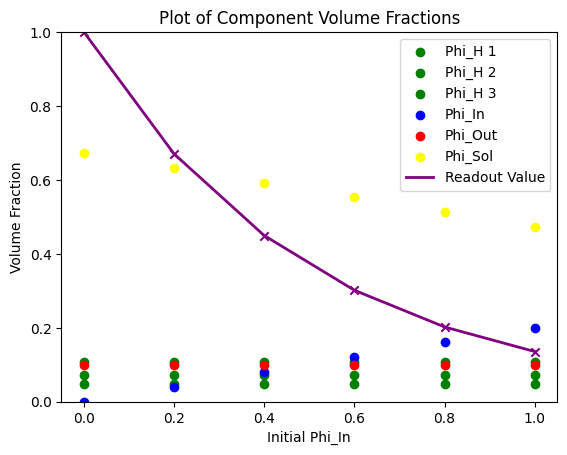

LOSS: 0.5617232764976983
IN BOUNDS
[[0.         4.92579294 6.05245303 6.08118752 5.18750329 0.        ]
 [4.92579294 0.         7.31111001 6.14974112 6.61791158 0.        ]
 [6.05245303 7.31111001 0.         5.87471028 6.74075129 0.        ]
 [6.08118752 6.14974112 5.87471028 0.         7.28314656 0.        ]
 [5.18750329 6.61791158 6.74075129 7.28314656 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.10838452 0.07201302 0.04727654 0.1        0.67232592]
 [0.04       0.10838452 0.07201302 0.04727654 0.1        0.63232592]
 [0.08       0.10838452 0.07201302 0.04727654 0.1        0.59232592]
 [0.12       0.10838452 0.07201302 0.04727654 0.1        0.55232592]
 [0.16       0.10838452 0.07201302 0.04727654 0.1        0.51232592]
 [0.2        0.10838452 0.07201302 0.04727654 0.1        0.47232592]]


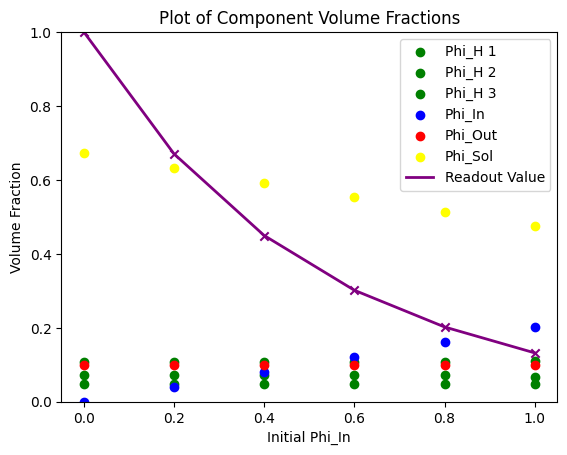

LOSS: 0.5607645086541536
IN BOUNDS
[[0.         6.31604482 4.90600686 3.78357602 7.2012941  0.        ]
 [6.31604482 0.         4.9332993  6.9296713  5.1246361  0.        ]
 [4.90600686 4.9332993  0.         6.6170527  5.90829302 0.        ]
 [3.78357602 6.9296713  6.6170527  0.         6.43161085 0.        ]
 [7.2012941  5.1246361  5.90829302 6.43161085 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.10838453 0.07201302 0.04727654 0.1        0.67232591]
 [0.04       0.10838453 0.07201302 0.04727654 0.1        0.63232591]
 [0.08       0.10838453 0.07201302 0.04727654 0.1        0.59232591]
 [0.12       0.10838453 0.07201302 0.04727654 0.1        0.55232591]
 [0.16       0.10838453 0.07201302 0.04727654 0.1        0.51232591]
 [0.2        0.10838453 0.07201302 0.04727654 0.1        0.47232591]]


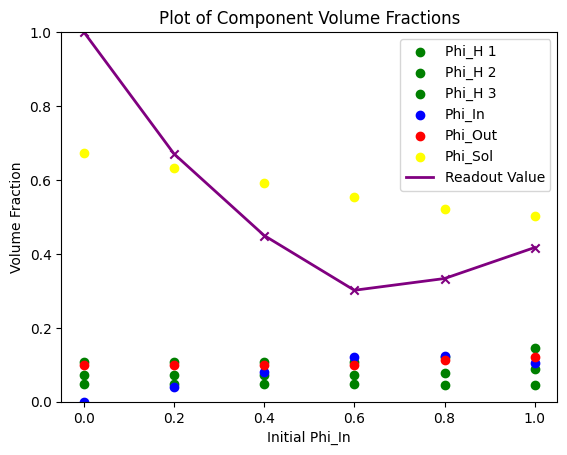

LOSS: 0.7872953690761975
IN BOUNDS
[[0.         6.09870477 6.60755039 5.28299557 6.11518527 0.        ]
 [6.09870477 0.         6.3886726  5.82577859 4.71646255 0.        ]
 [6.60755039 6.3886726  0.         4.50377972 6.96484278 0.        ]
 [5.28299557 5.82577859 4.50377972 0.         6.42311191 0.        ]
 [6.11518527 4.71646255 6.96484278 6.42311191 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.10838452 0.07201303 0.04727654 0.1        0.67232591]
 [0.04       0.10838452 0.07201303 0.04727654 0.1        0.63232591]
 [0.08       0.10838452 0.07201303 0.04727654 0.1        0.59232591]
 [0.12       0.10838452 0.07201303 0.04727654 0.1        0.55232591]
 [0.16       0.10838452 0.07201303 0.04727654 0.1        0.51232591]
 [0.2        0.10838452 0.07201303 0.04727654 0.1        0.47232591]]


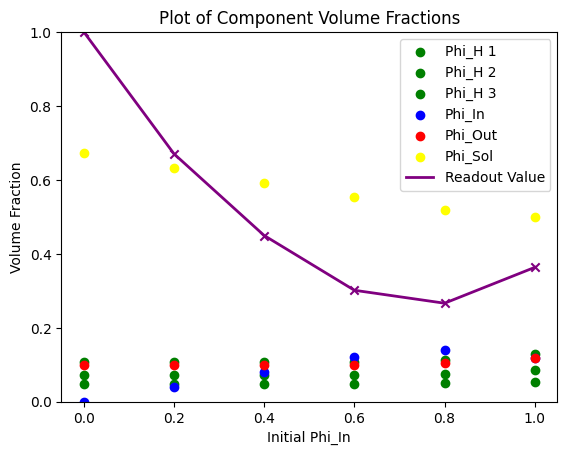

LOSS: 0.7053485697314779
IN BOUNDS
[[0.         7.09249888 5.19363813 6.17679279 7.58454518 0.        ]
 [7.09249888 0.         6.19682755 5.43023653 7.34893417 0.        ]
 [5.19363813 6.19682755 0.         4.71250261 5.64035477 0.        ]
 [6.17679279 5.43023653 4.71250261 0.         4.70923134 0.        ]
 [7.58454518 7.34893417 5.64035477 4.70923134 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.10838452 0.07201302 0.04727655 0.1        0.67232591]
 [0.04       0.10838452 0.07201302 0.04727655 0.1        0.63232591]
 [0.08       0.10838452 0.07201302 0.04727655 0.1        0.59232591]
 [0.12       0.10838452 0.07201302 0.04727655 0.1        0.55232591]
 [0.16       0.10838452 0.07201302 0.04727655 0.1        0.51232591]
 [0.2        0.10838452 0.07201302 0.04727655 0.1        0.47232591]]


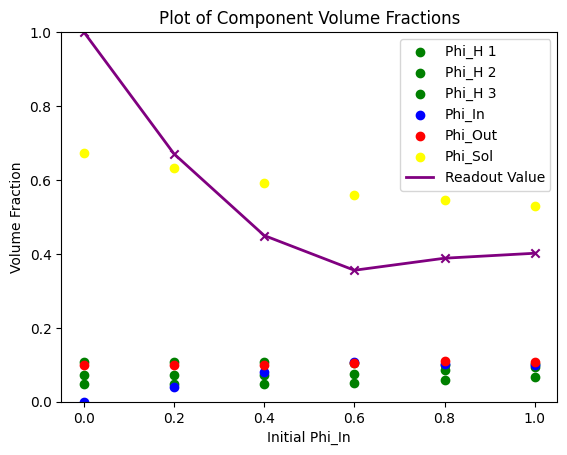

LOSS: 0.8497155948447872
IN BOUNDS
[[0.         7.45318846 6.04943877 5.67642139 3.62391218 0.        ]
 [7.45318846 0.         6.33645837 6.76965215 5.66372664 0.        ]
 [6.04943877 6.33645837 0.         4.97943782 7.79853547 0.        ]
 [5.67642139 6.76965215 4.97943782 0.         5.51607321 0.        ]
 [3.62391218 5.66372664 7.79853547 5.51607321 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.10838444 0.07201297 0.0472765  0.1        0.6723261 ]
 [0.04       0.10838444 0.07201297 0.0472765  0.1        0.6323261 ]
 [0.08       0.10838444 0.07201297 0.0472765  0.1        0.5923261 ]
 [0.12       0.10838444 0.07201297 0.0472765  0.1        0.5523261 ]
 [0.16       0.10838444 0.07201297 0.0472765  0.1        0.5123261 ]
 [0.2        0.10838444 0.07201297 0.0472765  0.1        0.4723261 ]]


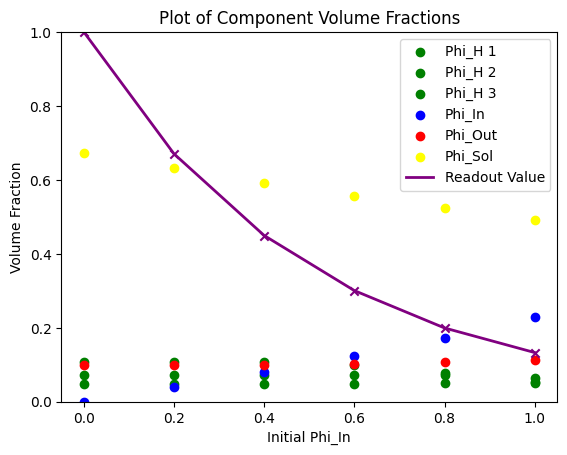

LOSS: 0.5593488380462645
IN BOUNDS
[[0.         4.76203617 7.8973741  6.12721846 5.3711814  0.        ]
 [4.76203617 0.         7.62356866 4.86049728 7.0182931  0.        ]
 [7.8973741  7.62356866 0.         7.53353387 4.64901036 0.        ]
 [6.12721846 4.86049728 7.53353387 0.         6.52496748 0.        ]
 [5.3711814  7.0182931  4.64901036 6.52496748 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.10838445 0.07201297 0.0472765  0.1        0.67232609]
 [0.04       0.10838445 0.07201297 0.0472765  0.1        0.63232609]
 [0.08       0.10838445 0.07201297 0.0472765  0.1        0.59232609]
 [0.12       0.10838445 0.07201297 0.0472765  0.1        0.55232609]
 [0.16       0.10838445 0.07201297 0.0472765  0.1        0.51232609]
 [0.2        0.10838445 0.07201297 0.0472765  0.1        0.47232609]]


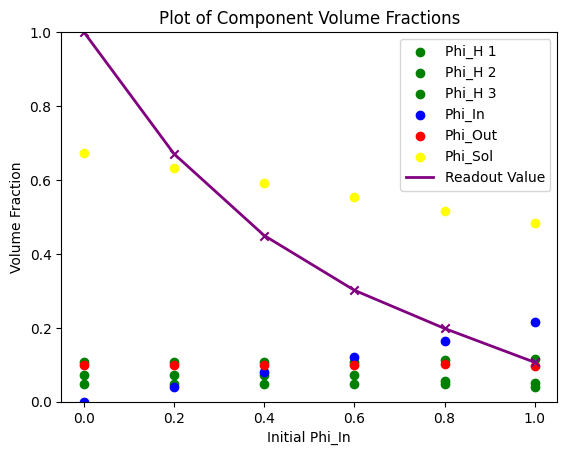

LOSS: 0.5530924459595808
IN BOUNDS
[[0.         6.37216706 7.84219285 5.49665421 3.94944464 0.        ]
 [6.37216706 0.         6.22276961 4.69023083 4.87425733 0.        ]
 [7.84219285 6.22276961 0.         5.52994699 4.62881883 0.        ]
 [5.49665421 4.69023083 5.52994699 0.         5.89466807 0.        ]
 [3.94944464 4.87425733 4.62881883 5.89466807 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.10838444 0.07201298 0.0472765  0.1        0.67232609]
 [0.04       0.10838444 0.07201298 0.0472765  0.1        0.63232609]
 [0.08       0.10838444 0.07201298 0.0472765  0.1        0.59232609]
 [0.12       0.10838444 0.07201298 0.0472765  0.1        0.55232609]
 [0.16       0.10838444 0.07201298 0.0472765  0.1        0.51232609]
 [0.2        0.10838444 0.07201298 0.0472765  0.1        0.47232609]]


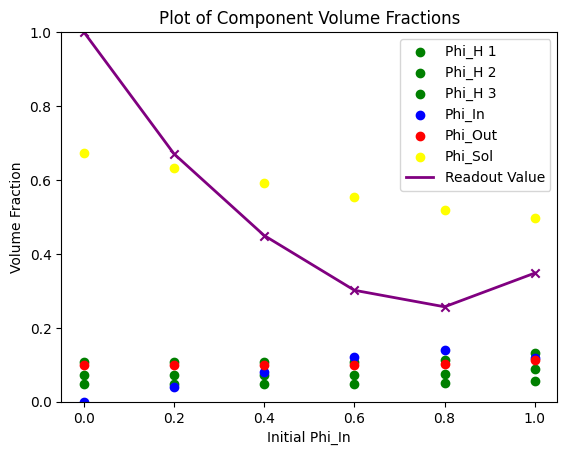

LOSS: 0.6892533098970922
IN BOUNDS
[[0.         4.67291262 5.69893475 6.02260661 6.03443914 0.        ]
 [4.67291262 0.         7.0052821  5.8256291  6.06773087 0.        ]
 [5.69893475 7.0052821  0.         7.48148827 3.36047493 0.        ]
 [6.02260661 5.8256291  7.48148827 0.         6.29321209 0.        ]
 [6.03443914 6.06773087 3.36047493 6.29321209 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.10838444 0.07201297 0.04727651 0.1        0.67232609]
 [0.04       0.10838444 0.07201297 0.04727651 0.1        0.63232609]
 [0.08       0.10838444 0.07201297 0.04727651 0.1        0.59232609]
 [0.12       0.10838444 0.07201297 0.04727651 0.1        0.55232609]
 [0.16       0.10838444 0.07201297 0.04727651 0.1        0.51232609]
 [0.2        0.10838444 0.07201297 0.04727651 0.1        0.47232609]]


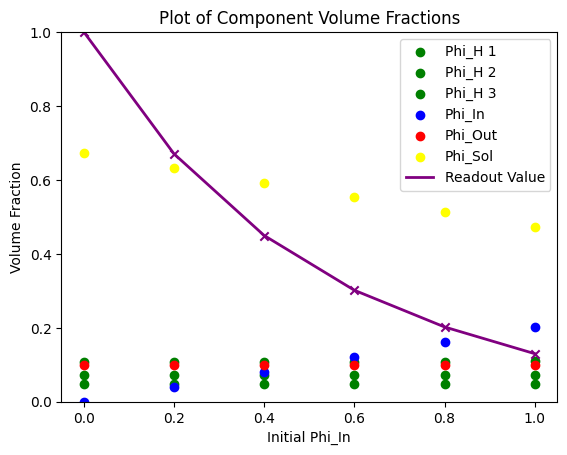

LOSS: 0.5602085666889413
IN BOUNDS
[[0.         5.12903713 5.51215094 5.54429455 6.25418685 0.        ]
 [5.12903713 0.         3.93493064 7.07746216 6.74164168 0.        ]
 [5.51215094 3.93493064 0.         6.57203818 6.58556079 0.        ]
 [5.54429455 7.07746216 6.57203818 0.         6.89700311 0.        ]
 [6.25418685 6.74164168 6.58556079 6.89700311 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.10838425 0.0720128  0.04727645 0.1        0.6723265 ]
 [0.04       0.10838425 0.0720128  0.04727645 0.1        0.6323265 ]
 [0.08       0.10838425 0.0720128  0.04727645 0.1        0.5923265 ]
 [0.12       0.10838425 0.0720128  0.04727645 0.1        0.5523265 ]
 [0.16       0.10838425 0.0720128  0.04727645 0.1        0.5123265 ]
 [0.2        0.10838425 0.0720128  0.04727645 0.1        0.4723265 ]]


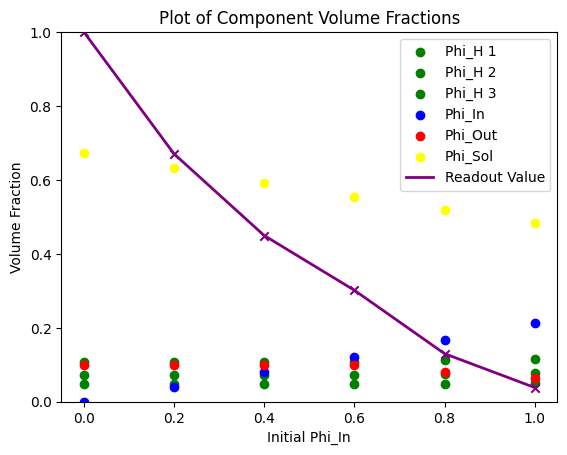

LOSS: 0.5208962222574629
IN BOUNDS
[[0.         5.05869131 6.484066   5.89226956 5.20721027 0.        ]
 [5.05869131 0.         7.53947199 6.10718925 4.94764026 0.        ]
 [6.484066   7.53947199 0.         5.09183477 6.76203939 0.        ]
 [5.89226956 6.10718925 5.09183477 0.         6.53521201 0.        ]
 [5.20721027 4.94764026 6.76203939 6.53521201 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.10838426 0.0720128  0.04727645 0.1        0.67232649]
 [0.04       0.10838426 0.0720128  0.04727645 0.1        0.63232649]
 [0.08       0.10838426 0.0720128  0.04727645 0.1        0.59232649]
 [0.12       0.10838426 0.0720128  0.04727645 0.1        0.55232649]
 [0.16       0.10838426 0.0720128  0.04727645 0.1        0.51232649]
 [0.2        0.10838426 0.0720128  0.04727645 0.1        0.47232649]]


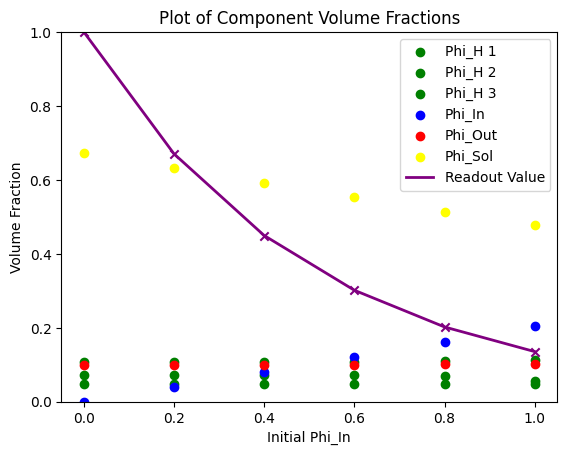

LOSS: 0.5616749655319965
IN BOUNDS
[[0.         6.11009629 6.64271107 6.36124812 3.7074693  0.        ]
 [6.11009629 0.         4.61480665 4.86684435 4.79121731 0.        ]
 [6.64271107 4.61480665 0.         5.02135406 7.58539151 0.        ]
 [6.36124812 4.86684435 5.02135406 0.         7.08552806 0.        ]
 [3.7074693  4.79121731 7.58539151 7.08552806 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.10838425 0.07201281 0.04727645 0.1        0.67232649]
 [0.04       0.10838425 0.07201281 0.04727645 0.1        0.63232649]
 [0.08       0.10838425 0.07201281 0.04727645 0.1        0.59232649]
 [0.12       0.10838425 0.07201281 0.04727645 0.1        0.55232649]
 [0.16       0.10838425 0.07201281 0.04727645 0.1        0.51232649]
 [0.2        0.10838425 0.07201281 0.04727645 0.1        0.47232649]]


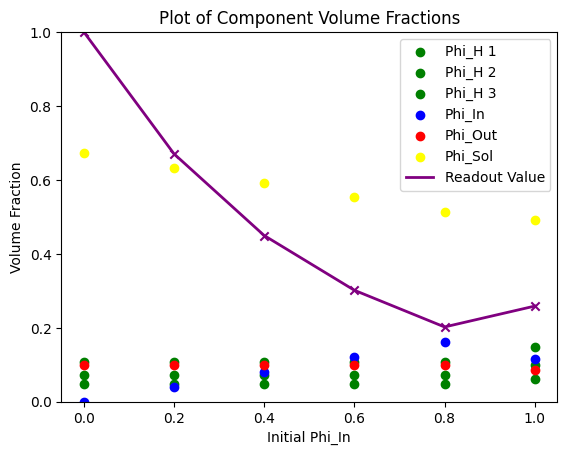

LOSS: 0.610160614572225
IN BOUNDS
[[0.         5.62103821 7.0829302  7.29864459 7.27310676 0.        ]
 [5.62103821 0.         6.41794837 6.56733031 6.36405507 0.        ]
 [7.0829302  6.41794837 0.         5.79598827 6.39925592 0.        ]
 [7.29864459 6.56733031 5.79598827 0.         6.66281583 0.        ]
 [7.27310676 6.36405507 6.39925592 6.66281583 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.10838425 0.0720128  0.04727646 0.1        0.67232649]
 [0.04       0.10838425 0.0720128  0.04727646 0.1        0.63232649]
 [0.08       0.10838425 0.0720128  0.04727646 0.1        0.59232649]
 [0.12       0.10838425 0.0720128  0.04727646 0.1        0.55232649]
 [0.16       0.10838425 0.0720128  0.04727646 0.1        0.51232649]
 [0.2        0.10838425 0.0720128  0.04727646 0.1        0.47232649]]


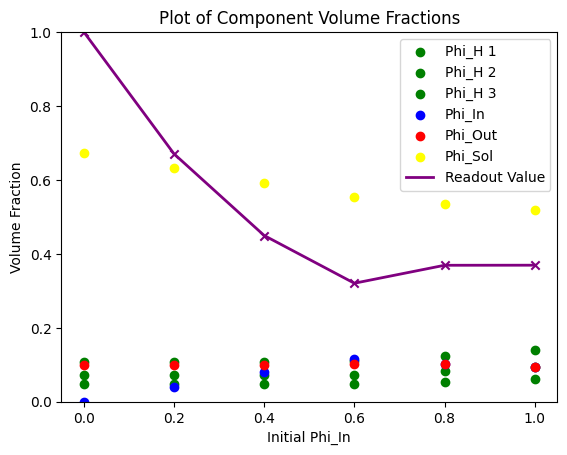

LOSS: 0.7866401725213428
IN BOUNDS
[[0.         5.23755379 6.46750919 7.31276023 6.41552146 0.        ]
 [5.23755379 0.         7.47823223 6.31394119 5.83483039 0.        ]
 [6.46750919 7.47823223 0.         6.25810117 6.44045592 0.        ]
 [7.31276023 6.31394119 6.25810117 0.         4.47365773 0.        ]
 [6.41552146 5.83483039 6.44045592 4.47365773 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.10838351 0.07201214 0.04727626 0.1        0.67232809]
 [0.04       0.10838351 0.07201214 0.04727626 0.1        0.63232809]
 [0.08       0.10838351 0.07201214 0.04727626 0.1        0.59232809]
 [0.12       0.10838351 0.07201214 0.04727626 0.1        0.55232809]
 [0.16       0.10838351 0.07201214 0.04727626 0.1        0.51232809]
 [0.2        0.10838351 0.07201214 0.04727626 0.1        0.47232809]]


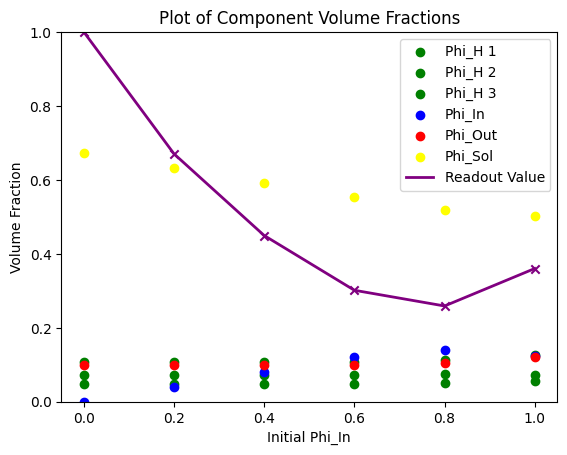

LOSS: 0.6991398416076644
IN BOUNDS
[[0.         5.20958671 6.78666055 6.46137667 4.91640846 0.        ]
 [5.20958671 0.         8.30940619 5.55837664 7.358422   0.        ]
 [6.78666055 8.30940619 0.         7.48701344 5.55519021 0.        ]
 [6.46137667 5.55837664 7.48701344 0.         6.61667795 0.        ]
 [4.91640846 7.358422   5.55519021 6.61667795 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.10838352 0.07201214 0.04727626 0.1        0.67232808]
 [0.04       0.10838352 0.07201214 0.04727626 0.1        0.63232808]
 [0.08       0.10838352 0.07201214 0.04727626 0.1        0.59232808]
 [0.12       0.10838352 0.07201214 0.04727626 0.1        0.55232808]
 [0.16       0.10838352 0.07201214 0.04727626 0.1        0.51232808]
 [0.2        0.10838352 0.07201214 0.04727626 0.1        0.47232808]]


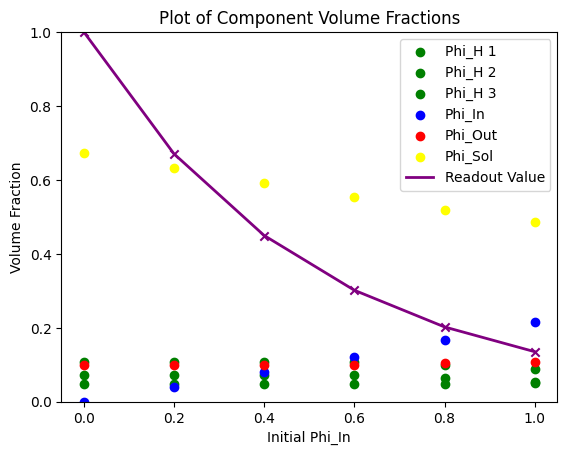

LOSS: 0.5616312765422121
IN BOUNDS
[[0.         5.73875822 4.04766593 6.37096232 6.52162446 0.        ]
 [5.73875822 0.         5.72947052 6.13764579 7.33185112 0.        ]
 [4.04766593 5.72947052 0.         4.1812983  5.68425955 0.        ]
 [6.37096232 6.13764579 4.1812983  0.         5.64311223 0.        ]
 [6.52162446 7.33185112 5.68425955 5.64311223 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.10838351 0.07201215 0.04727626 0.1        0.67232808]
 [0.04       0.10838351 0.07201215 0.04727626 0.1        0.63232808]
 [0.08       0.10838351 0.07201215 0.04727626 0.1        0.59232808]
 [0.12       0.10838351 0.07201215 0.04727626 0.1        0.55232808]
 [0.16       0.10838351 0.07201215 0.04727626 0.1        0.51232808]
 [0.2        0.10838351 0.07201215 0.04727626 0.1        0.47232808]]


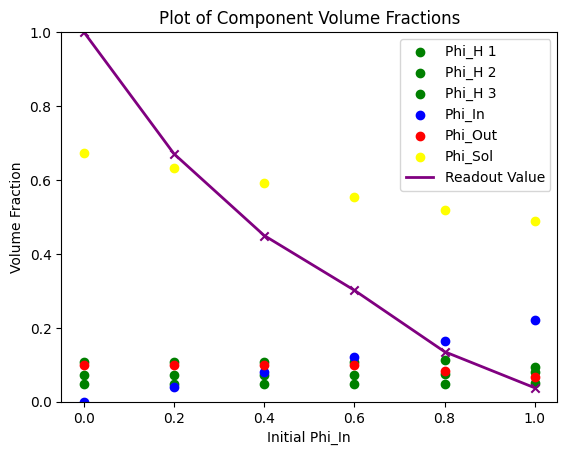

LOSS: 0.5222575416589158
IN BOUNDS
[[0.         6.52510512 4.51056649 5.232686   5.75545614 0.        ]
 [6.52510512 0.         4.15714875 7.43132035 6.51077259 0.        ]
 [4.51056649 4.15714875 0.         3.74579731 3.84236723 0.        ]
 [5.232686   7.43132035 3.74579731 0.         6.50582233 0.        ]
 [5.75545614 6.51077259 3.84236723 6.50582233 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.10838351 0.07201214 0.04727627 0.1        0.67232808]
 [0.04       0.10838351 0.07201214 0.04727627 0.1        0.63232808]
 [0.08       0.10838351 0.07201214 0.04727627 0.1        0.59232808]
 [0.12       0.10838351 0.07201214 0.04727627 0.1        0.55232808]
 [0.16       0.10838351 0.07201214 0.04727627 0.1        0.51232808]
 [0.2        0.10838351 0.07201214 0.04727627 0.1        0.47232808]]


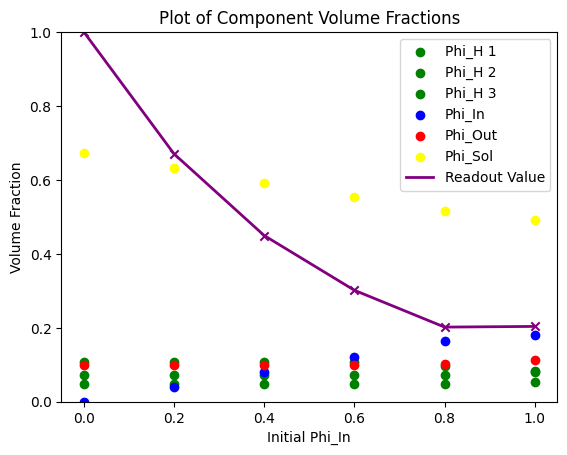

LOSS: 0.5846262814787487
IN BOUNDS
[[0.         5.41822554 7.67331582 5.12774942 5.634448   0.        ]
 [5.41822554 0.         5.84447533 4.90733833 6.2628823  0.        ]
 [7.67331582 5.84447533 0.         5.66524422 5.56025065 0.        ]
 [5.12774942 4.90733833 5.66524422 0.         4.6353659  0.        ]
 [5.634448   6.2628823  5.56025065 4.6353659  0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.10838386 0.07201245 0.04727635 0.1        0.67232733]
 [0.04       0.10838386 0.07201245 0.04727635 0.1        0.63232733]
 [0.08       0.10838386 0.07201245 0.04727635 0.1        0.59232733]
 [0.12       0.10838386 0.07201245 0.04727635 0.1        0.55232733]
 [0.16       0.10838386 0.07201245 0.04727635 0.1        0.51232733]
 [0.2        0.10838386 0.07201245 0.04727635 0.1        0.47232733]]


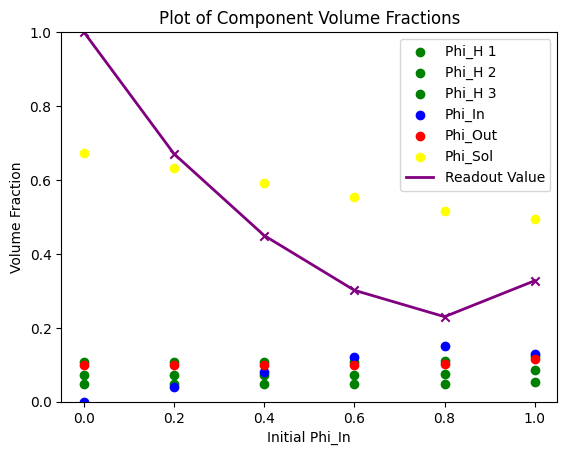

LOSS: 0.6623217548899676
IN BOUNDS
[[0.         4.38729684 6.19116463 5.02047851 5.13815048 0.        ]
 [4.38729684 0.         6.07191021 6.53836769 5.45836137 0.        ]
 [6.19116463 6.07191021 0.         6.47554833 7.816386   0.        ]
 [5.02047851 6.53836769 6.47554833 0.         6.49824748 0.        ]
 [5.13815048 5.45836137 7.816386   6.49824748 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.10838387 0.07201245 0.04727635 0.1        0.67232732]
 [0.04       0.10838387 0.07201245 0.04727635 0.1        0.63232732]
 [0.08       0.10838387 0.07201245 0.04727635 0.1        0.59232732]
 [0.12       0.10838387 0.07201245 0.04727635 0.1        0.55232732]
 [0.16       0.10838387 0.07201245 0.04727635 0.1        0.51232732]
 [0.2        0.10838387 0.07201245 0.04727635 0.1        0.47232732]]


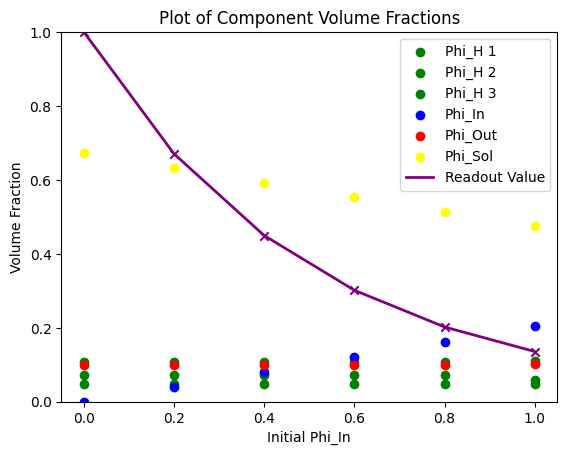

LOSS: 0.5617448891159902
IN BOUNDS
[[0.         7.70329842 7.8943114  6.78615517 5.58121822 0.        ]
 [7.70329842 0.         6.22067516 6.89068282 5.46358315 0.        ]
 [7.8943114  6.22067516 0.         6.30750125 4.37514052 0.        ]
 [6.78615517 6.89068282 6.30750125 0.         6.39277613 0.        ]
 [5.58121822 5.46358315 4.37514052 6.39277613 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.10838386 0.07201246 0.04727635 0.1        0.67232732]
 [0.04       0.10838386 0.07201246 0.04727635 0.1        0.63232732]
 [0.08       0.10838386 0.07201246 0.04727635 0.1        0.59232732]
 [0.12       0.10838386 0.07201246 0.04727635 0.1        0.55232732]
 [0.16       0.10838386 0.07201246 0.04727635 0.1        0.51232732]
 [0.2        0.10838386 0.07201246 0.04727635 0.1        0.47232732]]


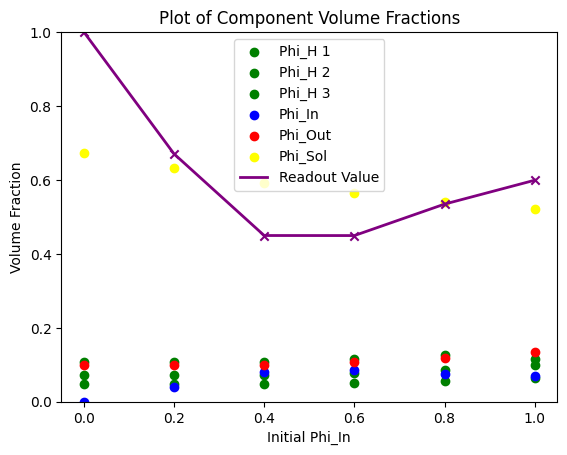

LOSS: 1.2578687112336822
IN BOUNDS
[[0.         5.97476547 6.6527469  6.69364291 7.47189255 0.        ]
 [5.97476547 0.         3.72259933 8.2752546  5.98514913 0.        ]
 [6.6527469  3.72259933 0.         6.05827404 3.77670584 0.        ]
 [6.69364291 8.2752546  6.05827404 0.         5.74251825 0.        ]
 [7.47189255 5.98514913 3.77670584 5.74251825 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.10838386 0.07201245 0.04727636 0.1        0.67232732]
 [0.04       0.10838386 0.07201245 0.04727636 0.1        0.63232732]
 [0.08       0.10838386 0.07201245 0.04727636 0.1        0.59232732]
 [0.12       0.10838386 0.07201245 0.04727636 0.1        0.55232732]
 [0.16       0.10838386 0.07201245 0.04727636 0.1        0.51232732]
 [0.2        0.10838386 0.07201245 0.04727636 0.1        0.47232732]]


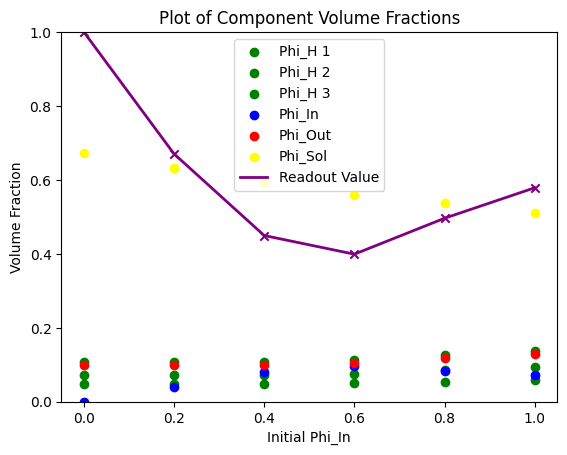

LOSS: 1.1517163939648867
IN BOUNDS
[[0.         5.15571265 7.26218182 6.74781742 5.35869427 0.        ]
 [5.15571265 0.         6.35741461 7.02216118 7.09267742 0.        ]
 [7.26218182 6.35741461 0.         7.57062683 5.90714199 0.        ]
 [6.74781742 7.02216118 7.57062683 0.         7.24794507 0.        ]
 [5.35869427 7.09267742 5.90714199 7.24794507 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.10838421 0.07201276 0.04727644 0.1        0.67232659]
 [0.04       0.10838421 0.07201276 0.04727644 0.1        0.63232659]
 [0.08       0.10838421 0.07201276 0.04727644 0.1        0.59232659]
 [0.12       0.10838421 0.07201276 0.04727644 0.1        0.55232659]
 [0.16       0.10838421 0.07201276 0.04727644 0.1        0.51232659]
 [0.2        0.10838421 0.07201276 0.04727644 0.1        0.47232659]]


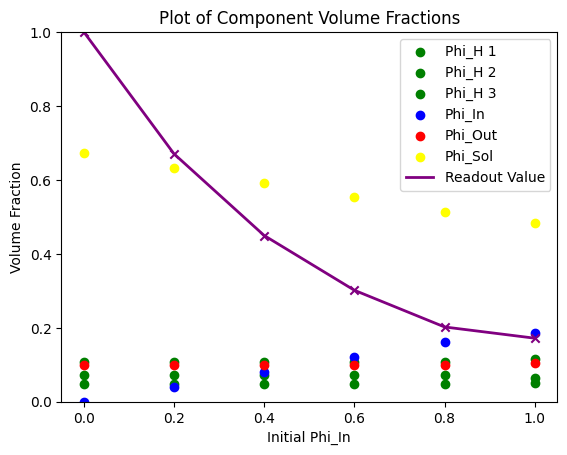

LOSS: 0.5728190420393624
IN BOUNDS
[[0.         5.01187494 5.33340918 5.10761912 6.99084013 0.        ]
 [5.01187494 0.         7.6006292  5.52647827 5.45697296 0.        ]
 [5.33340918 7.6006292  0.         4.92301331 4.88416477 0.        ]
 [5.10761912 5.52647827 4.92301331 0.         6.79032314 0.        ]
 [6.99084013 5.45697296 4.88416477 6.79032314 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.10838422 0.07201276 0.04727644 0.1        0.67232658]
 [0.04       0.10838422 0.07201276 0.04727644 0.1        0.63232658]
 [0.08       0.10838422 0.07201276 0.04727644 0.1        0.59232658]
 [0.12       0.10838422 0.07201276 0.04727644 0.1        0.55232658]
 [0.16       0.10838422 0.07201276 0.04727644 0.1        0.51232658]
 [0.2        0.10838422 0.07201276 0.04727644 0.1        0.47232658]]


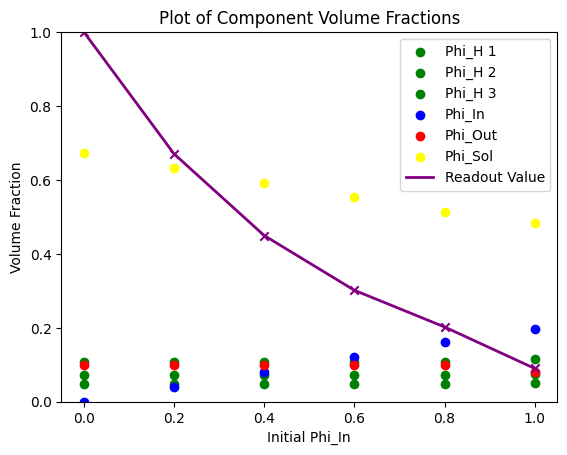

LOSS: 0.5514296619630475
IN BOUNDS
[[0.         6.3523742  5.56106803 5.17518433 6.23192242 0.        ]
 [6.3523742  0.         7.13599102 6.88335857 5.33396841 0.        ]
 [5.56106803 7.13599102 0.         5.94052592 6.69795716 0.        ]
 [5.17518433 6.88335857 5.94052592 0.         6.16302959 0.        ]
 [6.23192242 5.33396841 6.69795716 6.16302959 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.10838421 0.07201277 0.04727644 0.1        0.67232658]
 [0.04       0.10838421 0.07201277 0.04727644 0.1        0.63232658]
 [0.08       0.10838421 0.07201277 0.04727644 0.1        0.59232658]
 [0.12       0.10838421 0.07201277 0.04727644 0.1        0.55232658]
 [0.16       0.10838421 0.07201277 0.04727644 0.1        0.51232658]
 [0.2        0.10838421 0.07201277 0.04727644 0.1        0.47232658]]


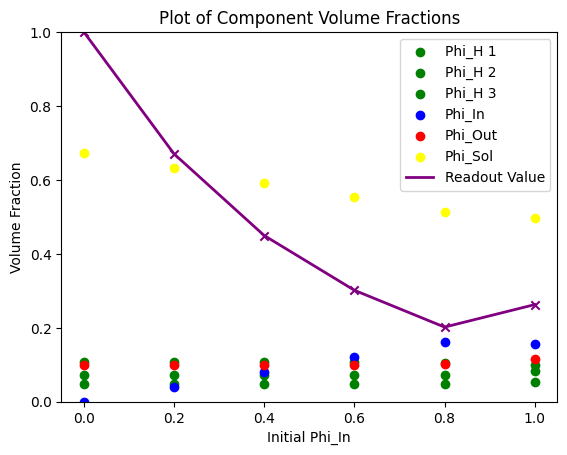

LOSS: 0.6121007475410746
IN BOUNDS
[[0.         6.45401889 6.78384798 6.2596948  6.5549702  0.        ]
 [6.45401889 0.         5.05355933 2.50590076 5.99758761 0.        ]
 [6.78384798 5.05355933 0.         5.17174454 6.02711295 0.        ]
 [6.2596948  2.50590076 5.17174454 0.         6.8291731  0.        ]
 [6.5549702  5.99758761 6.02711295 6.8291731  0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.10838421 0.07201276 0.04727645 0.1        0.67232658]
 [0.04       0.10838421 0.07201276 0.04727645 0.1        0.63232658]
 [0.08       0.10838421 0.07201276 0.04727645 0.1        0.59232658]
 [0.12       0.10838421 0.07201276 0.04727645 0.1        0.55232658]
 [0.16       0.10838421 0.07201276 0.04727645 0.1        0.51232658]
 [0.2        0.10838421 0.07201276 0.04727645 0.1        0.47232658]]


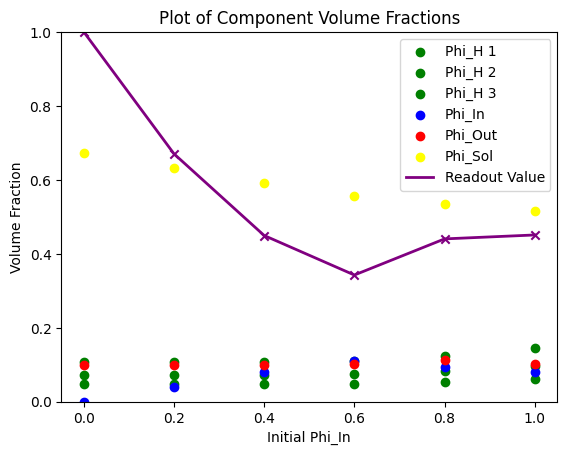

LOSS: 0.926175722814223
IN BOUNDS
[[0.         7.06430306 6.0858272  6.49033471 5.32818073 0.        ]
 [7.06430306 0.         6.38426922 6.15722806 5.94964606 0.        ]
 [6.0858272  6.38426922 0.         7.65690429 5.53275265 0.        ]
 [6.49033471 6.15722806 7.65690429 0.         5.87983508 0.        ]
 [5.32818073 5.94964606 5.53275265 5.87983508 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.10838424 0.07201279 0.04727645 0.1        0.67232652]
 [0.04       0.10838424 0.07201279 0.04727645 0.1        0.63232652]
 [0.08       0.10838424 0.07201279 0.04727645 0.1        0.59232652]
 [0.12       0.10838424 0.07201279 0.04727645 0.1        0.55232652]
 [0.16       0.10838424 0.07201279 0.04727645 0.1        0.51232652]
 [0.2        0.10838424 0.07201279 0.04727645 0.1        0.47232652]]


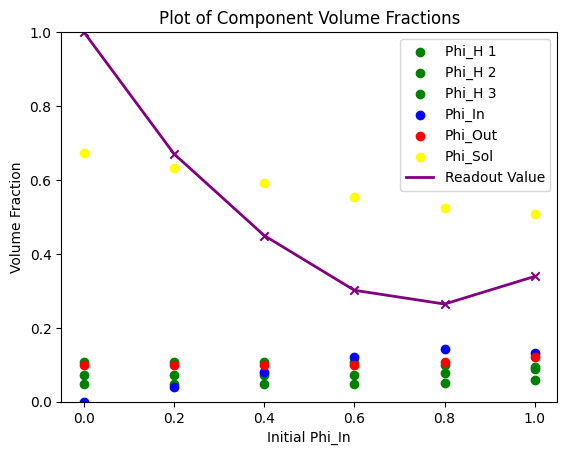

LOSS: 0.6869699022145717
IN BOUNDS
[[0.         5.81002213 5.6189191  5.67896162 5.70799929 0.        ]
 [5.81002213 0.         5.12515246 8.02987752 5.3721551  0.        ]
 [5.6189191  5.12515246 0.         5.11308694 4.23139537 0.        ]
 [5.67896162 8.02987752 5.11308694 0.         5.60532025 0.        ]
 [5.70799929 5.3721551  4.23139537 5.60532025 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.10838425 0.07201279 0.04727645 0.1        0.67232651]
 [0.04       0.10838425 0.07201279 0.04727645 0.1        0.63232651]
 [0.08       0.10838425 0.07201279 0.04727645 0.1        0.59232651]
 [0.12       0.10838425 0.07201279 0.04727645 0.1        0.55232651]
 [0.16       0.10838425 0.07201279 0.04727645 0.1        0.51232651]
 [0.2        0.10838425 0.07201279 0.04727645 0.1        0.47232651]]


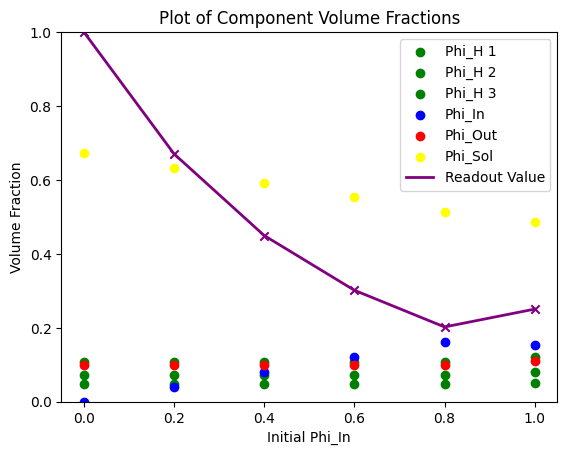

LOSS: 0.6060292393561713
IN BOUNDS
[[0.         5.28684426 5.32142355 6.52363016 6.20566321 0.        ]
 [5.28684426 0.         5.94424974 5.70642534 4.83790668 0.        ]
 [5.32142355 5.94424974 0.         4.17090475 6.65876112 0.        ]
 [6.52363016 5.70642534 4.17090475 0.         5.35727862 0.        ]
 [6.20566321 4.83790668 6.65876112 5.35727862 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.10838424 0.0720128  0.04727645 0.1        0.67232651]
 [0.04       0.10838424 0.0720128  0.04727645 0.1        0.63232651]
 [0.08       0.10838424 0.0720128  0.04727645 0.1        0.59232651]
 [0.12       0.10838424 0.0720128  0.04727645 0.1        0.55232651]
 [0.16       0.10838424 0.0720128  0.04727645 0.1        0.51232651]
 [0.2        0.10838424 0.0720128  0.04727645 0.1        0.47232651]]


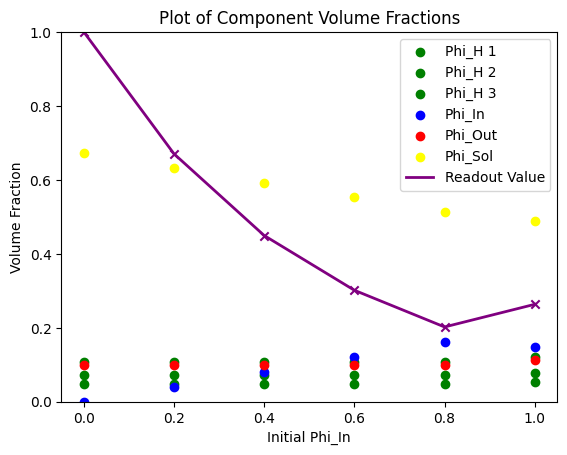

LOSS: 0.6126567108676497
IN BOUNDS
[[0.         6.28028536 4.92463906 6.60818873 4.04987674 0.        ]
 [6.28028536 0.         6.84662418 5.27798164 7.62226903 0.        ]
 [4.92463906 6.84662418 0.         5.54320869 7.41658749 0.        ]
 [6.60818873 5.27798164 5.54320869 0.         6.06849821 0.        ]
 [4.04987674 7.62226903 7.41658749 6.06849821 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.10838424 0.07201279 0.04727646 0.1        0.67232651]
 [0.04       0.10838424 0.07201279 0.04727646 0.1        0.63232651]
 [0.08       0.10838424 0.07201279 0.04727646 0.1        0.59232651]
 [0.12       0.10838424 0.07201279 0.04727646 0.1        0.55232651]
 [0.16       0.10838424 0.07201279 0.04727646 0.1        0.51232651]
 [0.2        0.10838424 0.07201279 0.04727646 0.1        0.47232651]]


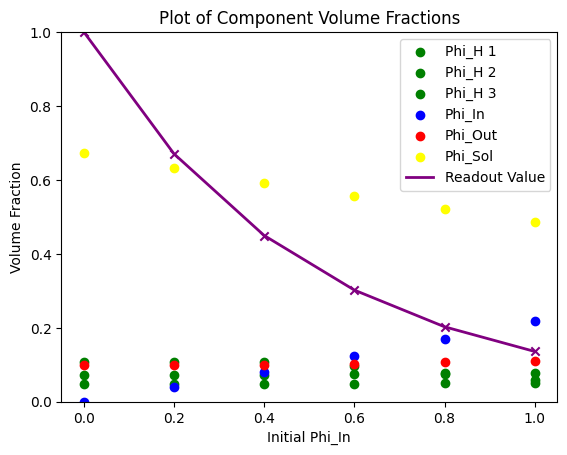

LOSS: 0.562230201135729
IN BOUNDS
[[0.         8.24882036 8.15704095 4.13805524 5.12224325 0.        ]
 [8.24882036 0.         6.75436229 7.21452524 5.13605062 0.        ]
 [8.15704095 6.75436229 0.         6.19084075 6.10206628 0.        ]
 [4.13805524 7.21452524 6.19084075 0.         4.25066373 0.        ]
 [5.12224325 5.13605062 6.10206628 4.25066373 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.10838425 0.0720128  0.04727645 0.1        0.6723265 ]
 [0.04       0.10838425 0.0720128  0.04727645 0.1        0.6323265 ]
 [0.08       0.10838425 0.0720128  0.04727645 0.1        0.5923265 ]
 [0.12       0.10838425 0.0720128  0.04727645 0.1        0.5523265 ]
 [0.16       0.10838425 0.0720128  0.04727645 0.1        0.5123265 ]
 [0.2        0.10838425 0.0720128  0.04727645 0.1        0.4723265 ]]


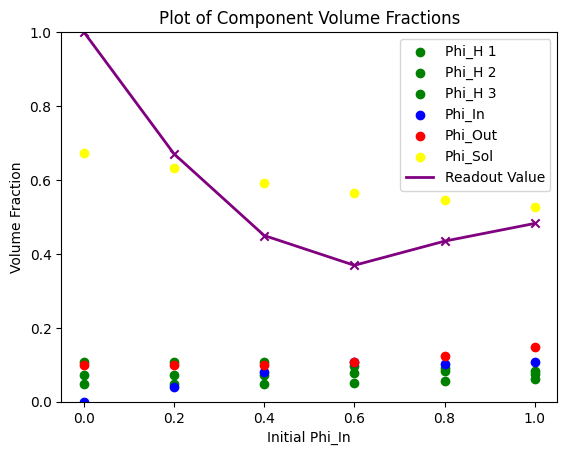

LOSS: 0.9685956150519867
IN BOUNDS
[[0.         6.38942724 5.23899675 5.01903568 5.4265259  0.        ]
 [6.38942724 0.         5.940175   6.39857448 6.06352563 0.        ]
 [5.23899675 5.940175   0.         7.2650509  5.49693729 0.        ]
 [5.01903568 6.39857448 7.2650509  0.         6.67191435 0.        ]
 [5.4265259  6.06352563 5.49693729 6.67191435 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.10838426 0.0720128  0.04727645 0.1        0.67232649]
 [0.04       0.10838426 0.0720128  0.04727645 0.1        0.63232649]
 [0.08       0.10838426 0.0720128  0.04727645 0.1        0.59232649]
 [0.12       0.10838426 0.0720128  0.04727645 0.1        0.55232649]
 [0.16       0.10838426 0.0720128  0.04727645 0.1        0.51232649]
 [0.2        0.10838426 0.0720128  0.04727645 0.1        0.47232649]]


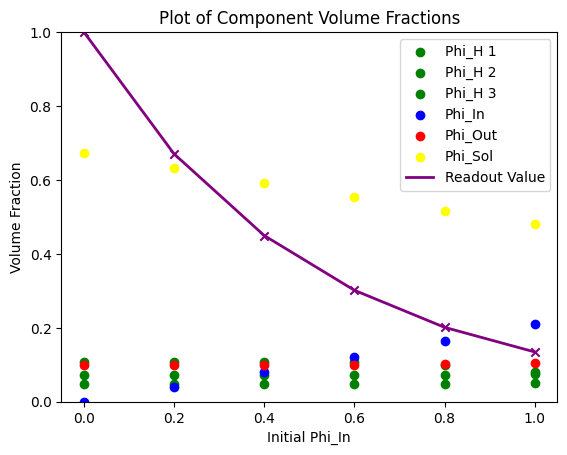

LOSS: 0.5610306709929299
IN BOUNDS
[[0.         7.57166097 5.64801381 4.19342042 4.98196711 0.        ]
 [7.57166097 0.         4.11548454 6.10445479 6.4822297  0.        ]
 [5.64801381 4.11548454 0.         6.49222187 5.11966605 0.        ]
 [4.19342042 6.10445479 6.49222187 0.         5.67011367 0.        ]
 [4.98196711 6.4822297  5.11966605 5.67011367 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.10838425 0.07201281 0.04727645 0.1        0.67232649]
 [0.04       0.10838425 0.07201281 0.04727645 0.1        0.63232649]
 [0.08       0.10838425 0.07201281 0.04727645 0.1        0.59232649]
 [0.12       0.10838425 0.07201281 0.04727645 0.1        0.55232649]
 [0.16       0.10838425 0.07201281 0.04727645 0.1        0.51232649]
 [0.2        0.10838425 0.07201281 0.04727645 0.1        0.47232649]]


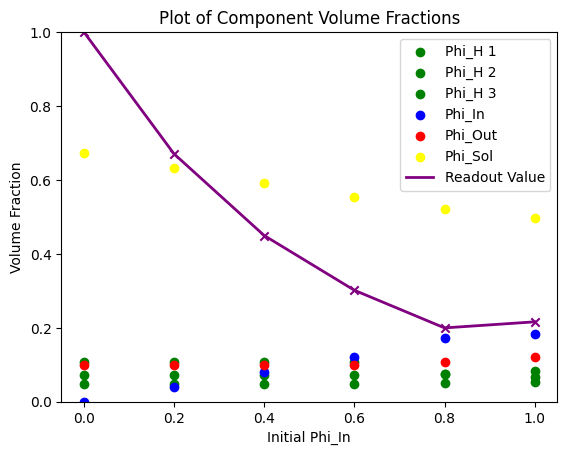

LOSS: 0.5889354277728365
IN BOUNDS
[[0.         4.44899127 5.88757128 5.55945385 4.70367695 0.        ]
 [4.44899127 0.         5.53861038 6.21493412 4.30371219 0.        ]
 [5.88757128 5.53861038 0.         5.71384263 5.79597586 0.        ]
 [5.55945385 6.21493412 5.71384263 0.         8.26683852 0.        ]
 [4.70367695 4.30371219 5.79597586 8.26683852 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[[0.         0.10838425 0.0720128  0.04727646 0.1        0.67232649]
 [0.04       0.10838425 0.0720128  0.04727646 0.1        0.63232649]
 [0.08       0.10838425 0.0720128  0.04727646 0.1        0.59232649]
 [0.12       0.10838425 0.0720128  0.04727646 0.1        0.55232649]
 [0.16       0.10838425 0.0720128  0.04727646 0.1        0.51232649]
 [0.2        0.10838425 0.0720128  0.04727646 0.1        0.47232649]]


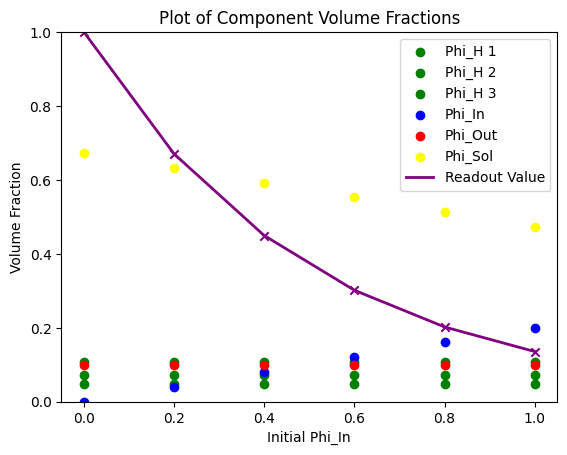

LOSS: 0.5617233031362454


In [522]:

bounds = [[0,0.6], [0,0.6], [0,0.6]]
result_DE = differential_evolution(evolve_components_flory_loss,bounds = bounds, maxiter = 5, popsize = 2)